# **Predicting Customer Churn for Bank**

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('precision', 3)

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

# Statistic
from scipy.stats import chi2_contingency

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

#Neural network
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

#Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC #Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier #Xtreme Gradient Boosting Classifier

#Figures
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve, confusion_matrix, classification_report
import scikitplot as skplt

For Models i will use hyperparameter tuning using GridSearchCV

In [ ]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn_Modelling.csv')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

It contains 10000 rows and 14 columns.


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

Our DataFrame has 14 features/attributes and 10K customers/instances. The last feature, 'Exited', is the target variable and indicates whether the customer has churned (0 = No, 1 = Yes).

The meaning of the rest of the features can be easily inferred from their name.

---
Features 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped:

In [ ]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [ ]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary', 'Tenure']
categorical = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', continuous)
print('Categorical: ', categorical)

Continuous:  ['Age', 'CreditScore', 'Balance', 'EstimatedSalary', 'Tenure']
Categorical:  ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']


There are no missing values in our data.

We moslty have categorical variables and 5 continuous variables.


In [ ]:
# Get unique count for each variable
df.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

In [ ]:
df.describe().T

#The describe() method gives us a statistical summary of the numerical features:

count        mean        std     min       25%         50%  \
CreditScore      10000.0     650.529     96.653  350.00    584.00     652.000   
Age              10000.0      38.922     10.488   18.00     32.00      37.000   
Tenure           10000.0       5.013      2.892    0.00      3.00       5.000   
Balance          10000.0   76485.889  62397.405    0.00      0.00   97198.540   
NumOfProducts    10000.0       1.530      0.582    1.00      1.00       1.000   
HasCrCard        10000.0       0.706      0.456    0.00      0.00       1.000   
IsActiveMember   10000.0       0.515      0.500    0.00      0.00       1.000   
EstimatedSalary  10000.0  100090.240  57510.493   11.58  51002.11  100193.915   
Exited           10000.0       0.204      0.403    0.00      0.00       0.000   

                        75%        max  
CreditScore         718.000     850.00  
Age                  44.000      92.00  
Tenure                7.000      10.00  
Balance          127644.240  250898.09  
NumOfProducts         2.000       4.00  
HasCrCard             1.000       1.00  
IsActiveMember        1.000       1.00  
EstimatedSalary  149388.247  199992.48  
Exited                0.000       1.00

After exploring our data we can note a few things:


*   The age of customers ranges from 18 to 92, with a mean value approximately equal to 40,
*   The mean tenure is 5 years, so the majority of customers is loyal (tenure > 3),
*   Approximately 50% of customers are active,
*   Data is taken from 3 coutries.


Our data could me expanded for more understanding with break down to the products bought into by a customer. But we have to work with what we have.


# Creating test set

However, before we look at the data any further, we need to create a test set, put it aside, and use it only to evaluate our Machine Learning models. This practice protects our models from data snooping bias and ensures that evaluation will be performed using unseen data. Data snooping is a form of statistical bias manipulating data or analysis to artificially get statistically significant results.

We will split our dataset into a train and test set using scikit-learn's `train_test_split()` function, which implements random sampling.

In [ ]:
#test size - 20% size of the original data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'Train set: {train_df.shape[0]} rows x {train_df.shape[1]} columns')
print(f' Test set: {test_df.shape[0]} rows x {test_df.shape[1]} columns')

Train set: 8000 rows x 11 columns
 Test set: 2000 rows x 11 columns


# Exploratory Data Analysis

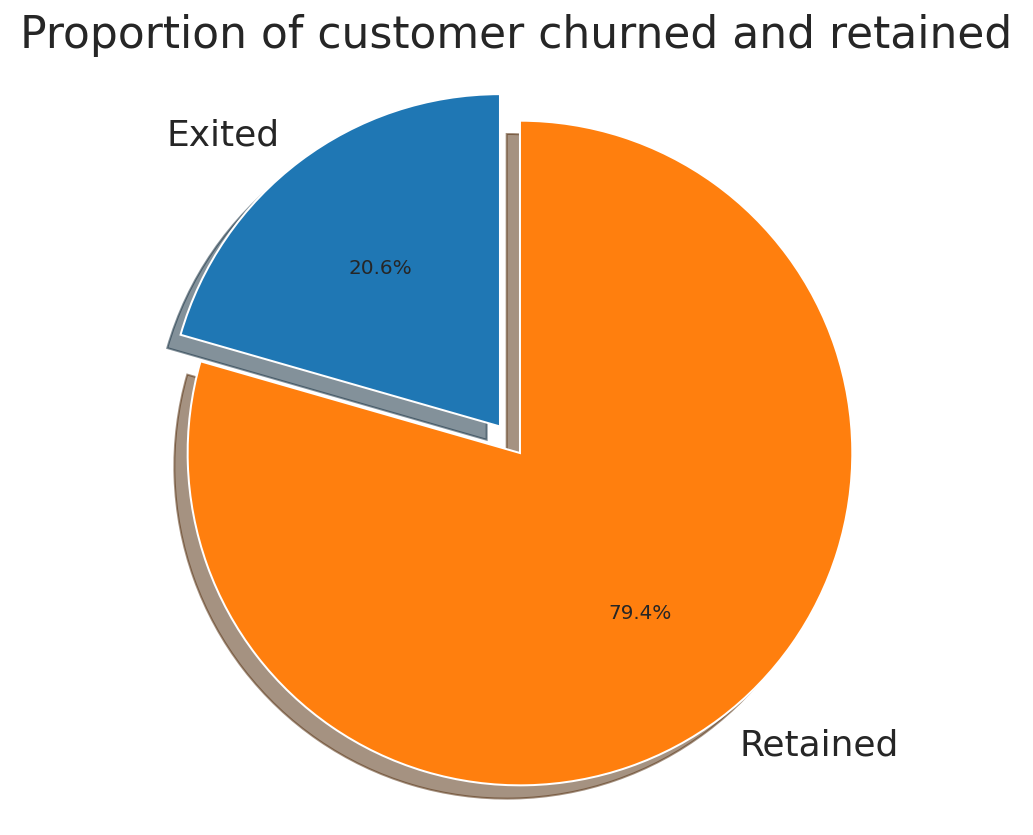

In [ ]:
labels = 'Exited', 'Retained'
sizes = [train_df.Exited[train_df['Exited']==1].count(), train_df.Exited[train_df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(9, 7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained")
plt.show()

So about 20% of the customers have churned and bank kept 80% of its clientele.

## **Continous variables**


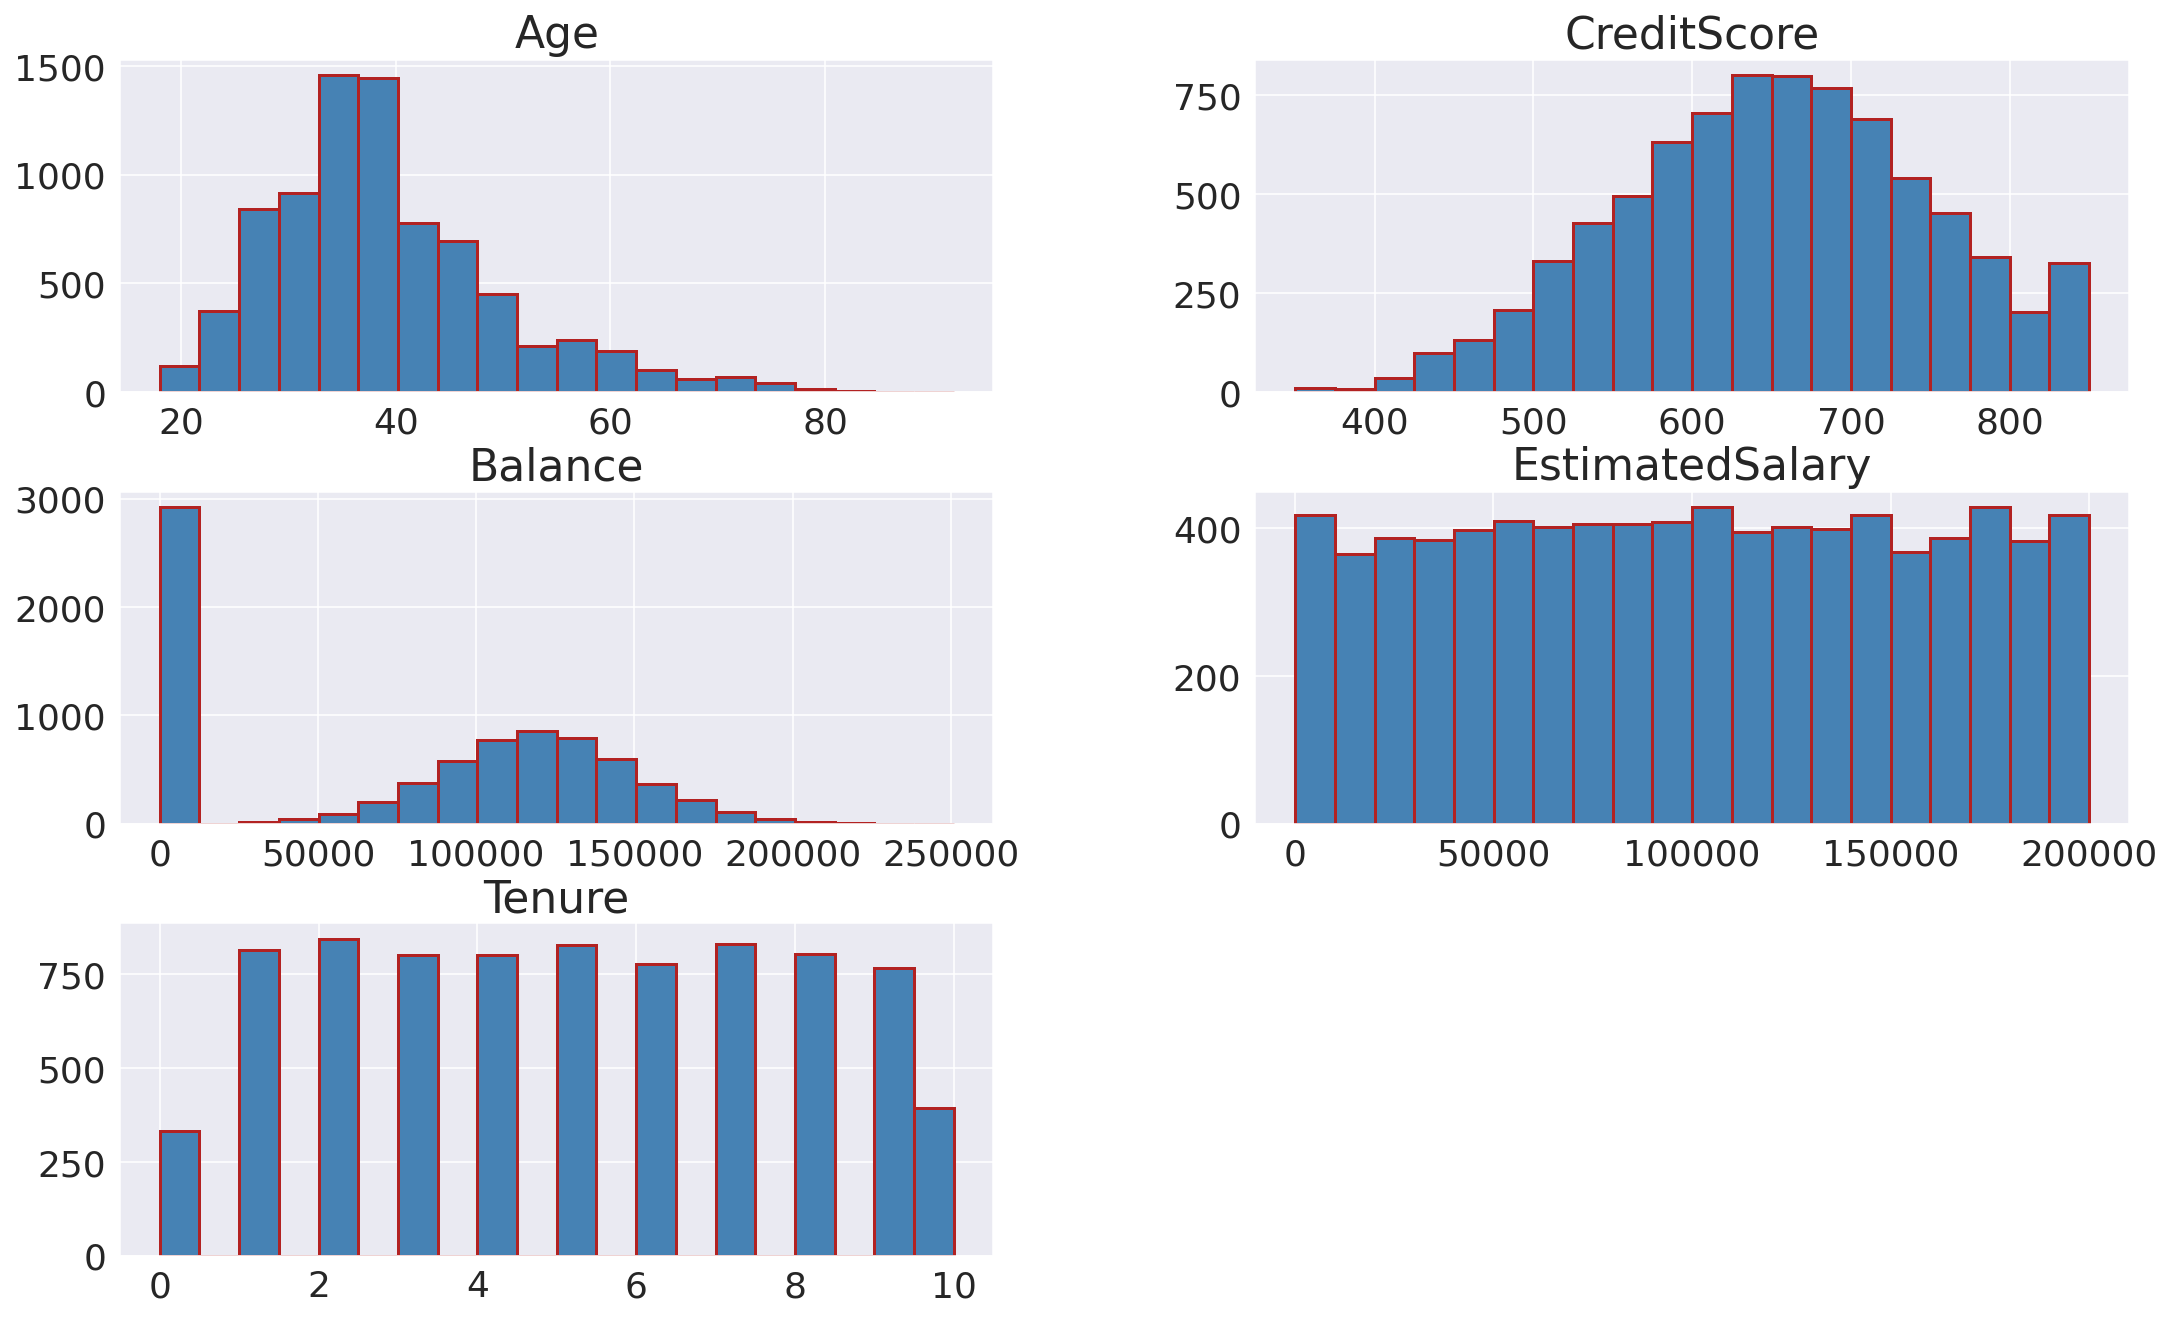

In [ ]:
train_df[continuous].hist(figsize=(18, 11),
                          bins=20,
                          layout=(3, 2),
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);


- 'Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left,
- Most values for 'CreditScore' are above 600,
- If we ignore the first bin, 'Balance' follows a fairly normal distribution,
- The distribution of 'EstimatedSalary' and 'Tenure' is more or less uniform and provides little information.



**Looking for Correlations**

We can compute the standard correlation coefficient between every pair of (continuous) features using the pandas' `corr()` method and plot it as a matrix:

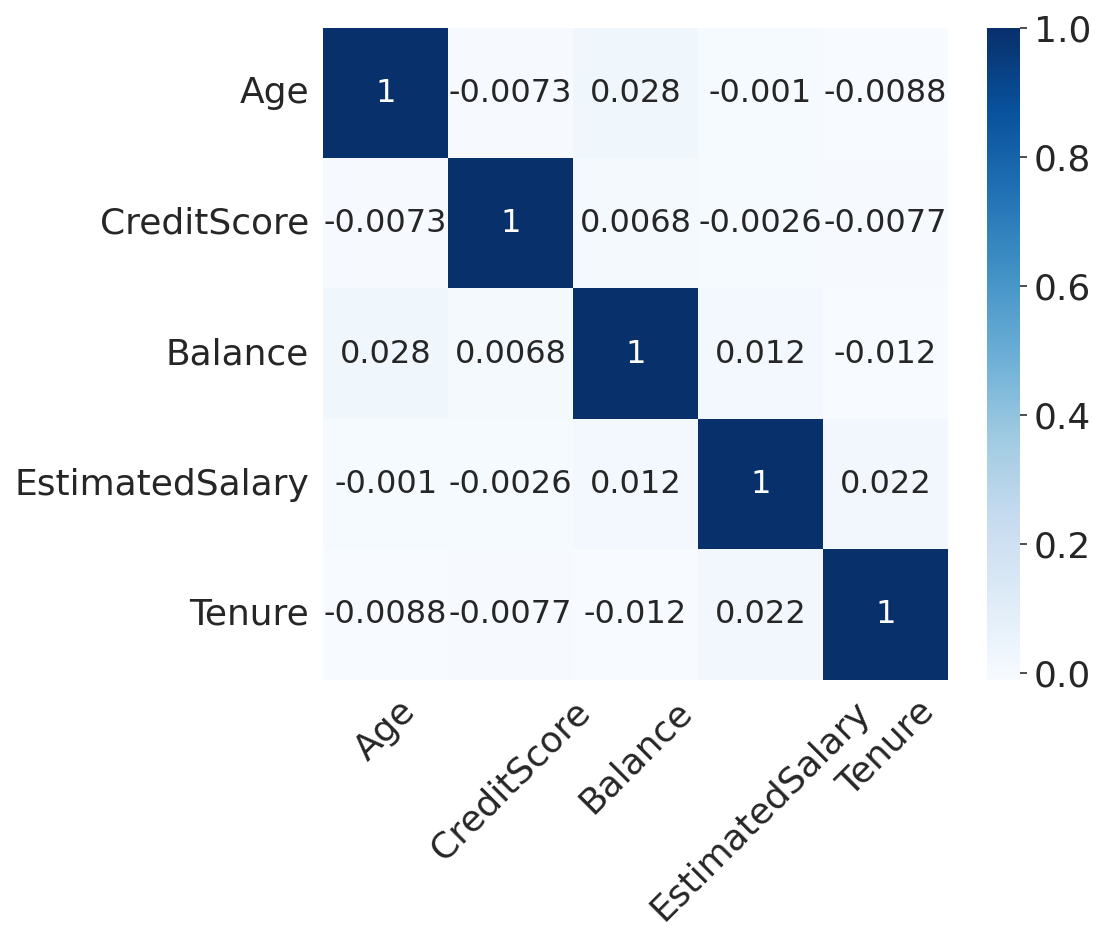

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

Our features are not coorelated

We can now check if there is some coorelation between those features and churning of customers.

In [ ]:
def plot_continuous(feature, bins = 15):
    #Plot a histogram and boxplot for the churned and retained distributions for the specified feature.
    #Found on kaggle.
    df_func = train_df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(8, 6),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=bins,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout();


**Age**

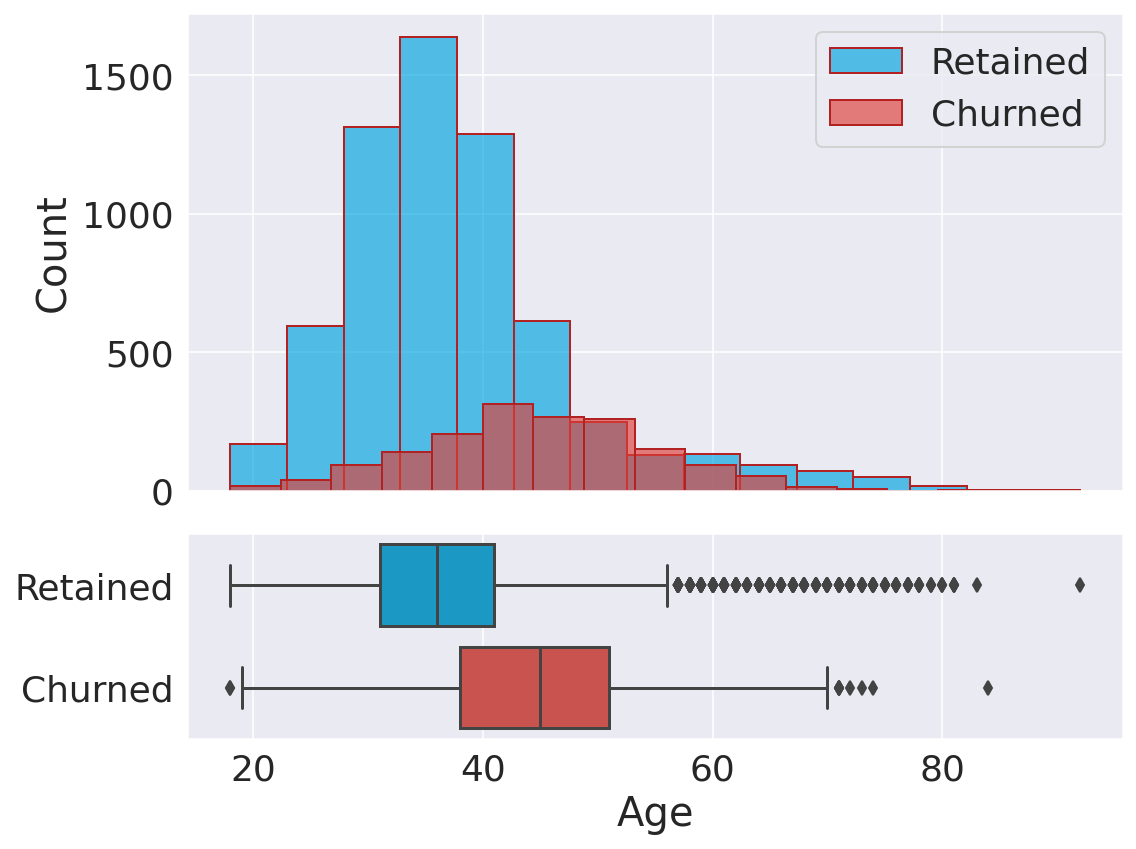

In [ ]:
df_churned = train_df[train_df['Exited'] == 1]
df_retained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

**CreditScore**

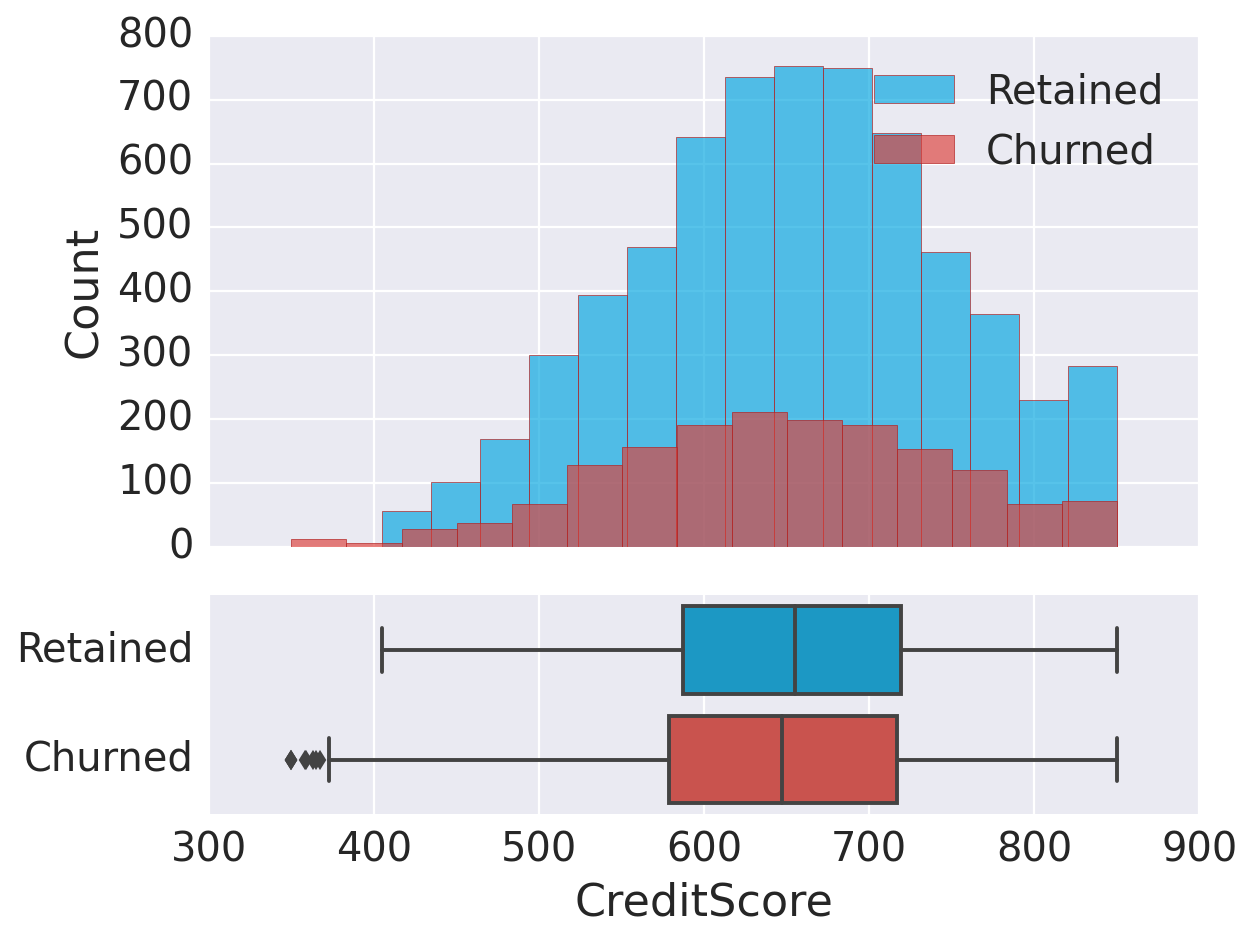

In [ ]:
plot_continuous('CreditScore')

**Balance**

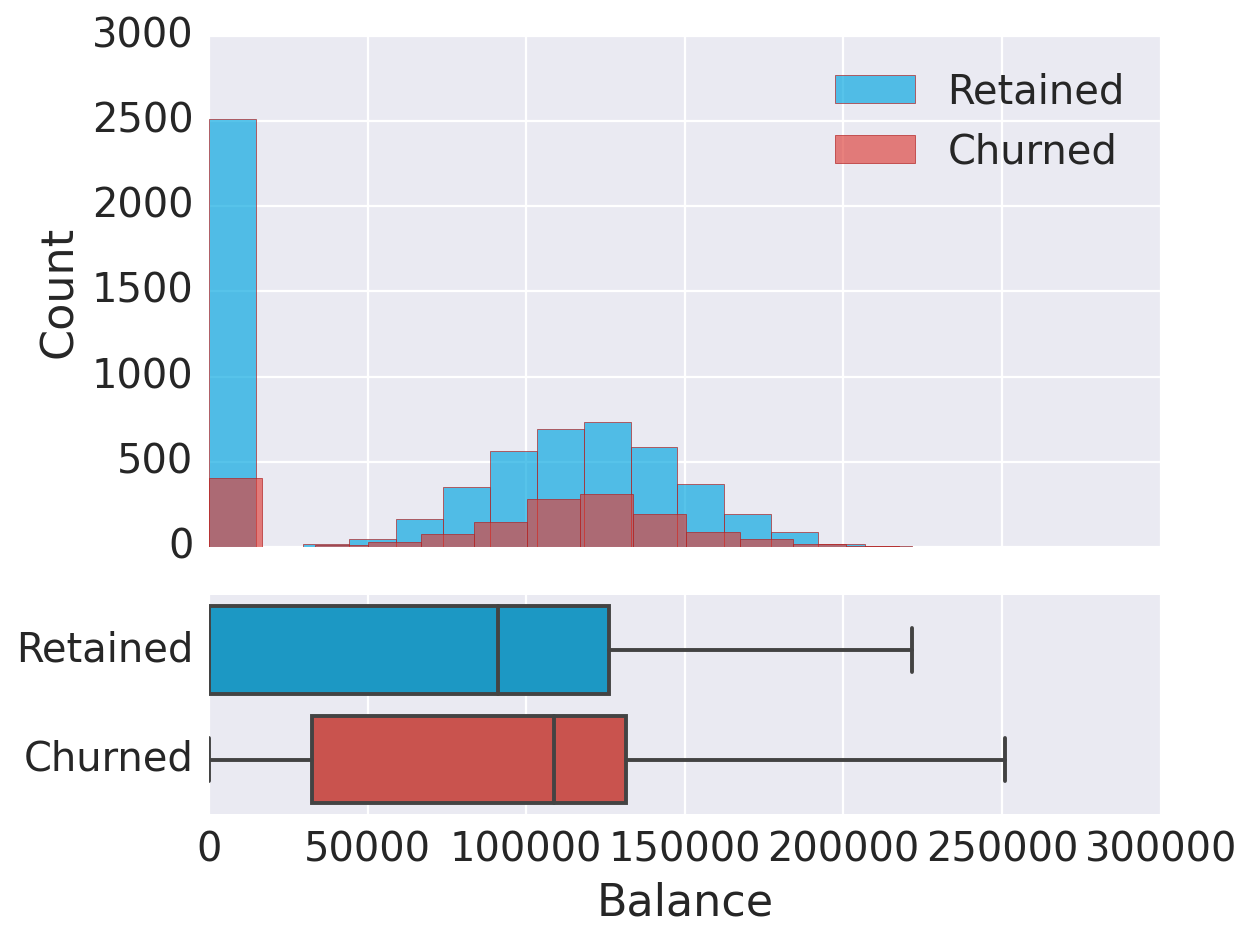

In [ ]:
plot_continuous('Balance')

**EstimatedSalary**

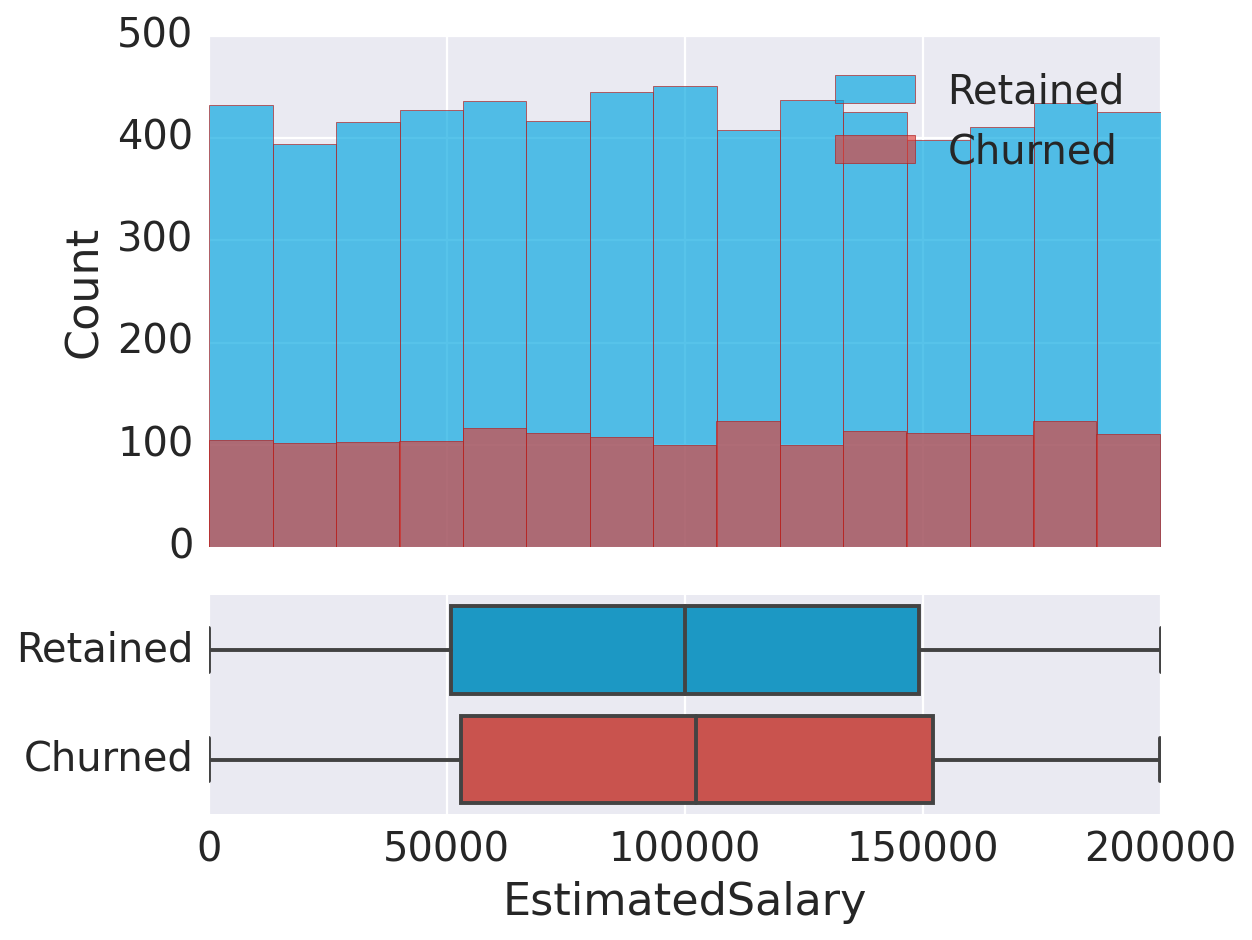

In [ ]:
plot_continuous('EstimatedSalary')

**Tenure**

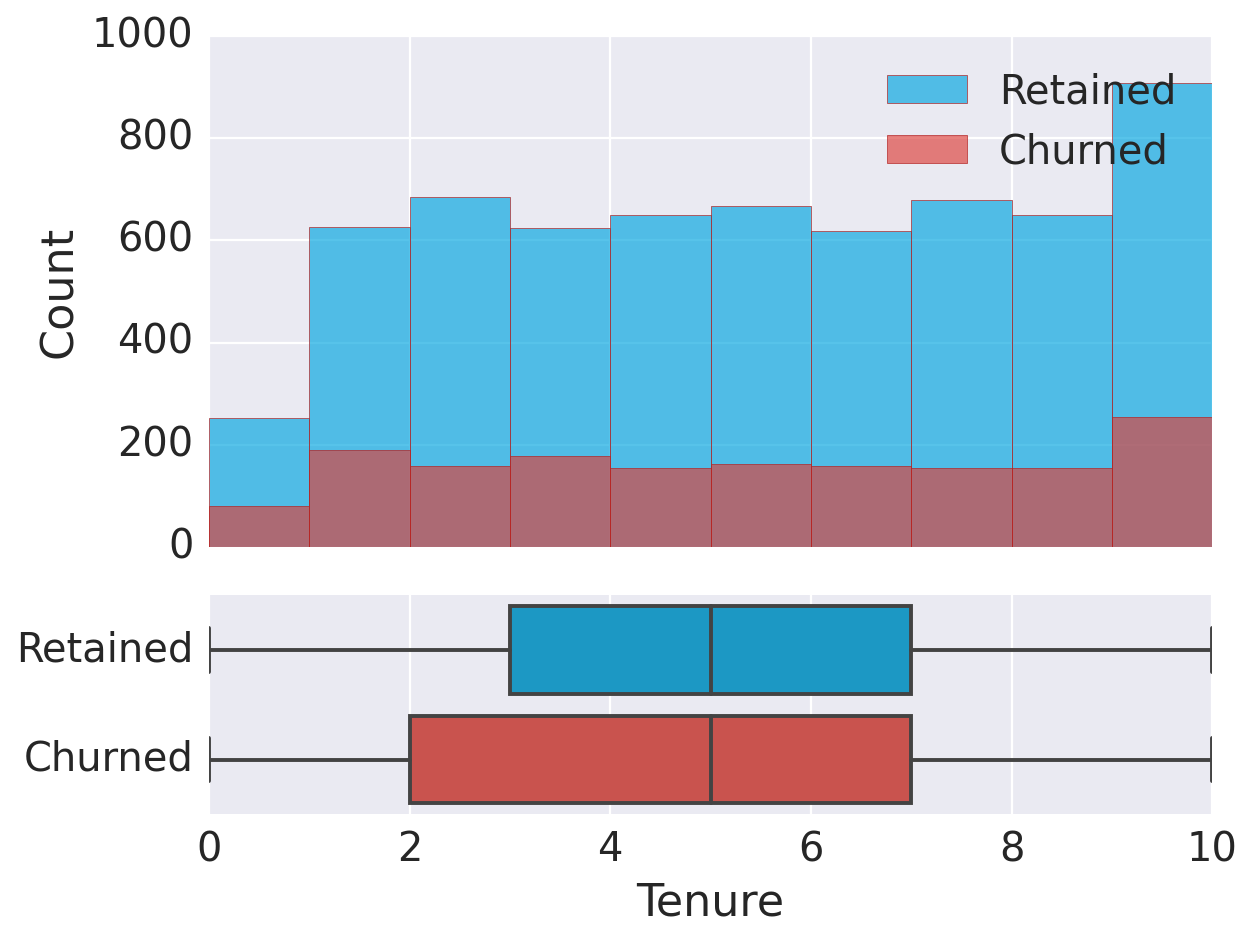

In [ ]:
plot_continuous('Tenure', 10)

We can notice:

*   For 'Age' group there is a clear difference between groups since older customers are more likely to churn. This observation could potentially indicate that preferences change with age, and the bank hasn't adapted its strategy to meet the requirements of older customers,
*   For 'CreditScore' there is not significant coorelation with churning,
*   For 'Balance' we can see that more customers are staying with bank if they have lower balance on account,
*   For 'EstimatedSalary' there is not significant coorelation with churning,
*   For 'Tenure' we can see that more customers are quiting with bank if they have lower tenure.


## Categorical Variables

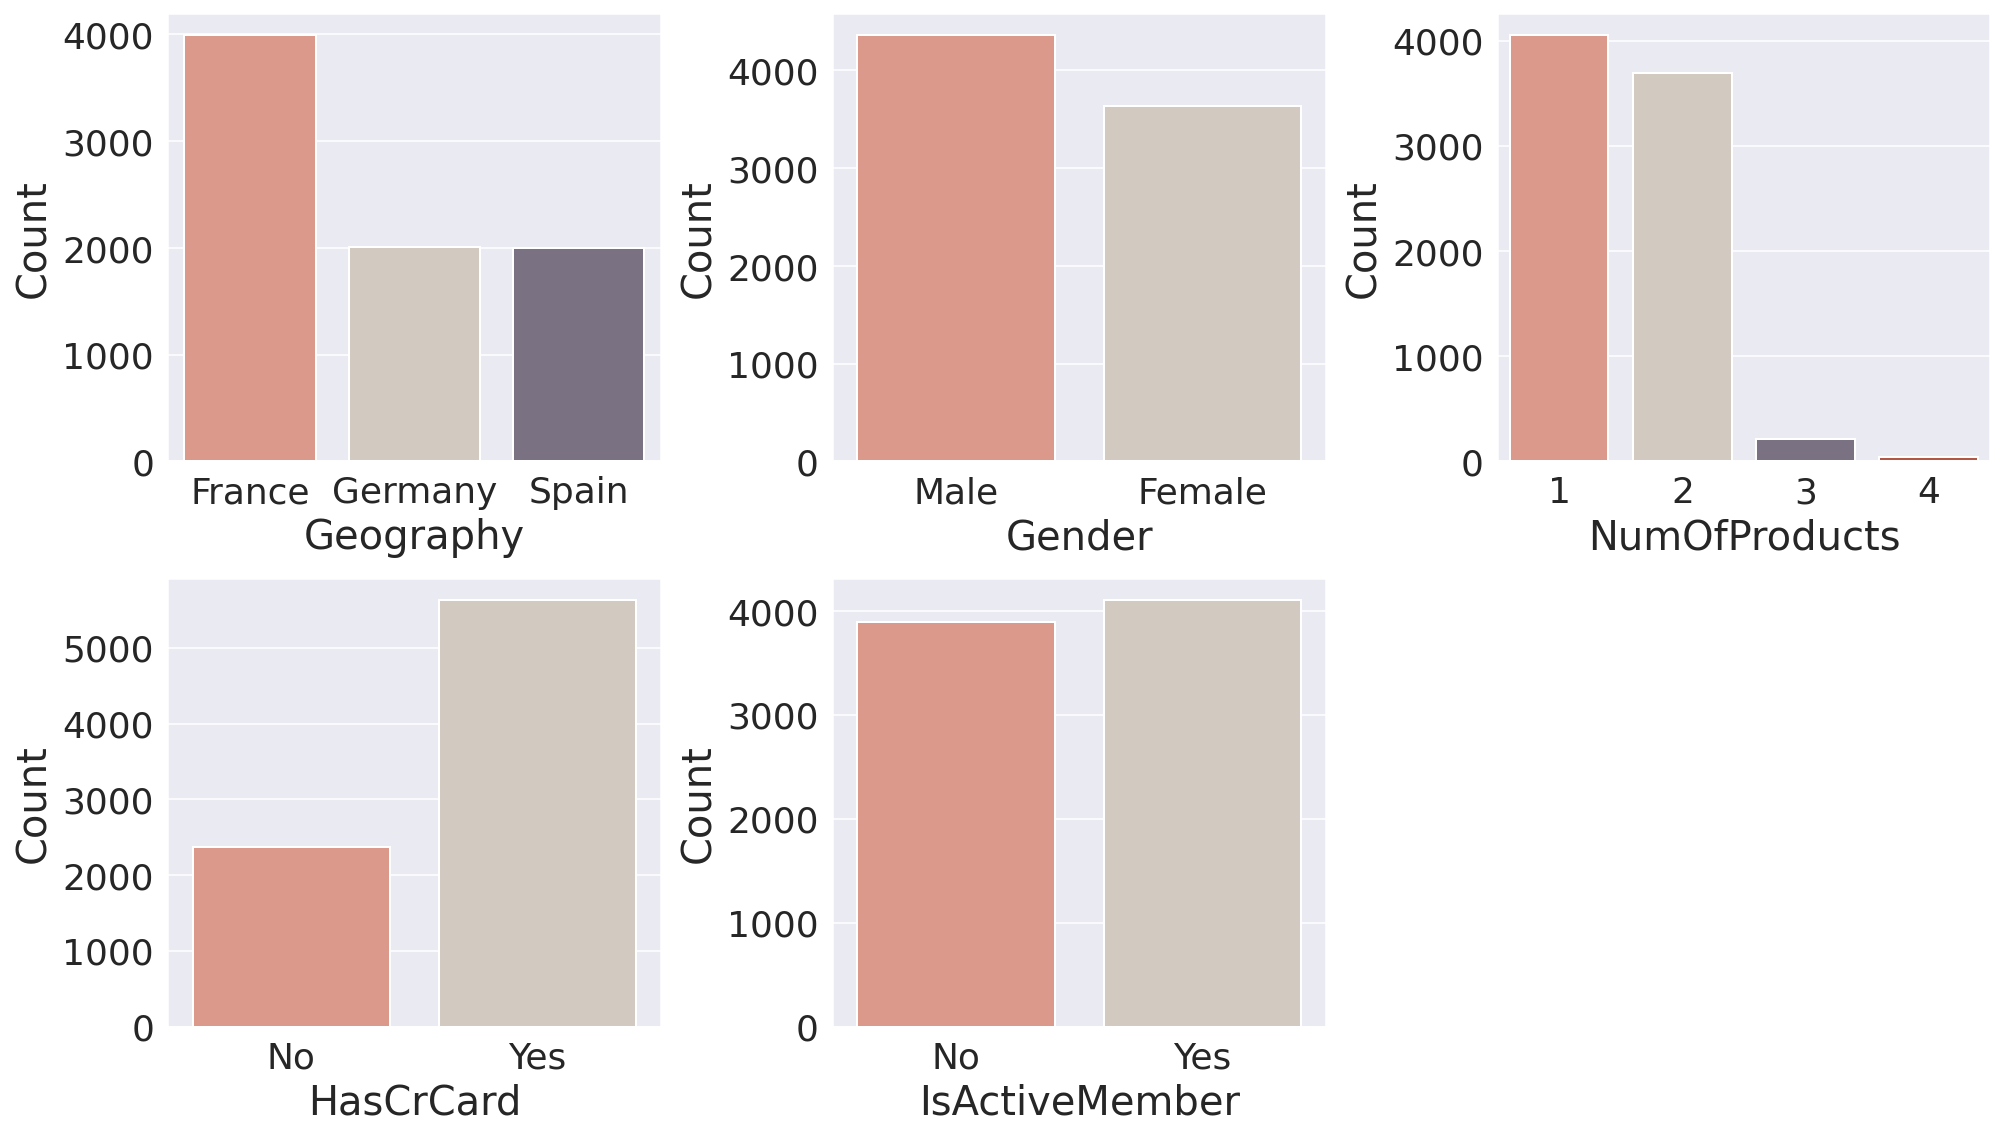

In [ ]:
df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=train_df, palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();


We can observe that:
- The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
- There are more male customers than females,
- Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
- A significant majority of customers has a credit card,
- Almost 50% of customers are not active.

In [ ]:
def plot_categorical(feature):
    #For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.
    #Taken from kaggle
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    sns.countplot(x=feature,
                  hue='Exited',
                  data=train_df,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=train_df,
                palette=colors_cat,
                ax=ax2)
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout();

**Geography**

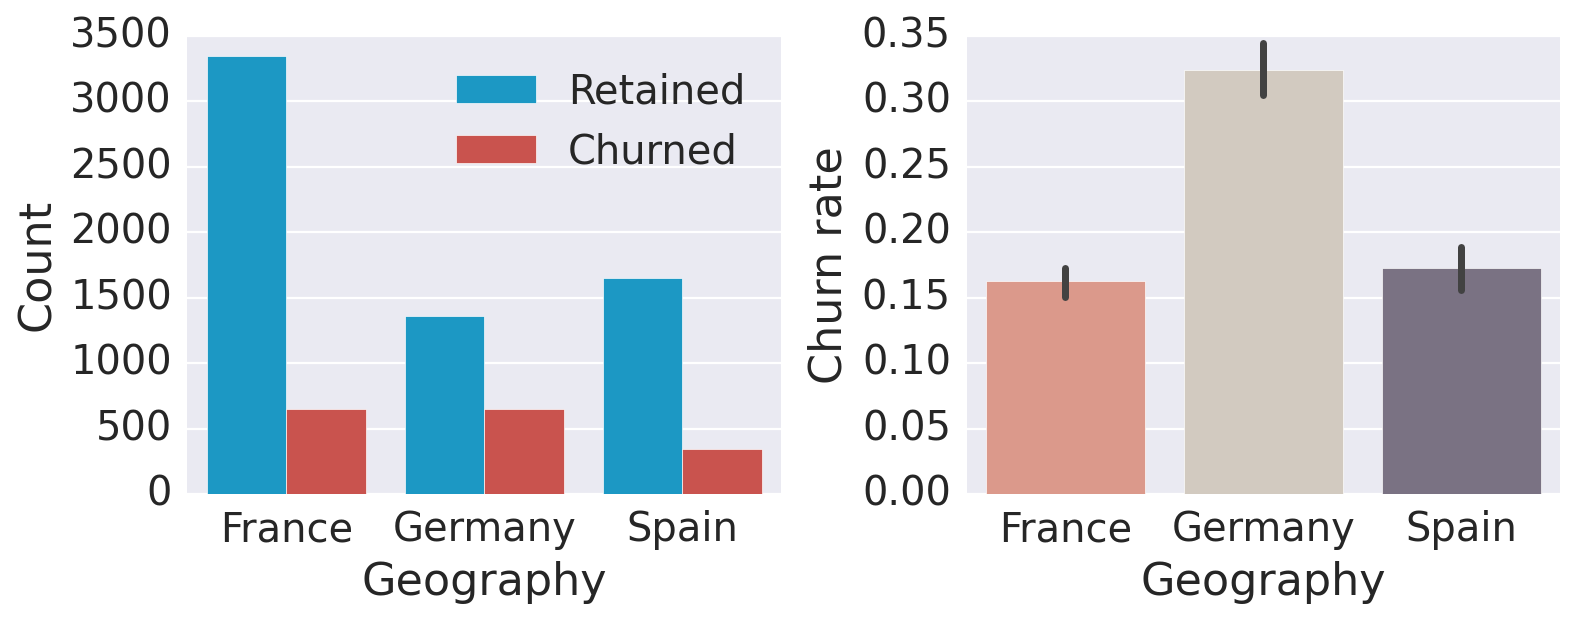

In [ ]:
plot_categorical('Geography')

**Gender**

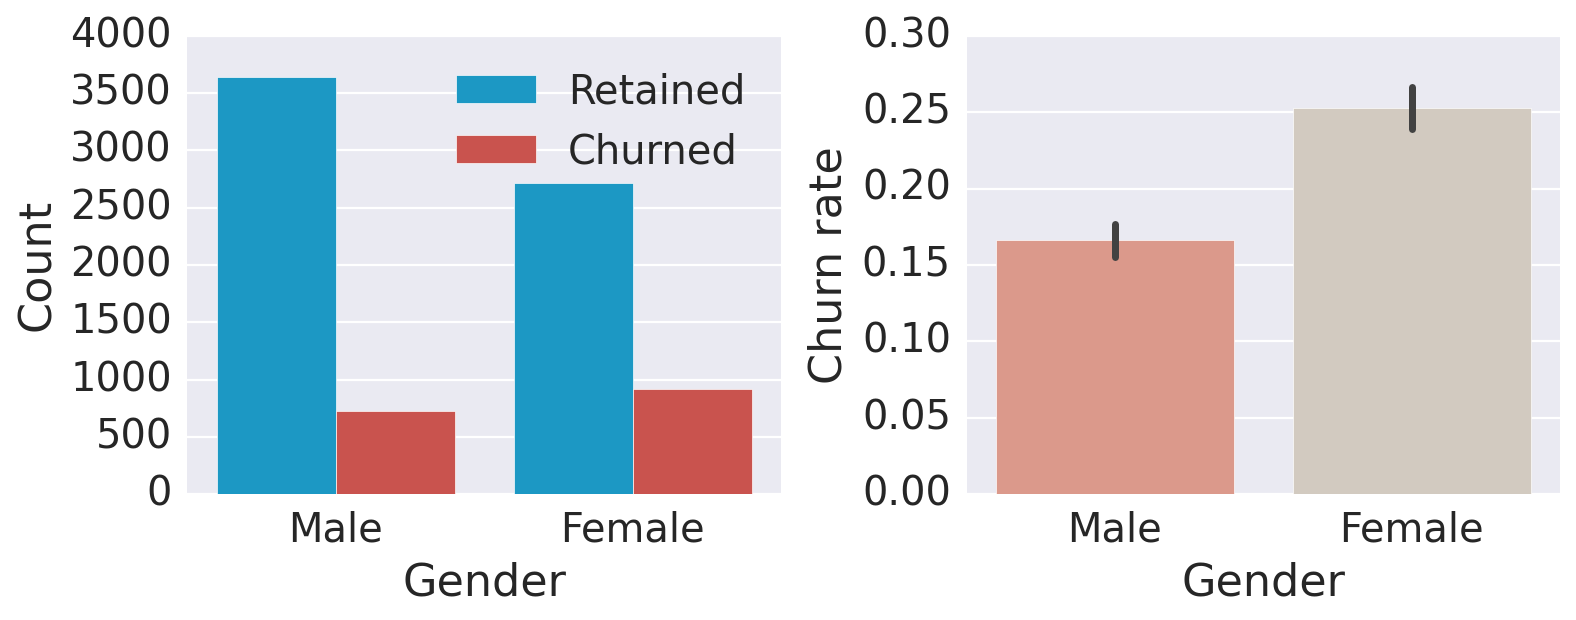

In [ ]:
plot_categorical('Gender')

**NumOfProducts**

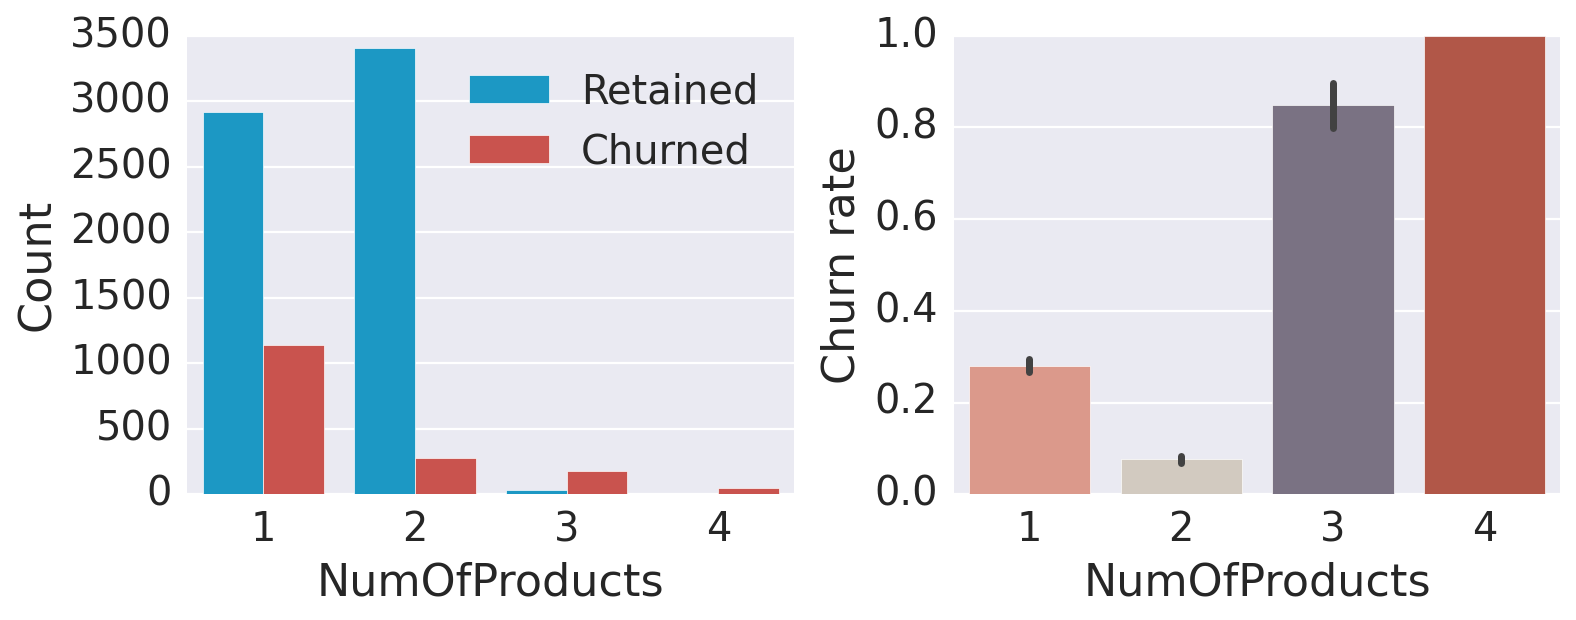

In [ ]:
plot_categorical('NumOfProducts')

**HasCrCard**

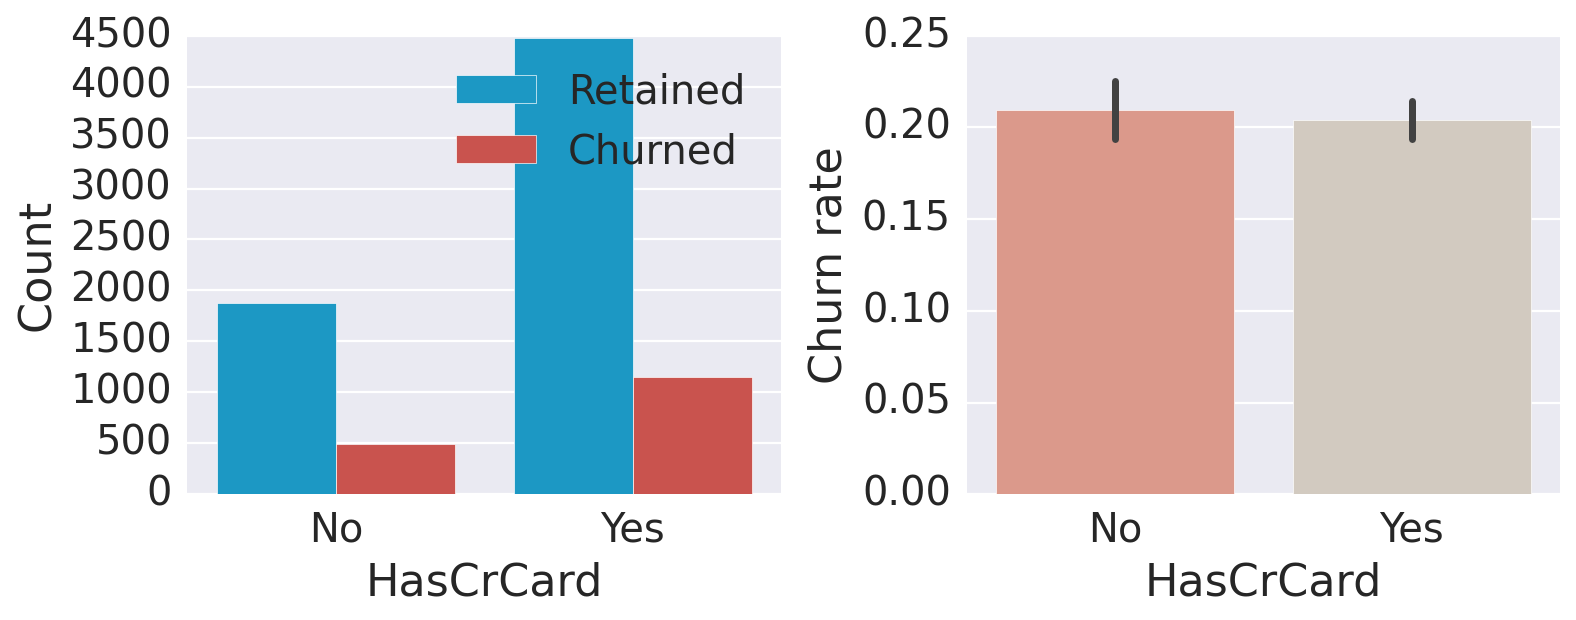

In [ ]:
plot_categorical('HasCrCard')

**IsActiveMember**

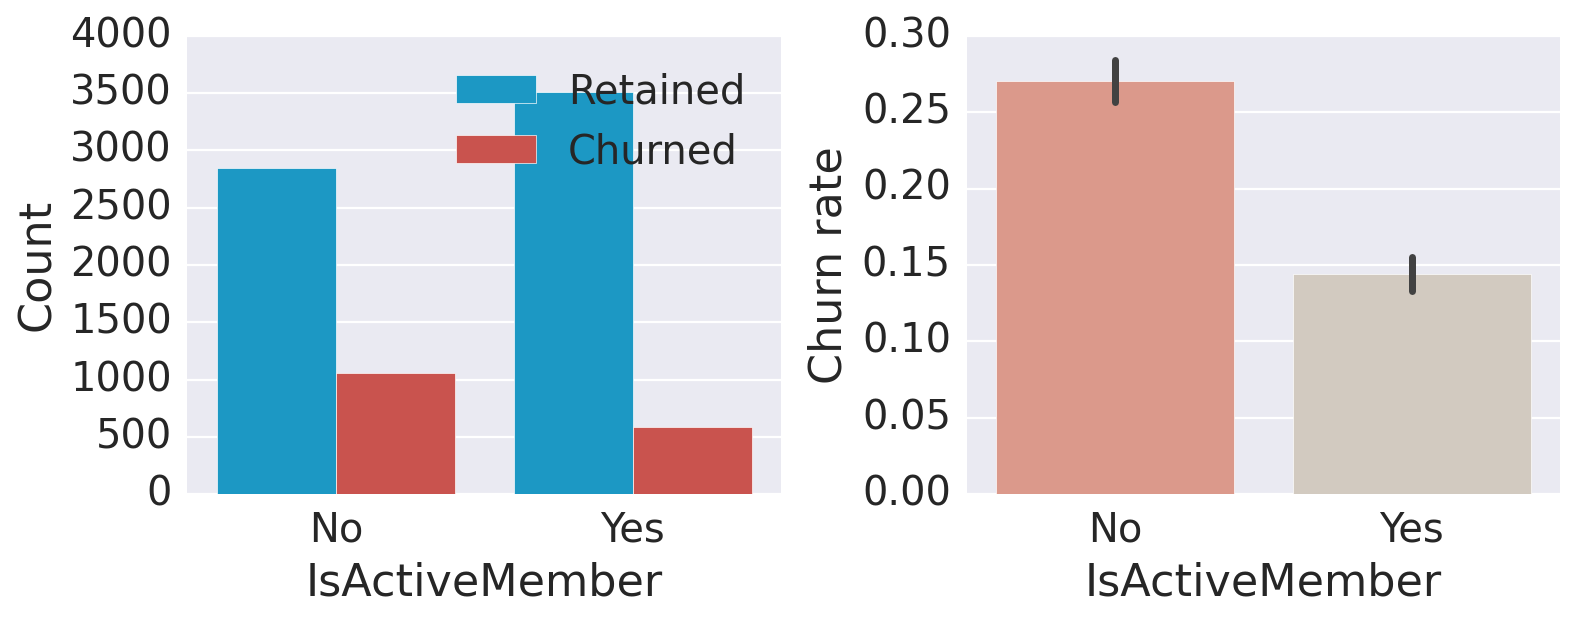

In [ ]:
plot_categorical('IsActiveMember')

We can notice:

*   For 'Geograpy' group customers from Germany are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France). Many reasons could explain this finding, such as higher competition or different preferences for German customers.
*   For 'Gender' we can see that females are much more likely to churn that males,
*   For 'NumOfProducts' we can see that having 3 or 4 products significantly increases the likelihood of churn. It could potentially mean that the bank cannot properly support customers with more products which in turn increases customer dissatisfaction or these options are not enought for them,
*   For 'HasCrCard' there is not significant coorelation with churning,
*   For 'IsActiveMember' it is not a surprise that inactive customers are more likely to churn. A significant portion of the clientele is inactive. Therefore, the bank will benefit from changing its policy so that more customers become active.


# Data Preprocesing

Data preprocessing is the process of converting raw data into a well-readable format that is suitable for building and training Machine Learning models.

## Feature Selection

We have already performed feature selection by dropping columns 'RowNumber', 'CustomerId', and 'Surname' at the beginning. Exploatory data analysis revealed several more features that can be dropped as they do not provide any value in predicting our target variable:

- 'EstimatedSalary' displays a uniform distribution for both types of customers and can be dropped.
- 'CreditScore' displays a normal distribution for both types of customers and can be dropped.
- The category 'HasCrCard' have a the same churn rate and is deemed redundant.

This can be confirmed from a chi-square test:

In [ ]:
chi2_array, p_array = [], []
for column in continuous + categorical:

    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': continuous + categorical,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)

Variable  Chi-square     p-value
3  EstimatedSalary    8000.000   4.916e-01
2          Balance    5856.243   1.090e-13
0              Age    1294.931  2.345e-227
7    NumOfProducts    1233.595  3.767e-267
1      CreditScore     507.147   4.886e-02
5        Geography     230.748   7.829e-51
9   IsActiveMember     195.315   2.199e-44
6           Gender      90.173   2.183e-21
4           Tenure      15.197   1.250e-01
8        HasCrCard       0.301   5.833e-01

'Tenure' also looks like it can be dropped from the test but exploratory data analysis showed that it has little importance. We can try to explore this data more to be sure.

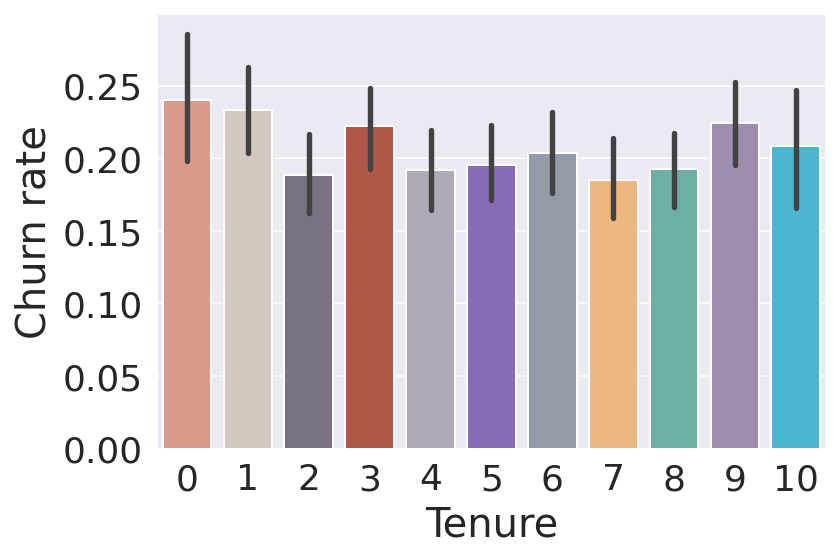

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6, 4))
sns.barplot(x='Tenure',
            y='Exited',
            data=train_df,
            palette=colors_cat,
            ax=ax1)
ax1.set_ylabel('Churn rate')
plt.show()

I decided to drop 'Tenure', 'HasCrCard' and 'EstimatedSalary' because they have a small chi-square and a p-value greater than 0.05, confirming our initial hypothesis that these three features do not convey any useful information.

In [ ]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

## Encoding Categorical Features

Machine learning algorithms usually require that all input (and output) features are numeric. Consequently, categorical features need to be converted (encoded) to numbers before building models.

Our dataset contains two features that require encoding.

- For 'Gender', we will use scikit-learn's `LabelEncoder()` which maps each unique label to an integer (Male --> 1 and Female --> 0).
- For 'Geography', we will manually map values so that customers in Germany have the value of one (1) and all other customers (France and Spain) have zero (0). I chose this method since the churn rate for customers in the other two countries is almost the same and considerably lower than in Germany. Therefore, it makes sense to encode this feature so that it differentiates between German and non-German customers.

In [ ]:
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

## Scaling

Feature scaling is a technique used to normalise the range of features in a dataset. Some algorithms are sensitive to feature scaling (e.g. SVMs), while others are invariant (e.g. Random Forests).

I decided to use `StandardScaler()`, which standardises features by subtracting the mean and dividing by the standard deviation. This transformation results in features with zero mean and unit variance.

In [ ]:
scaler = StandardScaler()
scl_columns = ['Age', 'Balance', 'NumOfProducts', 'CreditScore']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])
train_df.head()

CreditScore  Geography  Gender    Age  Balance  NumOfProducts  \
0        0.356          0       1 -0.656   -1.218          0.808   
1       -0.204          1       1  0.295    0.697          0.808   
2       -0.961          0       1 -1.416    0.619         -0.917   
3       -0.941          0       0 -1.131    0.953         -0.917   
4       -1.397          0       1  1.626    1.057         -0.917   

   IsActiveMember  Exited  
0               1       0  
1               1       0  
2               0       1  
3               0       1  
4               0       1

We will now split the train set into 'X_train' and 'y_train' sets:

In [ ]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


Now let's do the same but with test data

In [ ]:
test_df = test_df.drop(features_drop, axis=1)

test_df['Gender'] = LabelEncoder().fit_transform(test_df['Gender'])
test_df['Geography'] = test_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

test_df[scl_columns] = scaler.transform(test_df[scl_columns])  # not fit_transform, scaler has already been trained

y_test = test_df['Exited']
X_test = test_df.drop('Exited', 1)
test_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


CreditScore  Geography  Gender    Age  Balance  NumOfProducts  \
0       -0.577          1       1 -0.656    0.330          0.808   
1       -0.297          0       1  0.390   -1.218          0.808   
2       -0.526          0       0  0.485   -1.218          0.808   
3       -1.511          1       1  1.911    0.689          0.808   
4       -0.951          0       0 -1.131    0.783         -0.917   

   IsActiveMember  Exited  
0               0       0  
1               1       0  
2               0       0  
3               1       0  
4               1       0

## Addressing Class Imbalance

There is an imbalance in the classes to be predicted that we need to take care of, with one class (0 – retained) much more prevalent than the other (1 - churned):

In [ ]:
train_df.value_counts()

CreditScore  Geography  Gender  Age     Balance  NumOfProducts  IsActiveMember  Exited
 2.058       0          0       -0.941  -1.218    0.808         1               0         3
-0.214       0          1       -0.941  -1.218    0.808         1               0         3
 2.058       0          1       -0.751  -1.218    0.808         0               0         3
 0.709       0          1       -0.561  -1.218    0.808         1               0         2
 0.118       0          1       -0.371  -1.218    0.808         1               0         2
                                                                                         ..
-0.432       0          0        0.580  -1.218   -0.917         0               1         1
                                -0.371   0.093   -0.917         1               0         1
                                -0.751   0.507   -0.917         1               0         1
                                        -1.218    0.808         0               0    

In [ ]:
y_train.value_counts()

0    6356
1    1644
Name: Exited, dtype: int64

In [ ]:
y_train.head()

0    0
1    0
2    1
3    1
4    1
Name: Exited, dtype: int64

Class imbalance is usually a problem and occurs in many real-world tasks. Classification using imbalanced data is biased in favour of the majority class, meaning that machine learning algorithms will likely result in models that do little more than predict the most common class. Additionally, common metrics can be misleading when handling class-imbalanced data (e.g. if a dataset contains 99.9% 0s and 0.01% 1s, a classifier that always predicts 0 will have 99.9% accuracy).

Thankfully, some strategies can address this problem. I decided to use the SMOTE ('Synthetic Minority Oversampling Technique') algorithm, which '*finds a record that is similar to the record being upsampled and creates a synthetic record that is a randomly weighted average of the original record and the neighbouring record, where the weight is generated separately for each predictor*'.

In [ ]:
from imblearn.over_sampling import SMOTE
over = SMOTE(sampling_strategy='auto', random_state=random_state)
X_train, y_train = over.fit_resample(X_train, y_train)

y_train.value_counts()

0    6356
1    6356
Name: Exited, dtype: int64

We don't do this with test data because creating artificial data for testing would be cheating.

# Building Machine Learning Models for train set

## Baseline Models

We start this section by first creating two simple models to estimate the **baseline performance** on the training set. Specifically, we will use Gaussian Naive Bayes and Logistic Regression. We will use their default parameters and evaluate their (mean) recall by performing **k-fold cross-validation**. The idea behind k-fold cross-validation is simple: it splits the (training) set into k subsets/folds, trains the models using k-1 folds, and evaluates the model on the remaining one fold. This process is repeated until every fold is tested once.

In [ ]:
clf_list = [('Gaussian Naive Bayes', GaussianNB()),
            ('Logistic Regression', LogisticRegression(random_state=random_state))]

cv_base_mean, cv_std = [], []
for clf in clf_list:

    cv = cross_val_score(estimator=clf[1],
                         X=X_train,
                         y=y_train,
                         scoring=scoring_metric,
                         cv=5,
                         n_jobs=-1)

    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

print('Baseline Models (Recall):')

for i in range(len(clf_list)):
    print('   {}: {}'.format(clf_list[i][0], np.round(cv_base_mean[i], 2)))

Baseline Models (Recall):
   Gaussian Naive Bayes: 0.7
   Logistic Regression: 0.69


##Neural Network

Let's build our own neural network first. I will use Multilayer perceptron model.

In [ ]:
model = Sequential()
model.add(Dense(14, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=50)

Epoch 1/100
255/255 [==============================] - 1s 3ms/step - loss: 0.6494 - accuracy: 0.6249 - val_loss: 0.5822 - val_accuracy: 0.7210
Epoch 2/100
255/255 [==============================] - 1s 2ms/step - loss: 0.5540 - accuracy: 0.7223 - val_loss: 0.5427 - val_accuracy: 0.7285
Epoch 3/100
255/255 [==============================] - 1s 2ms/step - loss: 0.4971 - accuracy: 0.7591 - val_loss: 0.4715 - val_accuracy: 0.7670
Epoch 4/100
255/255 [==============================] - 1s 2ms/step - loss: 0.4711 - accuracy: 0.7688 - val_loss: 0.4541 - val_accuracy: 0.7795
Epoch 5/100
255/255 [==============================] - 1s 2ms/step - loss: 0.4609 - accuracy: 0.7750 - val_loss: 0.4707 - val_accuracy: 0.7720
Epoch 6/100
255/255 [==============================] - 1s 2ms/step - loss: 0.4545 - accuracy: 0.7753 - val_loss: 0.4678 - val_accuracy: 0.7710
Epoch 7/100
255/255 [==============================] - 1s 2ms/step - loss: 0.4510 - accuracy: 0.7803 - val_loss: 0.4627 - val_accuracy: 0.7825

In [ ]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 1s 4ms/step - loss: 0.4489 - accuracy: 0.7940


[0.44892576336860657, 0.7940000295639038]

It was hard, but with our data we could only get maximum 80% accuracy

Changing results to boolean values for classification report to work

In [ ]:
yp = model.predict(X_test)
y_pred = []
for element in yp:
  if element > 0.5:
      y_pred.append(1)
  else:
      y_pred.append(0)

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.935     0.799     0.862      1607
           1      0.485     0.774     0.596       393

    accuracy                          0.794      2000
   macro avg      0.710     0.786     0.729      2000
weighted avg      0.847     0.794     0.810      2000



Classification report gives pretty nice recall value: 77.4% for people who churned

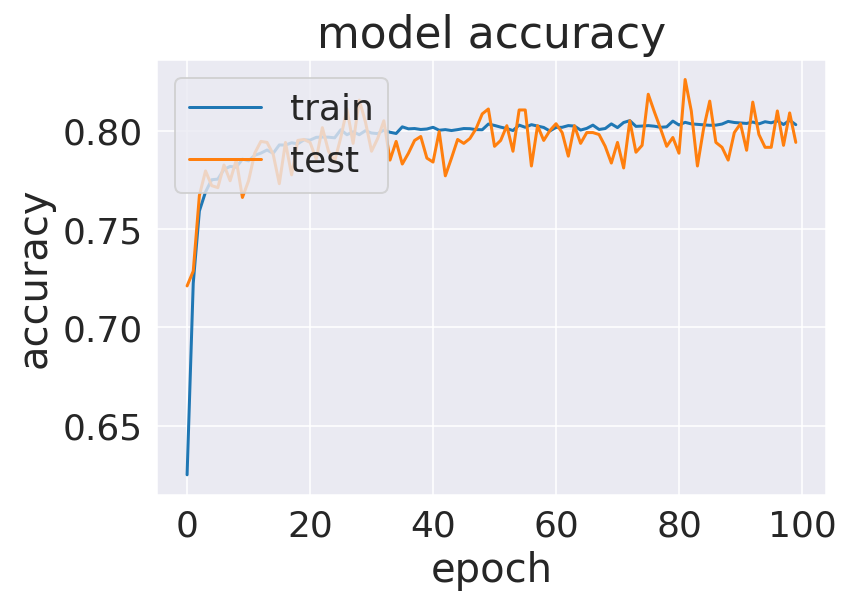

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(61.0, 0.5, 'True')

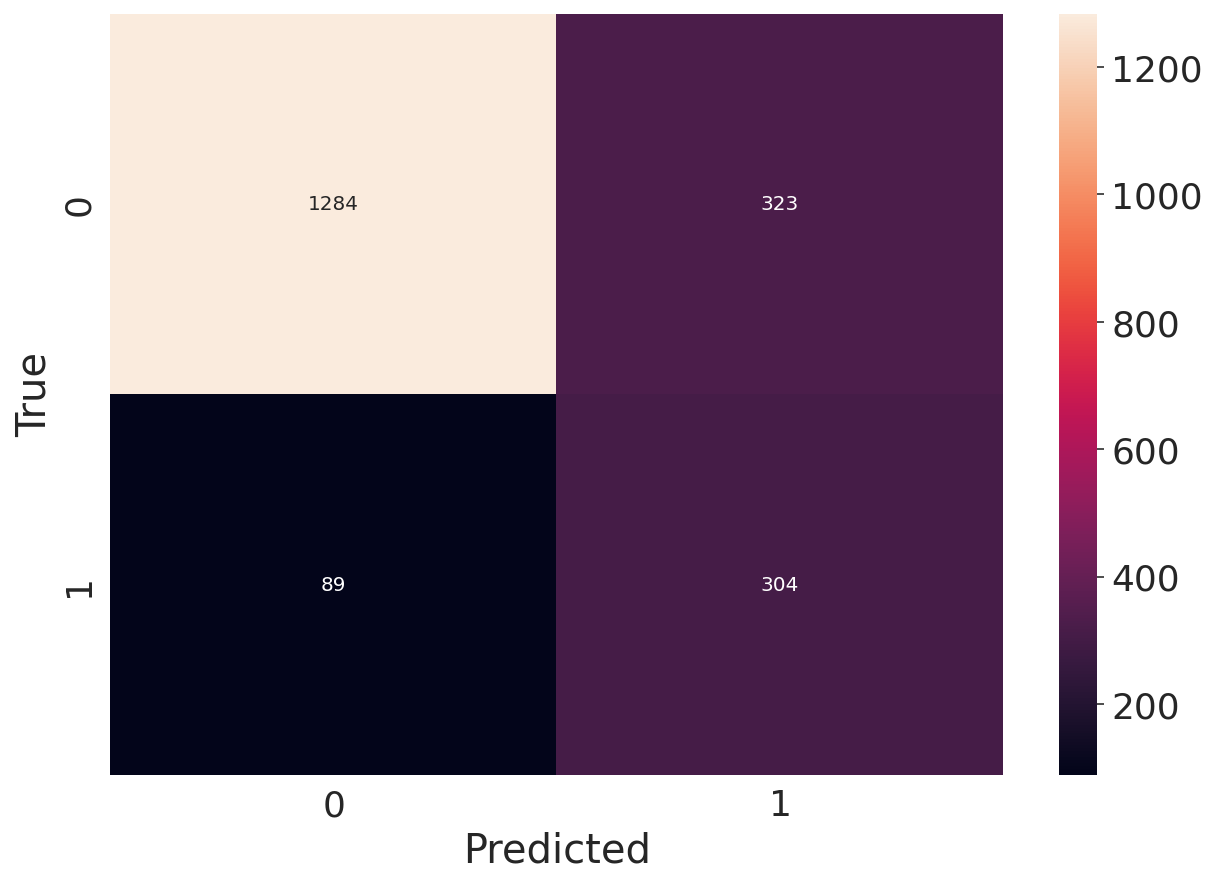

In [ ]:
import tensorflow as tf
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")

ROC curve

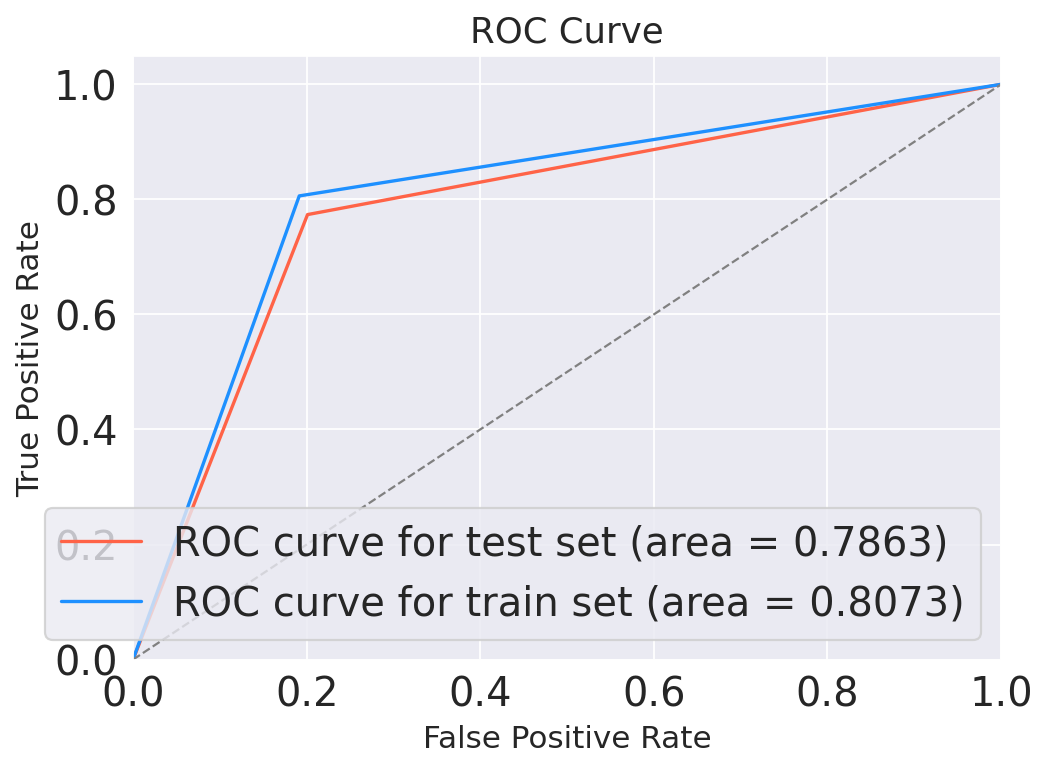

In [ ]:
# Get predictions
train_set_preds = [round(x[0]) for x in model.predict(X_train)]
test_set_preds = [round(x[0]) for x in model.predict(X_test)]

# Get AUC and ROC
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_set_preds)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_set_preds)
train_roc_auc = auc(train_fpr, train_tpr)
test_roc_auc = auc(test_fpr, test_tpr)

# Visualize ROC curve
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(test_fpr,
         test_tpr,
         color='tomato',
         label='ROC curve for test set (area = %0.4f)' % test_roc_auc)
plt.plot(train_fpr,
         train_tpr,
         color='dodgerblue',
         label='ROC curve for train set (area = %0.4f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc="lower right")

plt.show()

## Model Tuning

We are now ready to start building machine learning models. The four classifiers I have selected are the following:

1) Logistic Regression, <br>
2) Random Forest Classifier, <br>
3) Xtreme Gradient Boosting Classifier, <br>
4) Support Vector Classifier. <br>
<br>

Using default hyperparameters usually results in non-optimised models that overfit or underfit the dataset. **Hyperparameter tuning** is the process of finding the set of hyperparameter values that achieves optimal performance. For this purpose, we will first define which hyperparameters we want to experiment with and what values to try out. We will pass this information to Scikit-Learn’s `GridSearchCV`, which then evaluates all the possible combinations of hyperparameter values. We will use recall as the scoring metric for optimising our models. Note that `GridSearchCV` evaluates performance by performing k-fold cross-validation (therefore, a number of folds, `cv`, needs to be provided).

Apart from a confusion matrix, a plot of the learning curves will be provided for each classifier. Learning curves are plots of a model's performance on the training set and the validation set as a function of the training set size. They can help us visualise overfitting/underfitting and the effect of the training size on a model's error.

We will define both functions for them below:

In [ ]:
def plot_conf_mx(cm, ax):
    #Plot a confusion matrix in the specified axes object.
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);

In [ ]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    #Plot the learning curves for an estimator in the specified axes object.
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14);

This fucntion is for bringing them both together:

In [ ]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    #Display the overall performance of a classifier with this template.
    #From kaggle
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout();

### Logistic Regression

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 Logistic Regression
-------------------------------
   Best Score (recall): 0.731
   Best Parameters: 
      C: 0.001
      max_iter: 25
      penalty: l1
      solver: liblinear


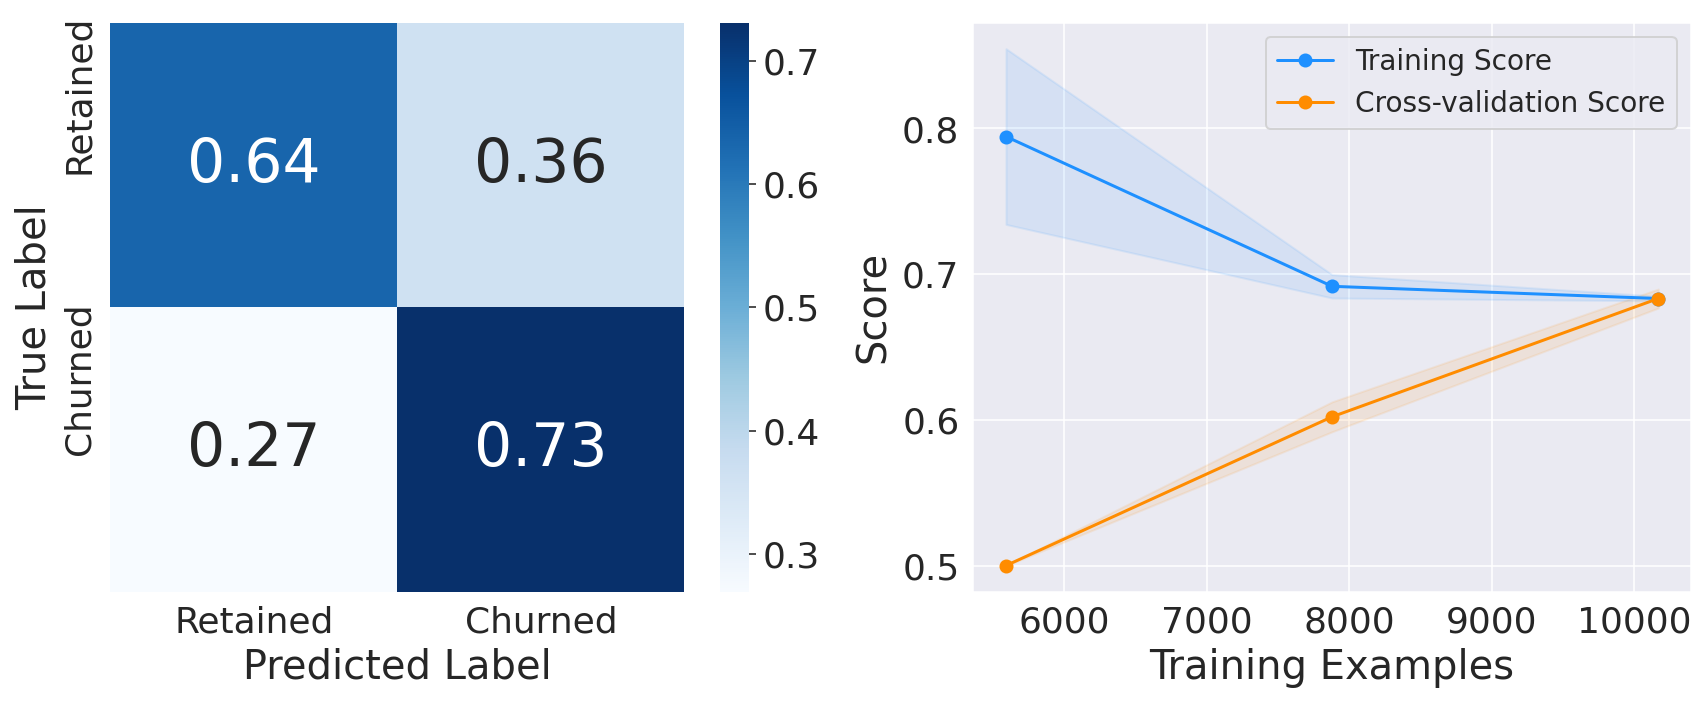

In [ ]:
lr = LogisticRegression(random_state=random_state)

param_grid = [{'max_iter': [25, 50, 100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear']
},{ 'max_iter': [100, 200],
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga']}]


lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=2,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

### Random Forest

Fitting 5 folds for each of 96 candidates, totalling 480 fits

 Random Forest
-------------------------------
   Best Score (recall): 0.77
   Best Parameters: 
      max_depth: 6
      min_samples_leaf: 2
      min_samples_split: 5
      n_estimators: 50


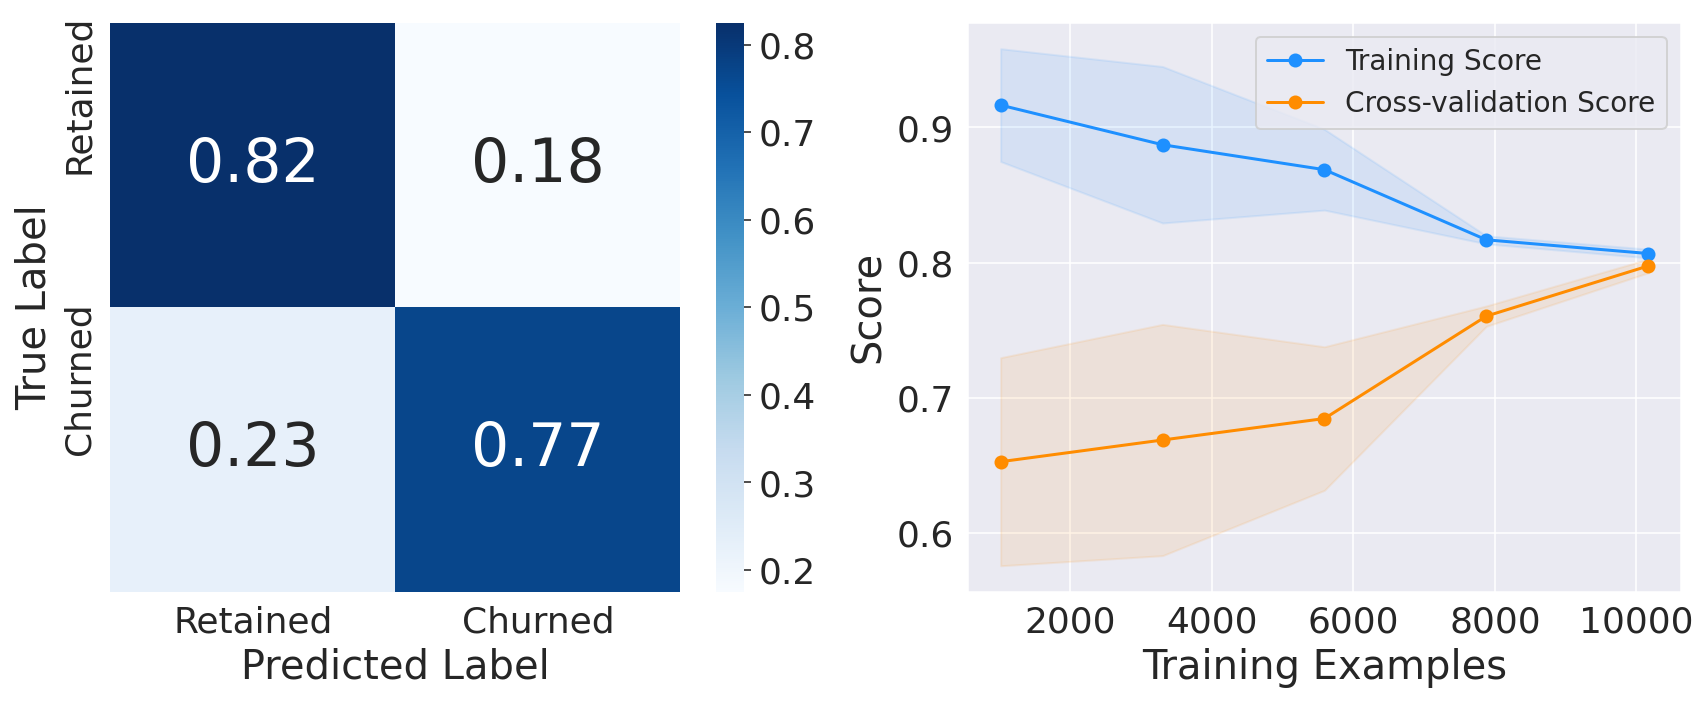

In [ ]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 6],
    'min_samples_leaf': [2, 3, 5, 7],
    'min_samples_split': [2, 3, 5, 7]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=2,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

### XGBoost Classifier

Fitting 5 folds for each of 36 candidates, totalling 180 fits

 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.79
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 0.1
      learning_rate: 0.01
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 1


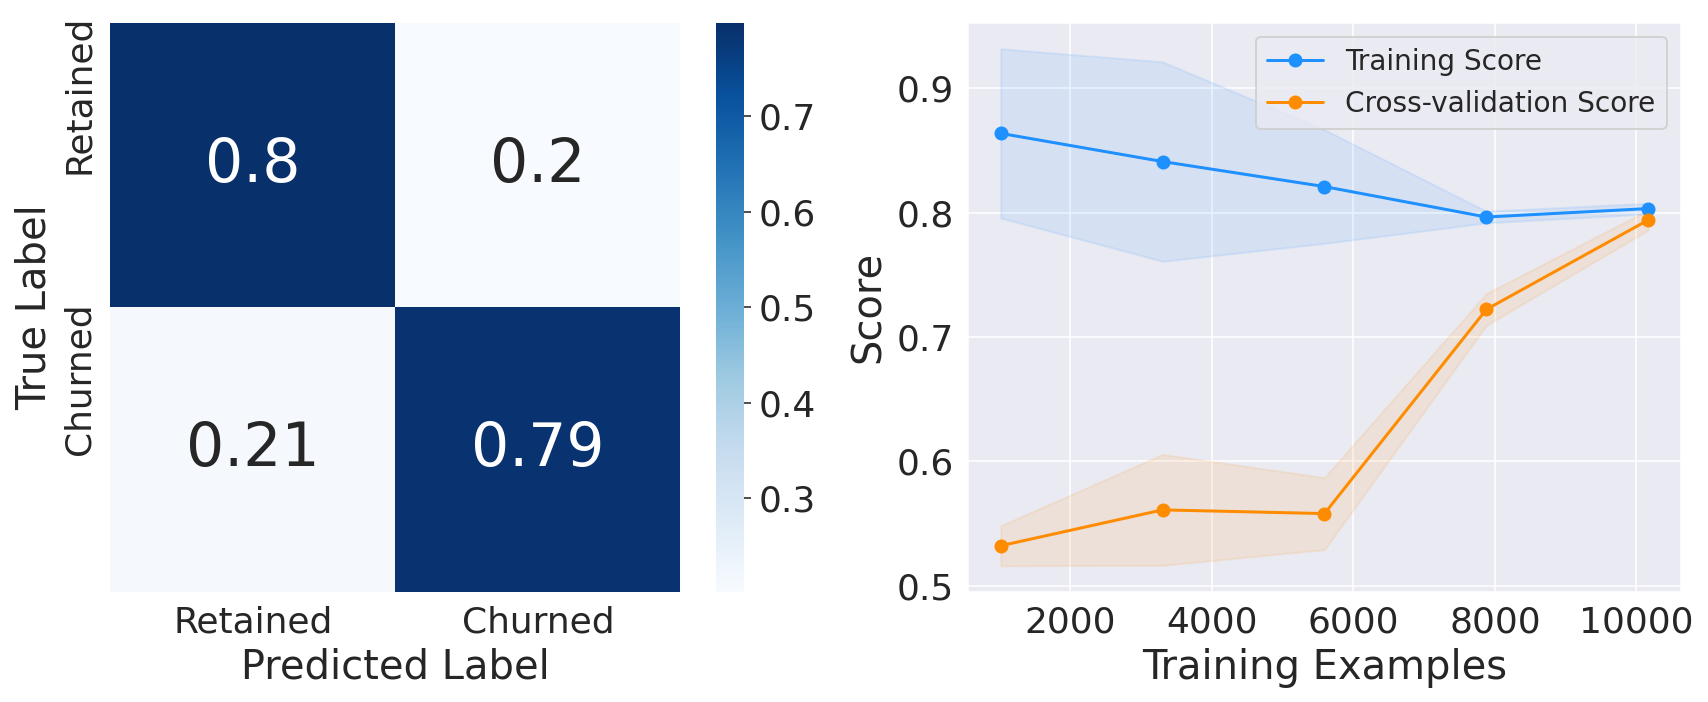

In [ ]:
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'colsample_bytree': [0.5, 1],
    'max_depth': [4],
    'reg_alpha': [1],
    'reg_lambda': [1],
    'subsample': [0.5, 0.75, 1],
    'gamma': [0.1, 0.3, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=2,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')

### Support Vector Classifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.78
   Best Parameters: 
      C: 2
      kernel: rbf


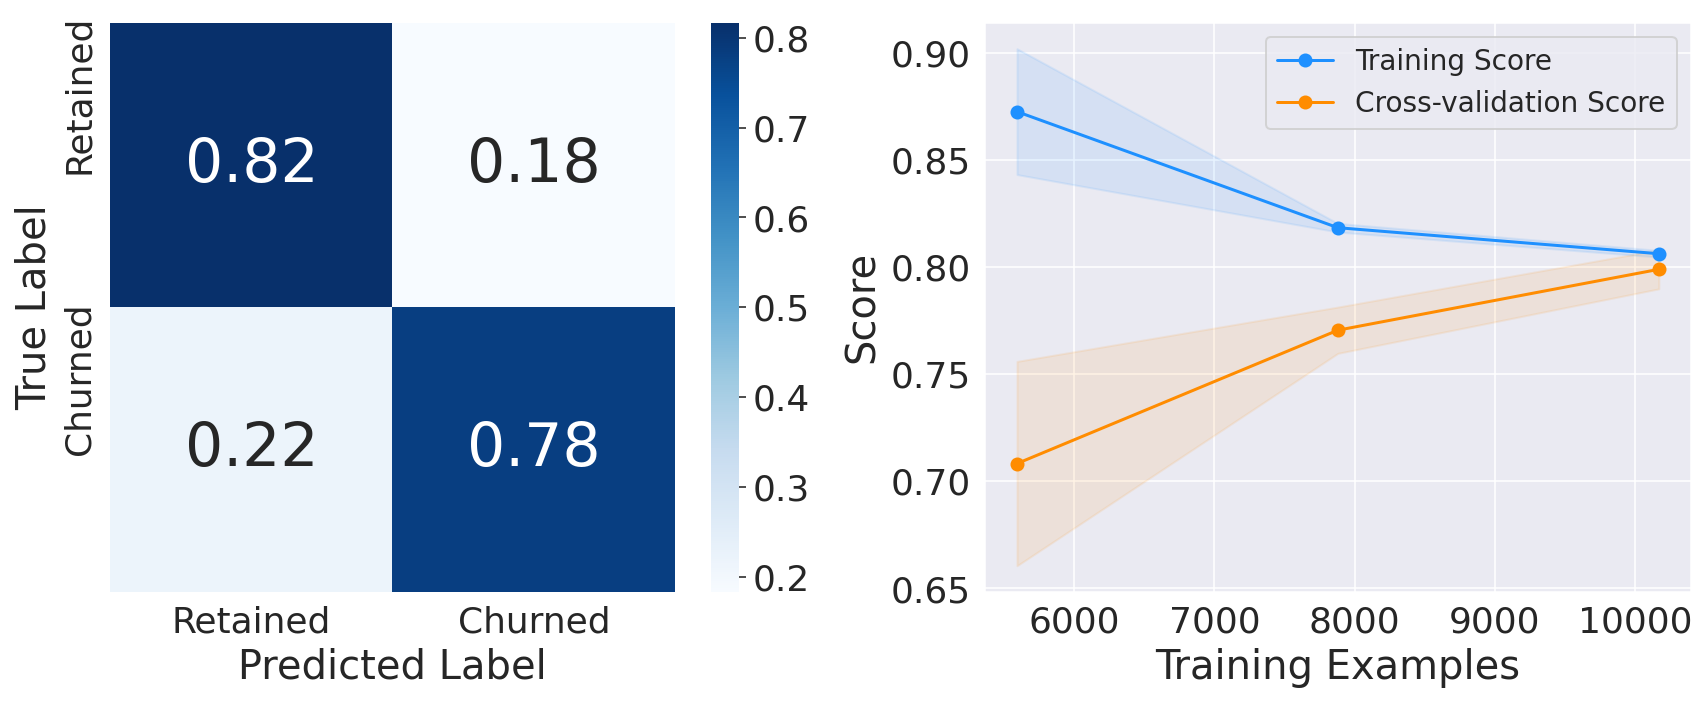

In [ ]:
svc = SVC(probability=True, random_state=random_state)

param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                  'C': [.1, 1, 2]},
                                 {'kernel': ['poly'],
                                  'degree': [2, 3],
                                  'C': [.1, 1, 2]}
                                ]

svc_clf = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=2,
                       n_jobs=-1)

best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')

##Enasemble Learning

Soft Voting
-----------------
  Recall:  0.781


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


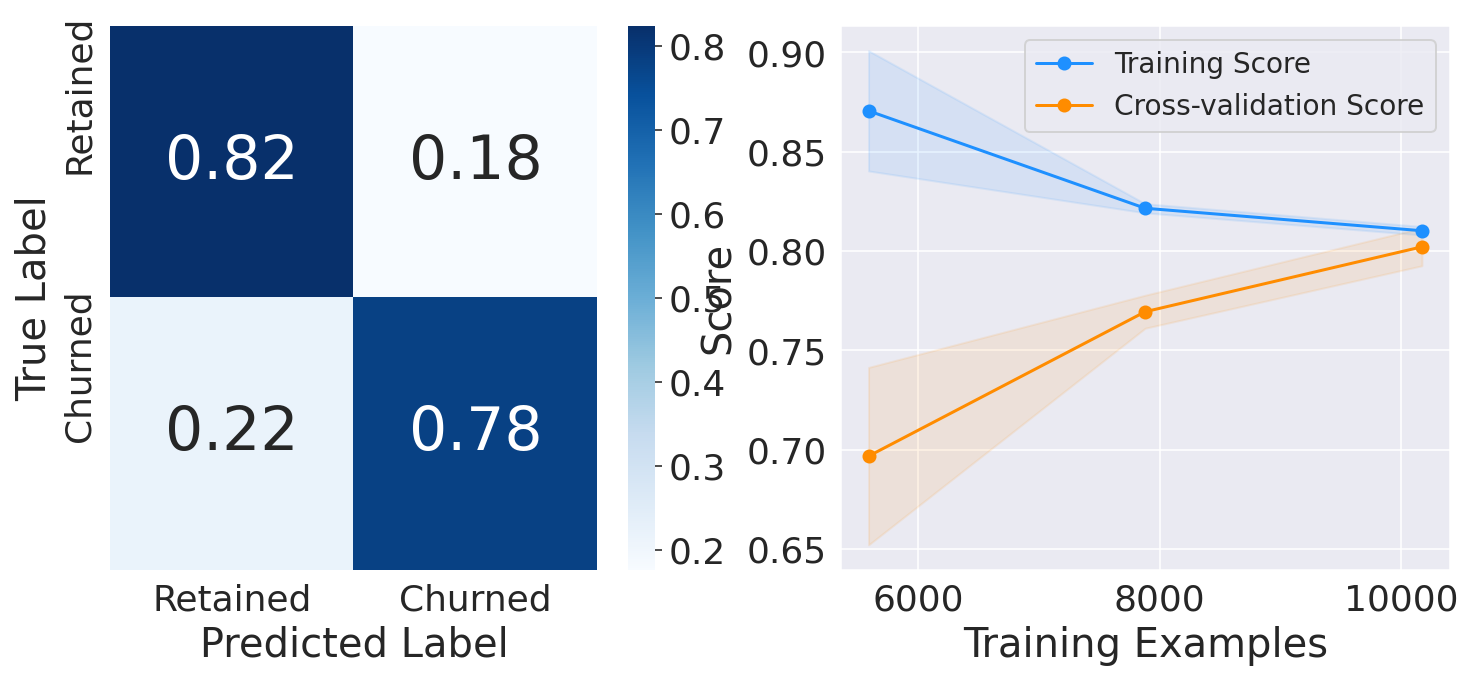

In [ ]:
from sklearn.ensemble import VotingClassifier
estimators = [('LR', best_lr_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(y_train, y_pred),
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr
]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

# Results

## Learning Curves

For all models, there is a tiny gap between the two curves at the end of training. This observation indicates that we do **not** overfit the training set.

## Feature Importance

Some classifiers allow us to visualise feature importance:

In [ ]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');

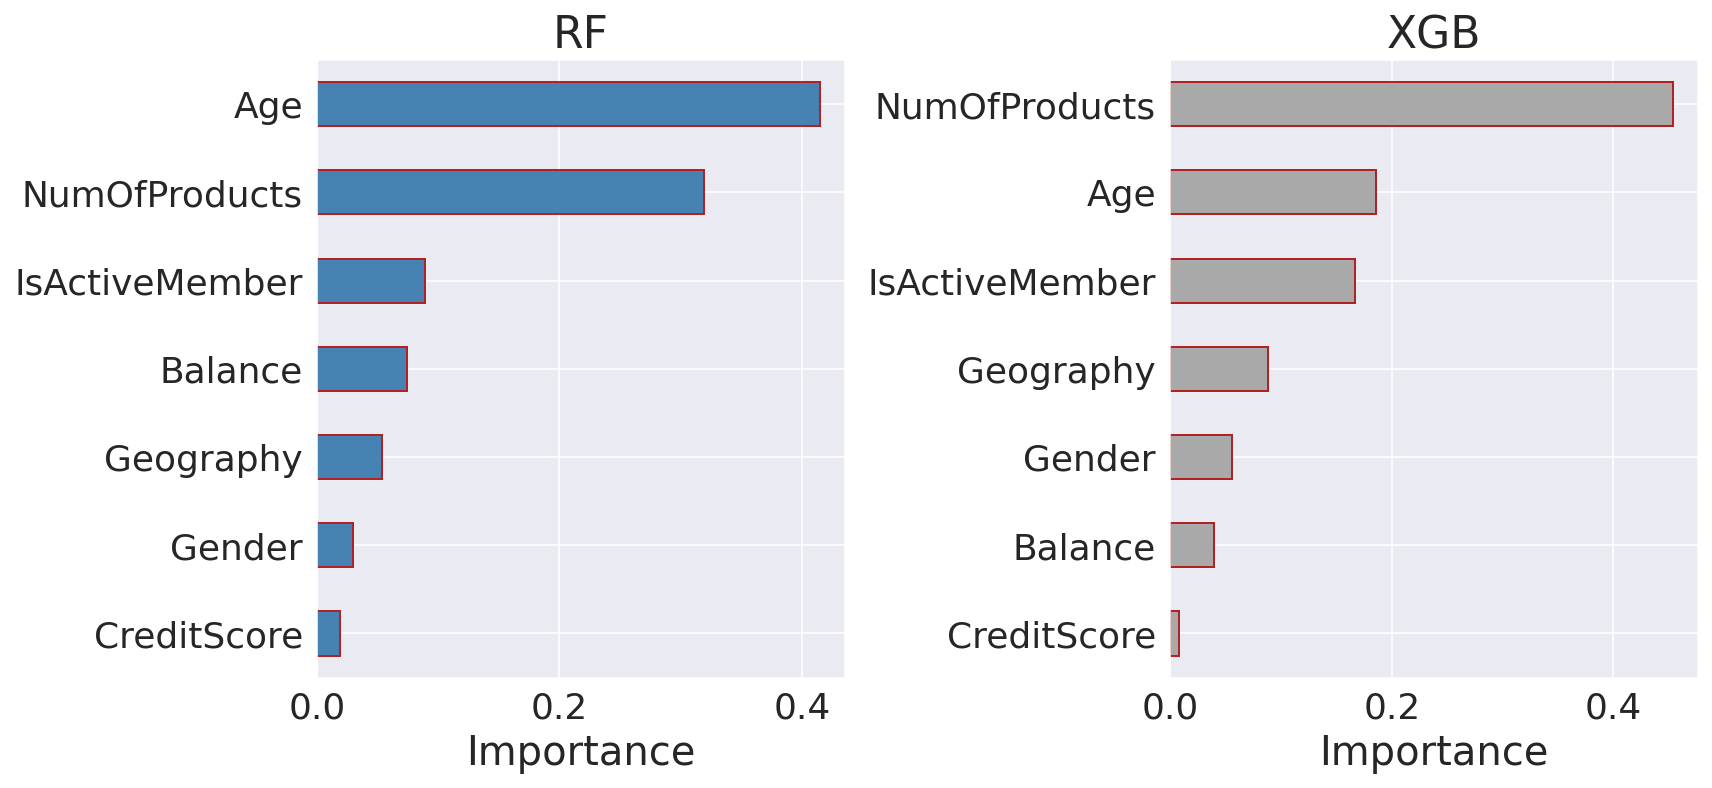

In [ ]:
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(1, 1, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['RF', 'XGB'],
                                    [best_rf_clf, best_xgb_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

'Age' and 'NumOfProducts' seem like the most useful features for all classifiers, followed by 'IsActiveMember' and 'Balance'. On the other hand, 'CreditScore' is the least important feature with a small value close to zero for all estimators.

## Performance Comparison

Initially, we can compare the performance of our classifiers in terms of four individual metrics (Accuracy, precision, recall):

In [ ]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

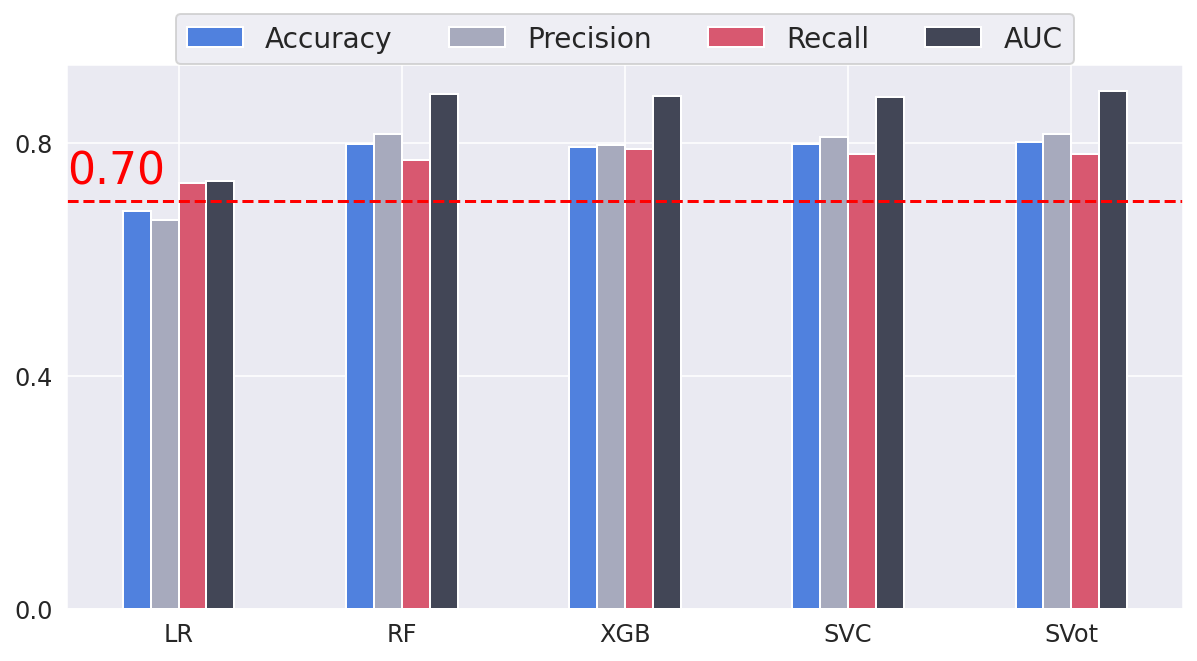

In [ ]:
comparison_df.plot(kind='bar',
                   figsize=(10, 5),
                   fontsize=12,
                   color=['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc='upper center',
           fontsize=font_size - 6,
           ncol=len(comparison_df.columns),
           bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', size=font_size + 2, color='red');

All other classifiers have a recall higher than 70% (baseline performance). XGB is the model with the highest recall (78.5 %). RF, XGB and SVC have very close results to each other. Though RF has the best precision and AUC.

ROC Curve

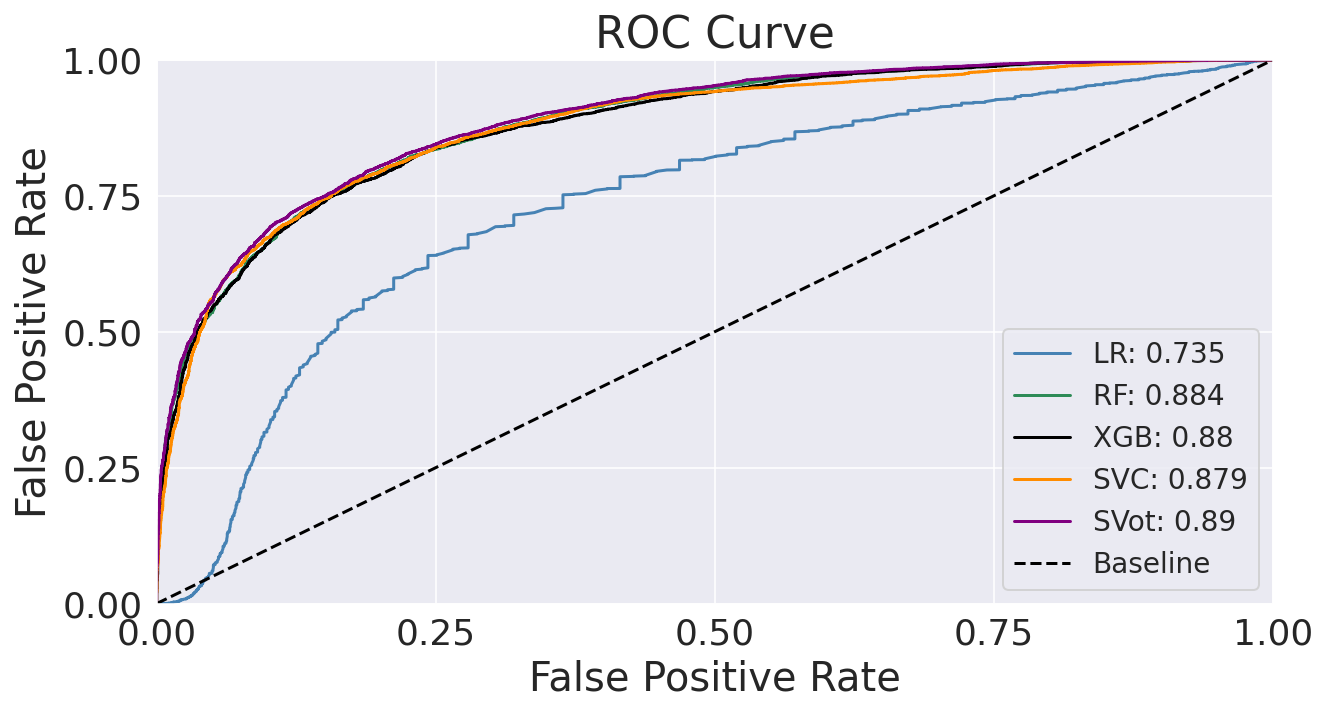

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            color=colors_comp[index],
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('False Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);

Cumulative Gains Curve

Soft Voting:


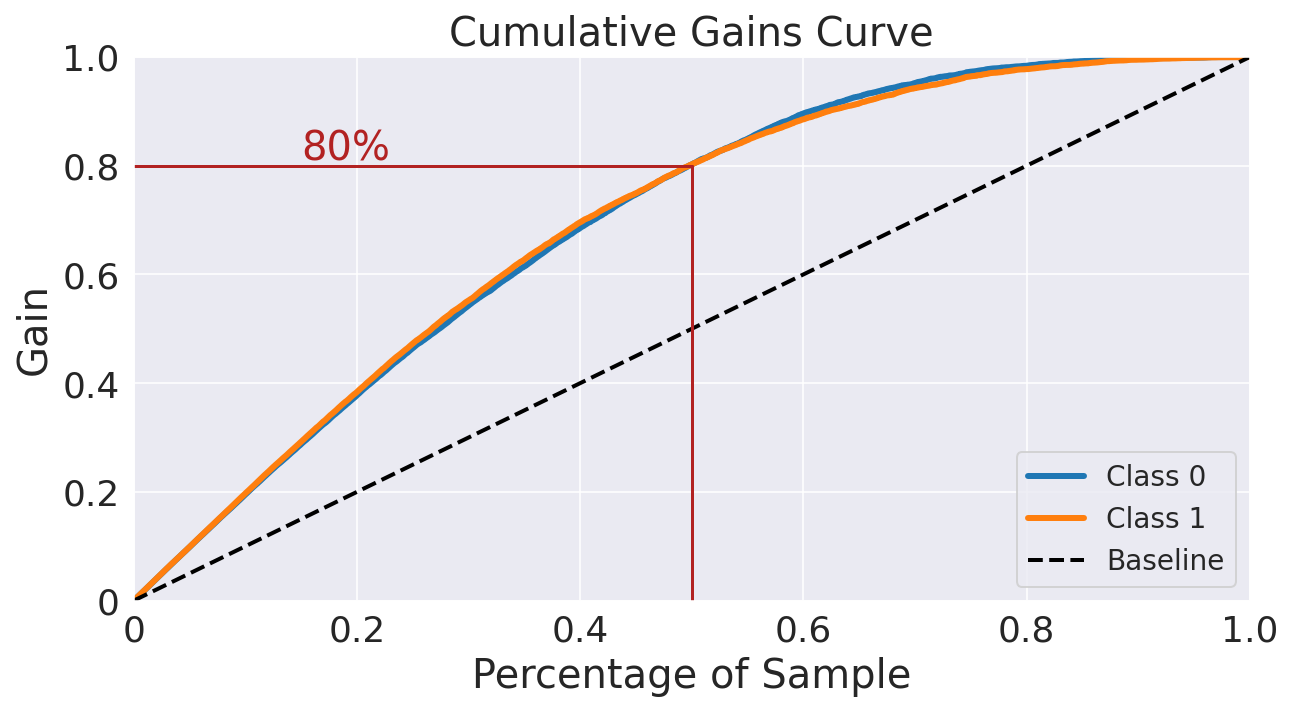

In [ ]:
print('Soft Voting:')

y_pred = cross_val_predict(tuned_voting_soft,
                           X_train,
                           y_train,
                           cv=5,
                           method='predict_proba')

fig, ax = plt.subplots(figsize=(10, 5))

skplt.metrics.plot_cumulative_gain(y_train, y_pred, ax=ax)

ax.plot([0.5, 0.5], [0, 0.8], color='firebrick')
ax.plot([0.0, 0.5], [0.8, 0.8], color='firebrick')

ax.set_title('Cumulative Gains Curve', size=font_size)
ax.set_xlabel('Percentage of Sample', size=font_size)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.set_ylabel('Gain', size=font_size)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.text(0.15, 0.81, '80%', size=font_size, color='firebrick')
ax.legend(fontsize=14);

In [ ]:
def test_func(classifier, classifier_name, ax):
    #Assess the performance on the test set and plot the confusion matrix.
    #from kaggle
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues',
                ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned']);

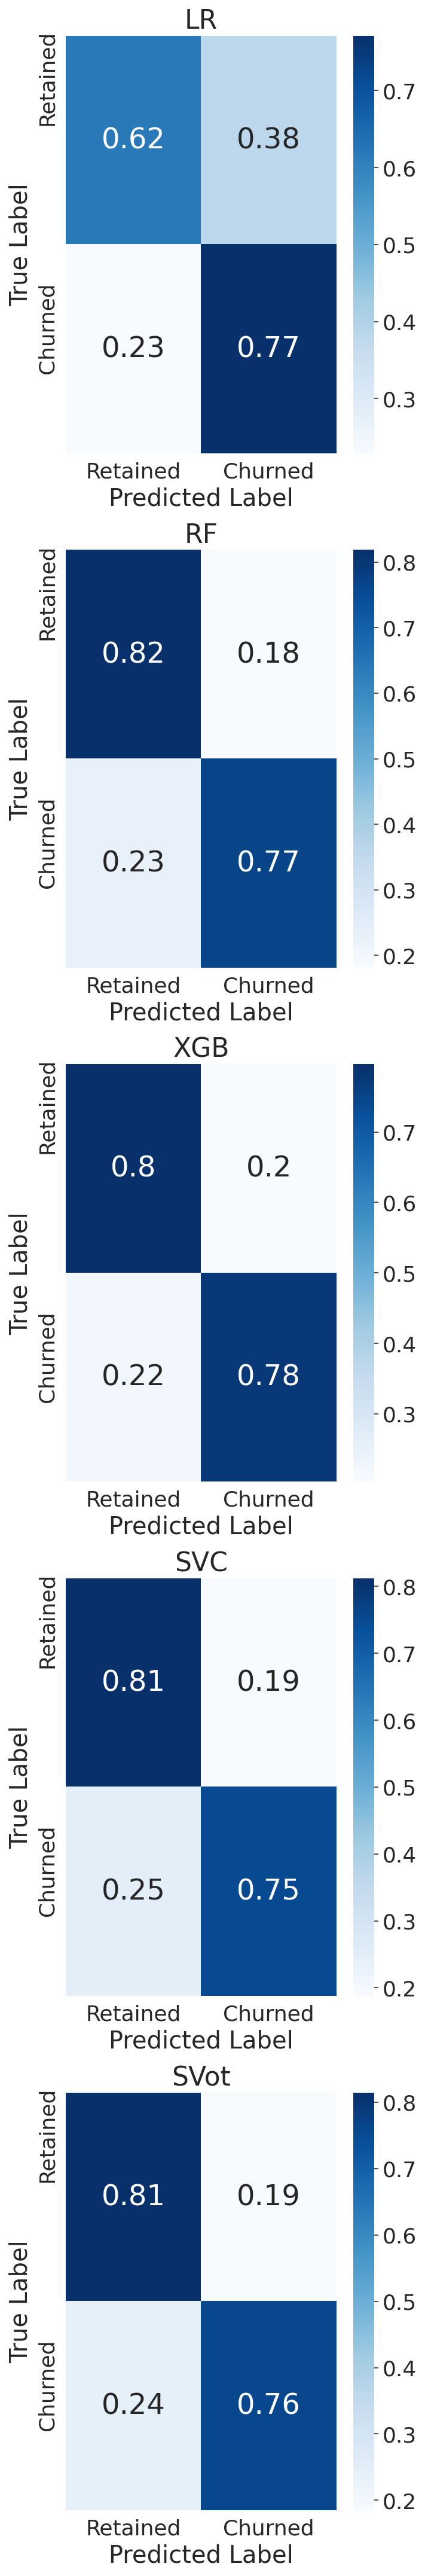

In [ ]:
tuned_voting_soft.fit(X_train, y_train)

fig, ax = plt.subplots(5, 1, figsize=(5, 30))

for i, (name, clf) in enumerate(zip(['LR', 'RF', 'XGB', 'SVC', 'SVot'],
                                    [best_lr_clf.best_estimator_, best_rf_clf.best_estimator_, best_xgb_clf.best_estimator_, best_svc_clf.best_estimator_, tuned_voting_soft])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout();

### **Validation:**

In [ ]:
comparison_test_df = pd.DataFrame(comparison_test_dict,
                                  index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)

Results are fairly high. 77.6% recall for XGB is better than some people from kaggle could get. Rest is 77.1% for Logistic regression and Random forest. SVC and Enasemble were not so great, they are behind the rest bt 2%.

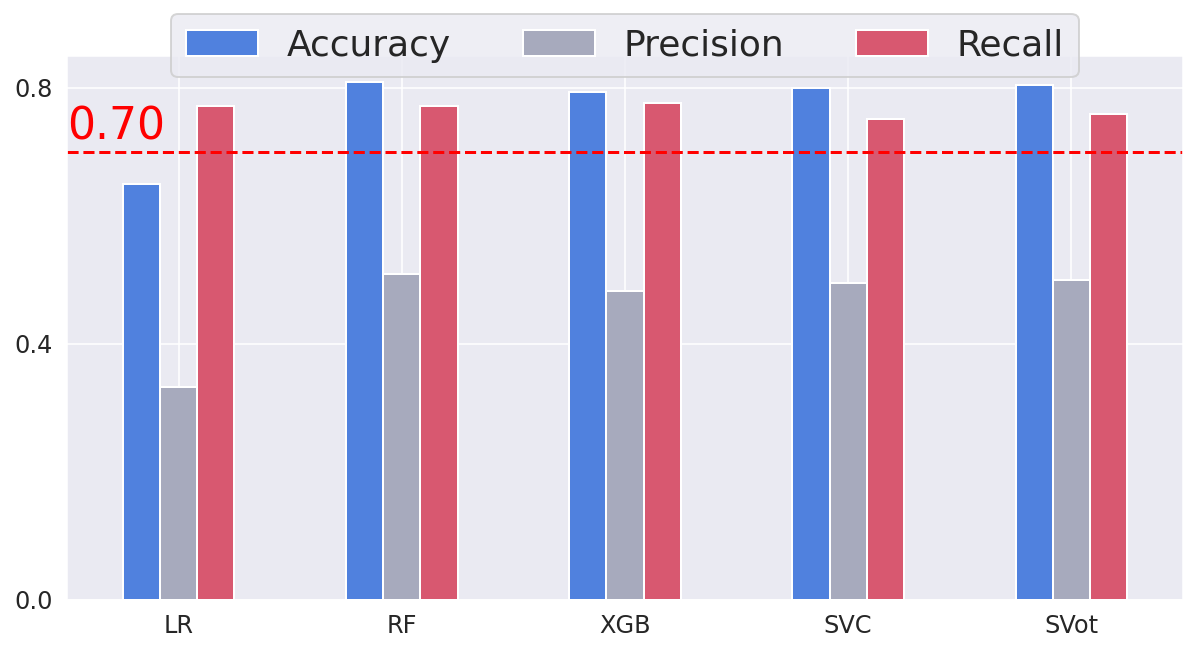

In [ ]:
comparison_test_df.plot(kind='bar',
                        figsize=(10, 5),
                        fontsize=12,
                        color=['#5081DE', '#A7AABD', '#D85870'])

plt.legend(loc='upper center',
           ncol=len(comparison_test_df.columns),
           bbox_to_anchor=(0.5, 1.11))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.72, s='0.70', size=font_size + 2, color='red');

All of the classifier could get 70% Recall, and almost all got also more then 70% accuracy.



---

---



---



# Building Machine Learning Models for train set with overfitting

## Model Tuning with overfitting

We will use the same classifiers but this time i want to see what diffrence will overfiting make:

1) Logistic Regression, <br>
2) Random Forest Classifier, <br>
3) Xtreme Gradient Boosting Classifier, <br>
4) Support Vector Classifier. <br>
<br>

I dont change Neural Network because it was already a little bit overfitting and making it even more is pointless, regarding that results couldn't get much better.

### Logistic Regression

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 Logistic Regression
-------------------------------
   Best Score (recall): 0.731
   Best Parameters: 
      C: 0.001
      max_iter: 25
      penalty: l1
      solver: liblinear


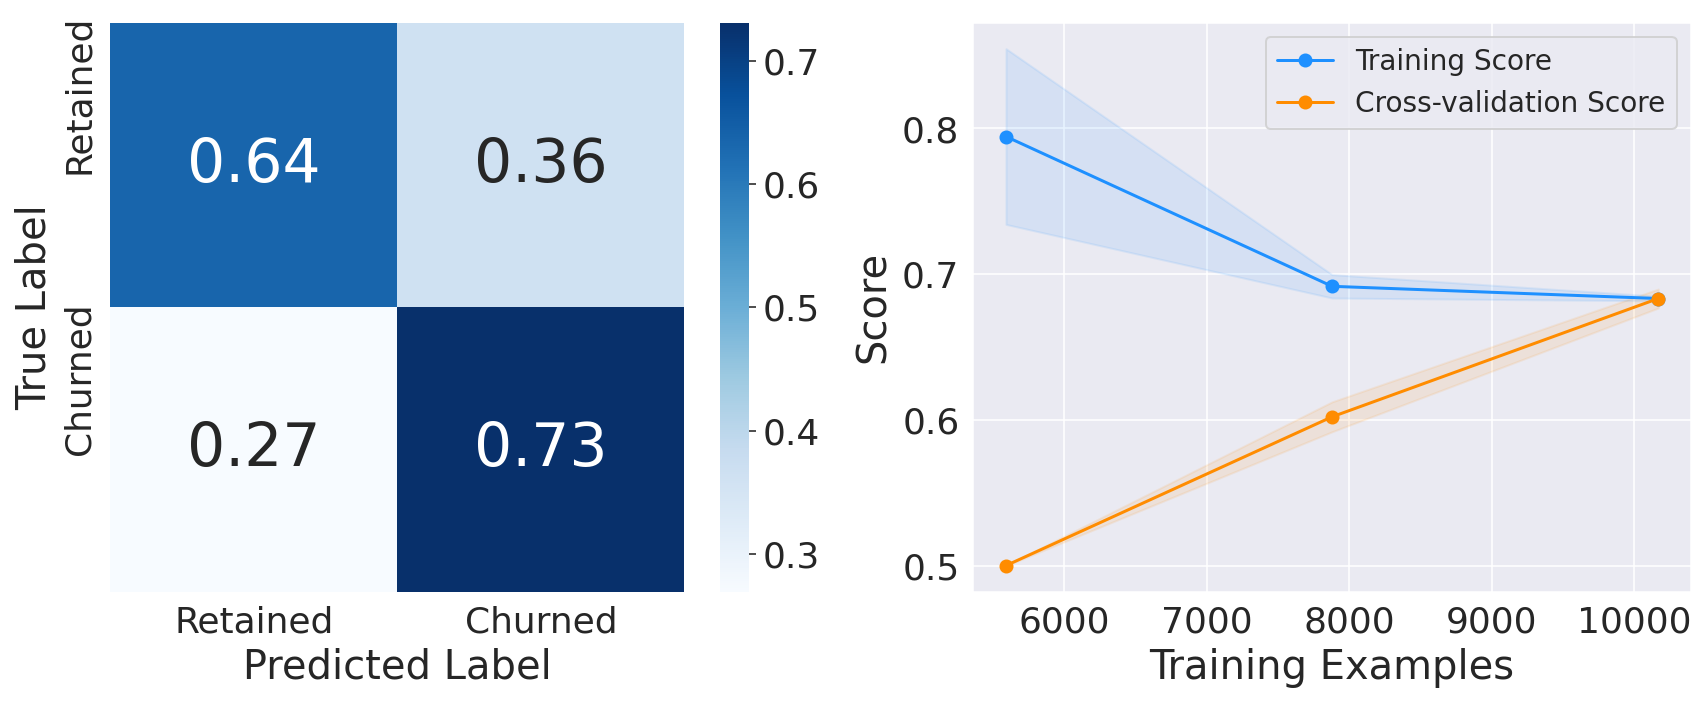

In [ ]:
lr = LogisticRegression(random_state=random_state)

param_grid = {
    'max_iter': [25],
    'penalty': ['l1'],
    'C': [0.001],
    'solver': ['liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=2,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

Couldn't get better results here

### Random Forest

Fitting 10 folds for each of 12 candidates, totalling 120 fits

 Random Forest
-------------------------------
   Best Score (recall): 0.888
   Best Parameters: 
      bootstrap: True
      max_depth: 24
      min_samples_leaf: 1
      min_samples_split: 2
      n_estimators: 205


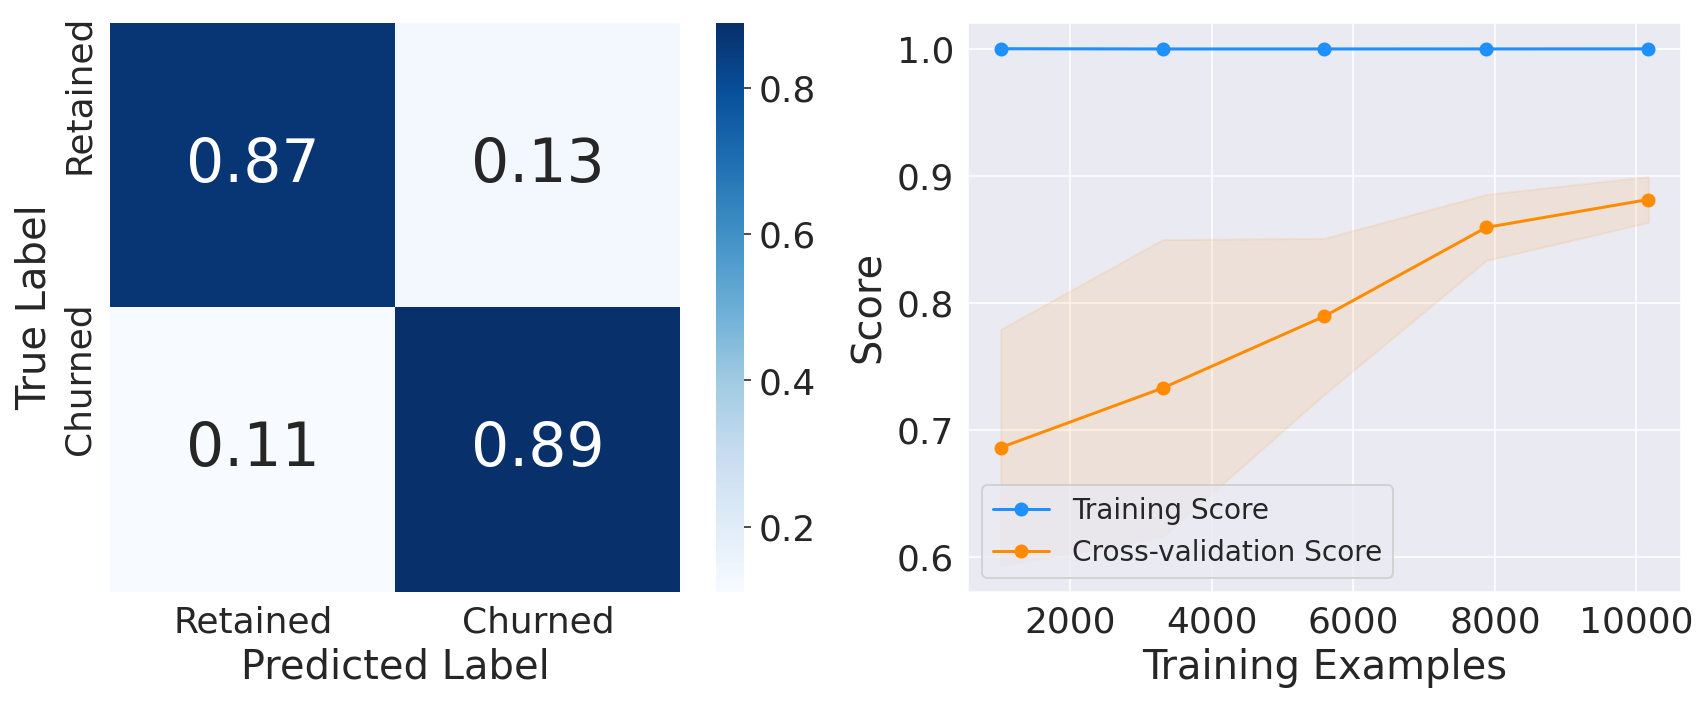

In [ ]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [205],
    'max_depth': [24, 25, 26], #only
    'min_samples_leaf': [1, 2], #only
    'min_samples_split': [2] #only
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=10,
                      verbose=2,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

Here I even tried with more k-folds, to get better results.

### XGBoost Classifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.873
   Best Parameters: 
      learning_rate: 0.3
      max_depth: 10
      min_child_weight: 0
      n_estimators: 102
      reg_alpha: 1
      reg_lambda: 1
      subsample: 1


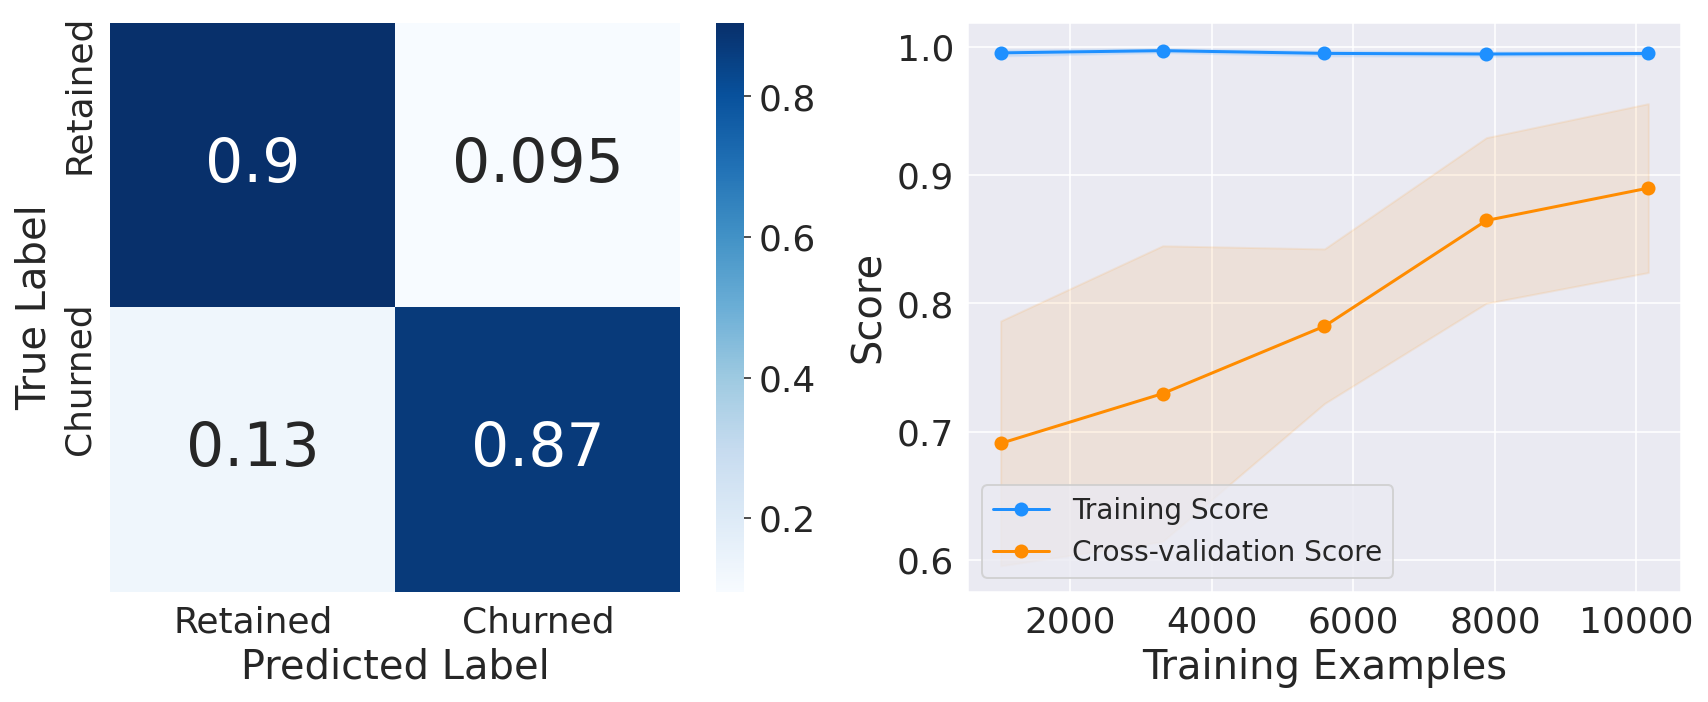

In [ ]:
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [102],
    'learning_rate': [0.3],
    'max_depth': [10],
    'reg_alpha': [1],
    'reg_lambda': [1],
    'subsample': [1],
    'min_child_weight': [0]

}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=2,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')

### Support Vector Classifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.78
   Best Parameters: 
      C: 2
      kernel: rbf


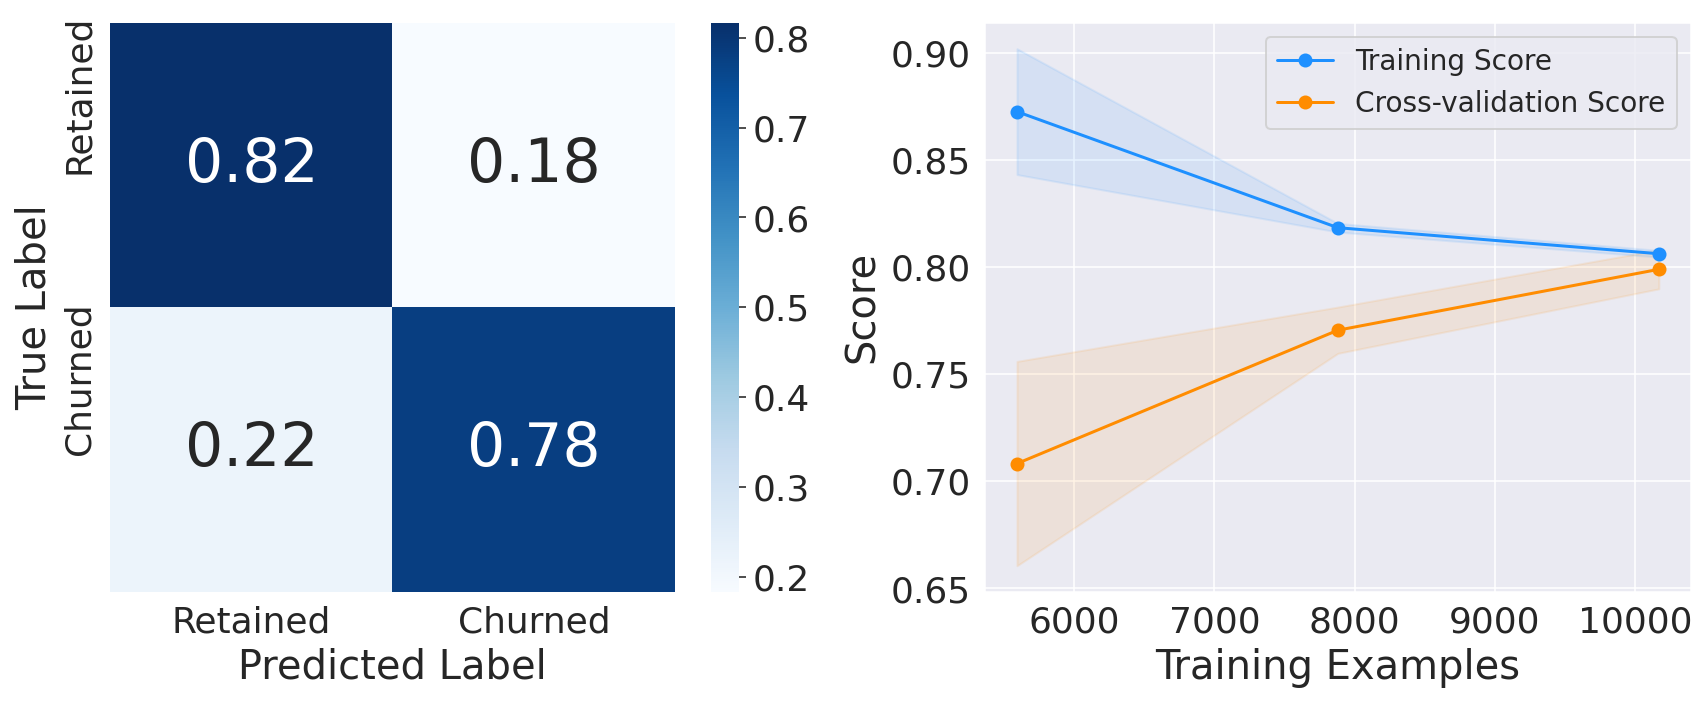

In [ ]:
svc = SVC(probability=True, random_state=random_state)

param_grid = tuned_parameters = {'kernel': ['rbf'],
                                  'C': [2]
                                 }

svc_clf = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=2,
                       n_jobs=-1)

best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')

Here also I couldn't get better results.

##Enasemble Learning

Soft Voting
-----------------
  Recall:  0.879


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


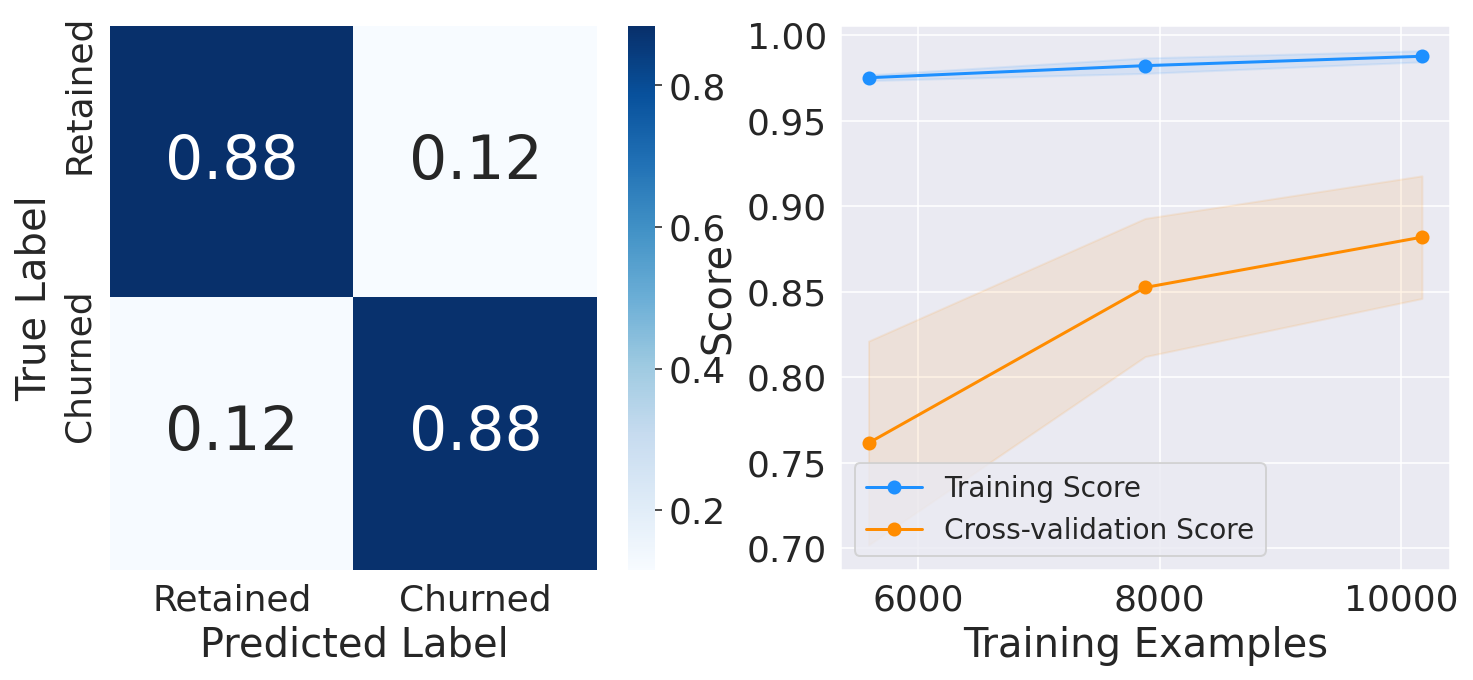

In [ ]:
from sklearn.ensemble import VotingClassifier
estimators = [('LR', best_lr_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(y_train, y_pred),
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr
]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

# Results for overfitting

## Learning Curves & Feature Importance

Some classifiers allow us to visualise feature importance:

In [ ]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');

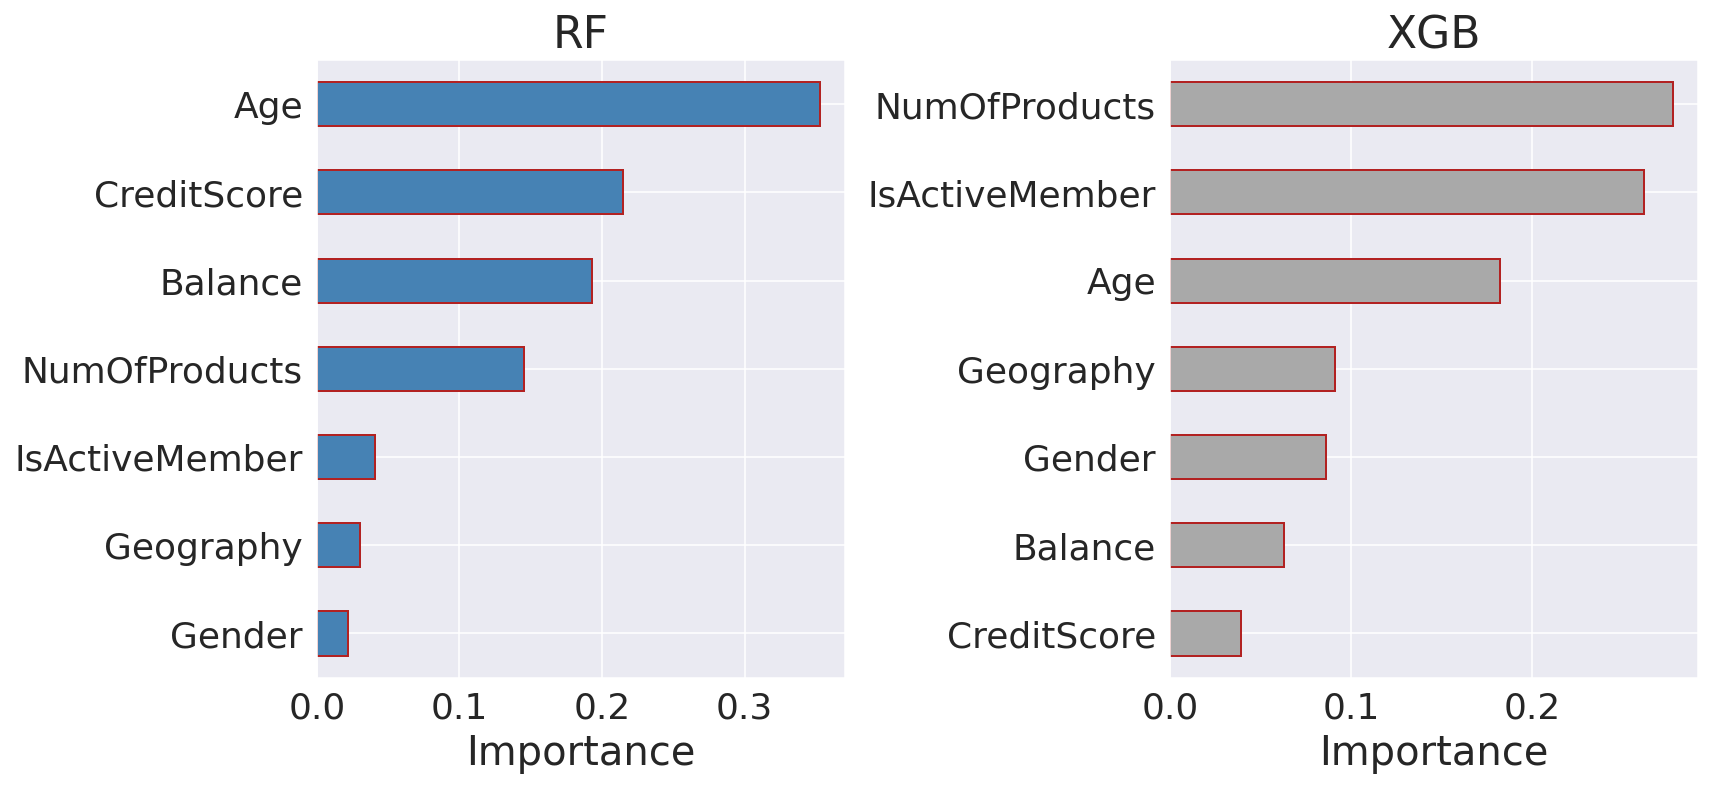

In [ ]:
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(1, 1, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['RF', 'XGB'],
                                    [best_rf_clf, best_xgb_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

Here we can see that classifiers with the biggest change, also had change in importance of features. RF from assigning CreditScore before on the last place , now assigns this feature as the second most important which is suspicious. XGB on the other hand change importance of IsActiveMember and Age between the two.


## Performance Comparison

Initially, we can compare the performance of our classifiers in terms of four individual metrics (Accuracy, precision, recall):

In [ ]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

All classifiers except LR and SVC which couldn't get better results, got much higher all statistics. They are almost perfect with these results
i would say, but we still need to validate those results.

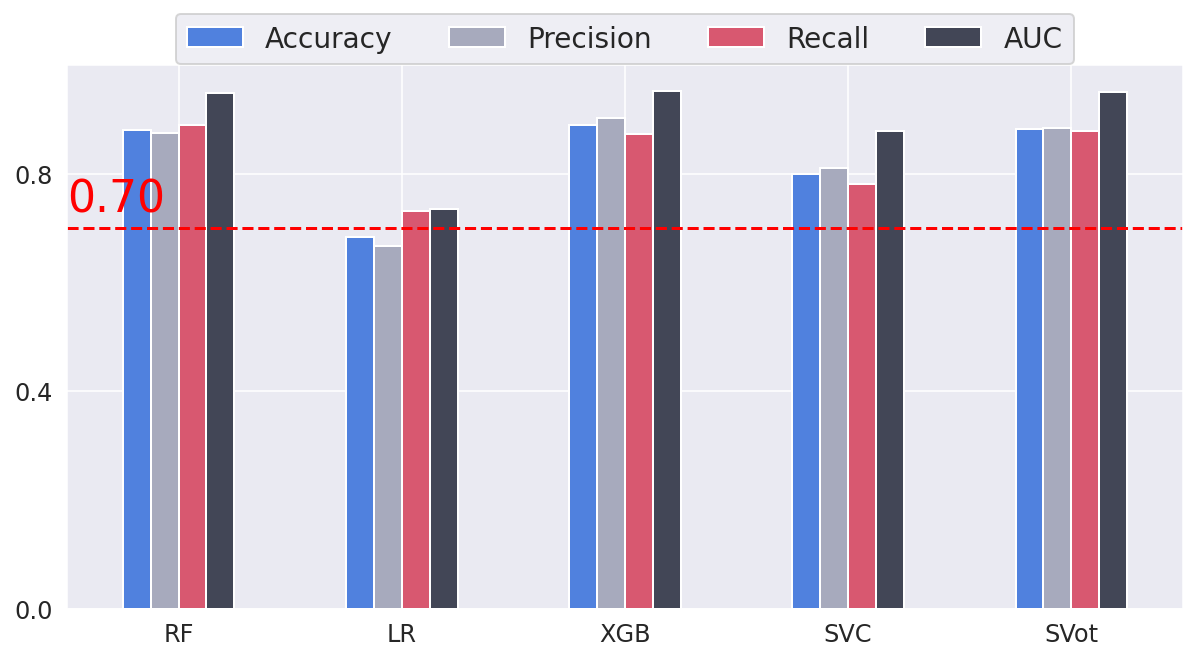

In [ ]:
comparison_df.plot(kind='bar',
                   figsize=(10, 5),
                   fontsize=12,
                   color=['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc='upper center',
           fontsize=font_size - 6,
           ncol=len(comparison_df.columns),
           bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', size=font_size + 2, color='red');

All classifiers have a recall higher than 70%. RF is the model with the highest recall (88.9 %, because i overfitted him the most). RF and XGB have very close results to each other. Though RF got them a little higher.

ROC Curve

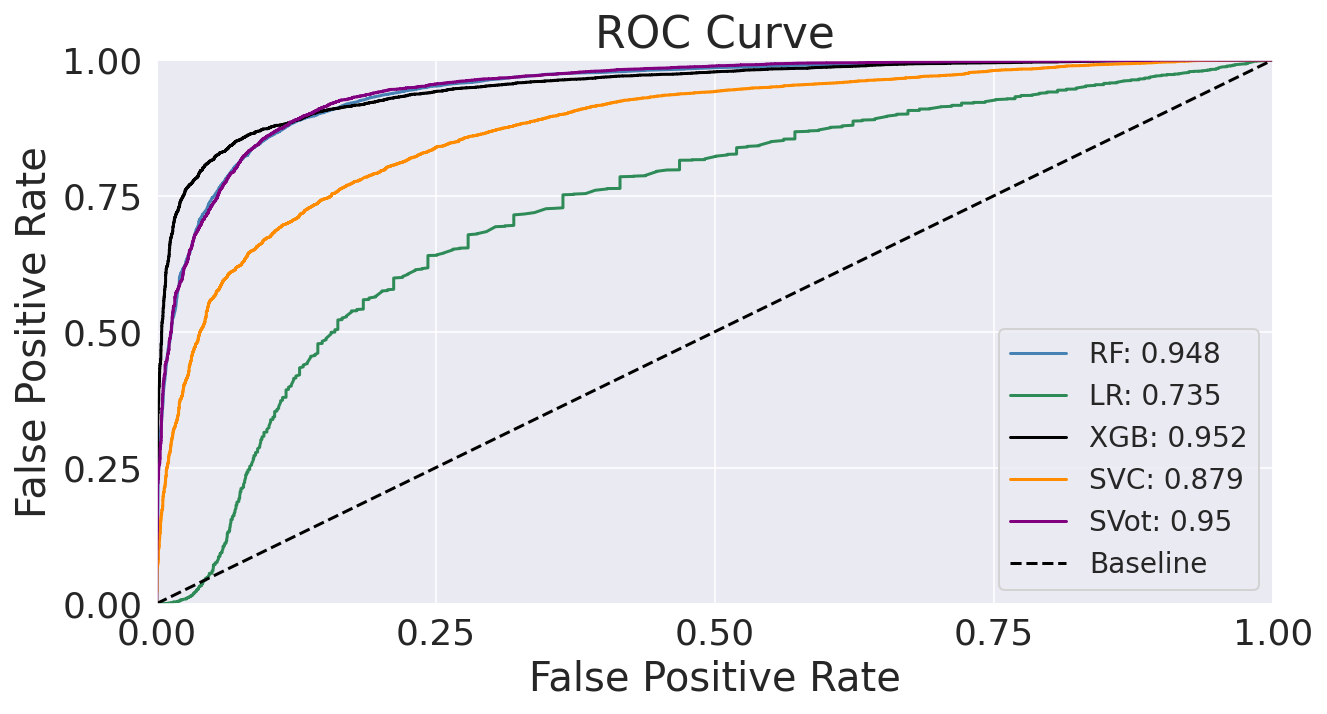

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            color=colors_comp[index],
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('False Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);

Cumulative Gains Curve

Soft Voting:


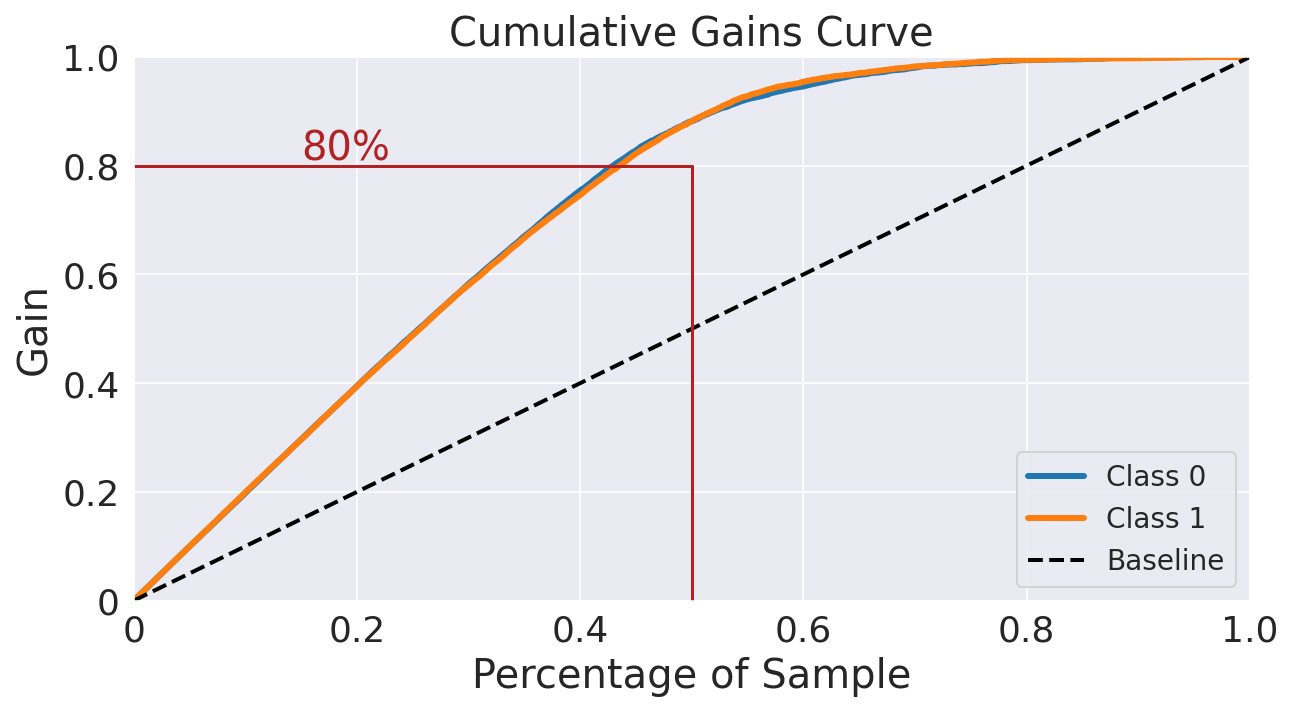

In [ ]:
print('Soft Voting:')

y_pred = cross_val_predict(tuned_voting_soft,
                           X_train,
                           y_train,
                           cv=5,
                           method='predict_proba')

fig, ax = plt.subplots(figsize=(10, 5))

skplt.metrics.plot_cumulative_gain(y_train, y_pred, ax=ax)

ax.plot([0.5, 0.5], [0, 0.8], color='firebrick')
ax.plot([0.0, 0.5], [0.8, 0.8], color='firebrick')

ax.set_title('Cumulative Gains Curve', size=font_size)
ax.set_xlabel('Percentage of Sample', size=font_size)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.set_ylabel('Gain', size=font_size)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.text(0.15, 0.81, '80%', size=font_size, color='firebrick')
ax.legend(fontsize=14);

In [ ]:
def test_func(classifier, classifier_name, ax):
    #Assess the performance on the test set and plot the confusion matrix.
    #from kaggle
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues',
                ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned']);

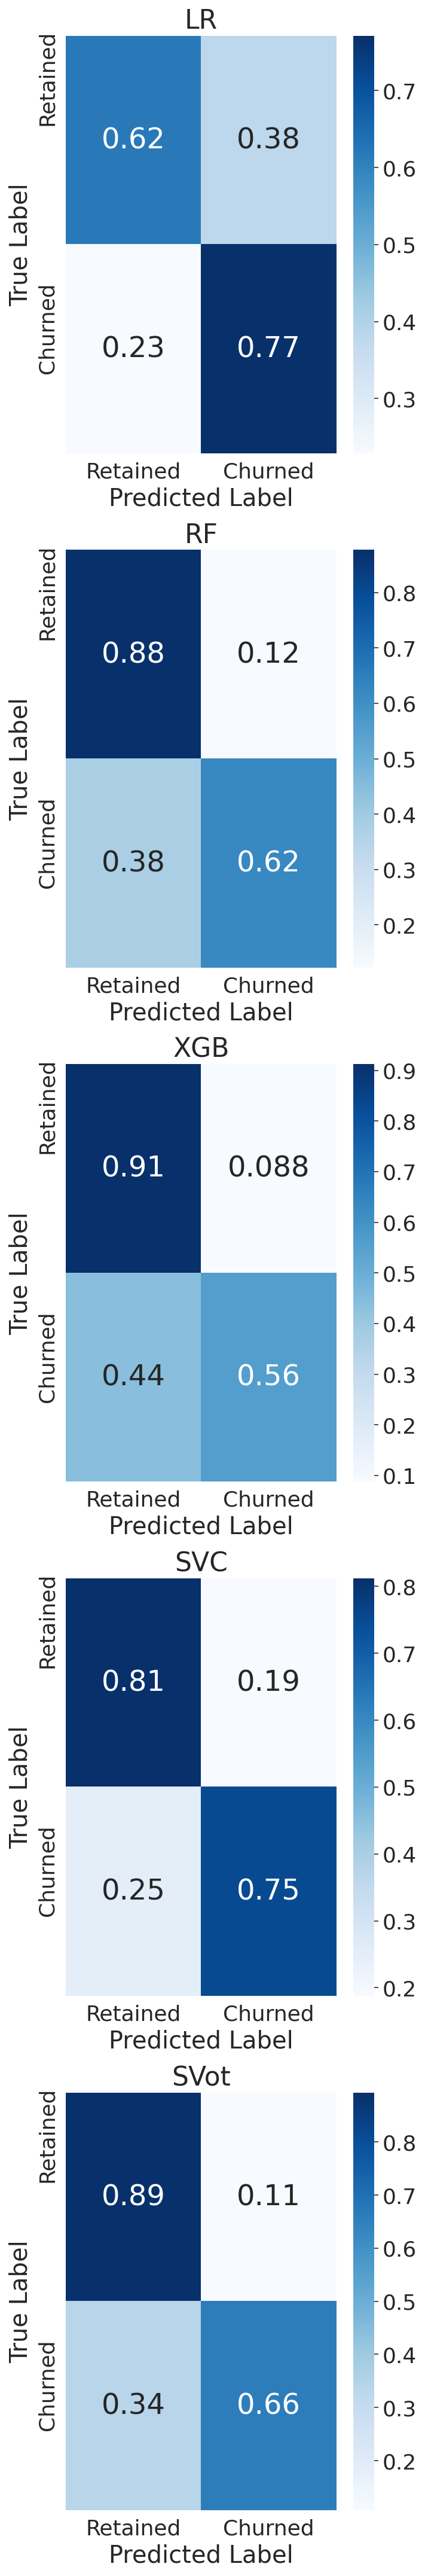

In [ ]:
tuned_voting_soft.fit(X_train, y_train)

fig, ax = plt.subplots(5, 1, figsize=(5, 30))

for i, (name, clf) in enumerate(zip(['LR', 'RF', 'XGB', 'SVC', 'SVot'],
                                    [best_lr_clf.best_estimator_, best_rf_clf.best_estimator_, best_xgb_clf.best_estimator_, best_svc_clf.best_estimator_, tuned_voting_soft])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout();

### **Validation for overfitting:**

In [ ]:
comparison_test_df = pd.DataFrame(comparison_test_dict,
                                  index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)

After overfitting models (the most RF model) happend what i anticipated. Models because of higher overfitting, are even worse on test data then previously. Recall dropped for them drastically by 10 to 20%.

It means that we should be aiming for less overfitting even if it means worse results for train data. A good fit is a fit that end at the sweet spot between underfitting and overfitting. Which is difficult to do.

It is pointless to try the same with XGB as what I did with RF because results would be the same.

Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. The problem is that these concepts do not apply to new data and negatively impact the models ability to generalize.

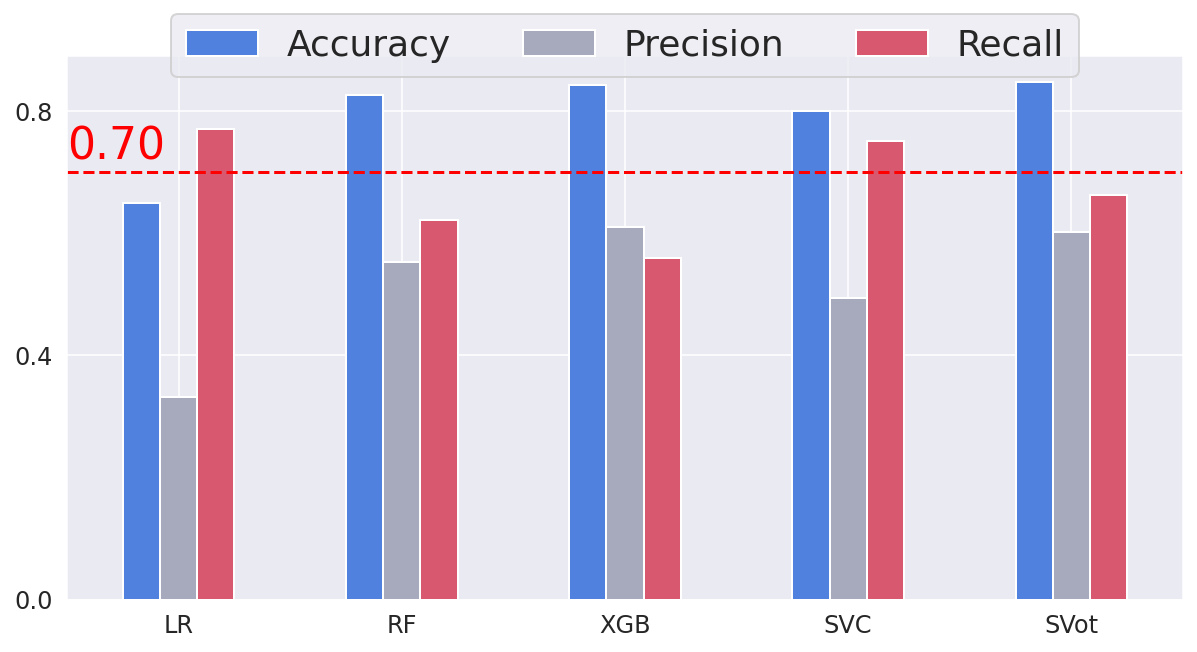

In [ ]:
comparison_test_df.plot(kind='bar',
                        figsize=(10, 5),
                        fontsize=12,
                        color=['#5081DE', '#A7AABD', '#D85870'])

plt.legend(loc='upper center',
           ncol=len(comparison_test_df.columns),
           bbox_to_anchor=(0.5, 1.11))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.72, s='0.70', size=font_size + 2, color='red');

This time except LR and SVC, all models got results of recall below 70% mark.



---

---



---



# Building Machine Learning Models for train set for **Uncut data**

Uncut Data:

In [ ]:
train_df.head()

CreditScore  Geography  Gender    Age  Tenure  Balance  NumOfProducts  \
0        0.356          0       1 -0.656   0.346   -1.218          0.808   
1       -0.204          1       1  0.295  -0.348    0.697          0.808   
2       -0.961          0       1 -1.416  -0.695    0.619         -0.917   
3       -0.941          0       0 -1.131   1.387    0.953         -0.917   
4       -1.397          0       1  1.626   1.387    1.057         -0.917   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1            1.368       0  
1          1               1            1.661       0  
2          1               0           -0.253       1  
3          1               0            0.915       1  
4          0               0           -1.060       1

## Baseline Models

We start this section by first creating two simple models to estimate the **baseline performance** on the training set. Specifically, we will use Gaussian Naive Bayes and Logistic Regression. We will use their default parameters and evaluate their (mean) recall by performing **k-fold cross-validation**. The idea behind k-fold cross-validation is simple: it splits the (training) set into k subsets/folds, trains the models using k-1 folds, and evaluates the model on the remaining one fold. This process is repeated until every fold is tested once.

In [ ]:
clf_list = [('Gaussian Naive Bayes', GaussianNB()),
            ('Logistic Regression', LogisticRegression(random_state=random_state))]

cv_base_mean, cv_std = [], []
for clf in clf_list:

    cv = cross_val_score(estimator=clf[1],
                         X=X_train,
                         y=y_train,
                         scoring=scoring_metric,
                         cv=5,
                         n_jobs=-1)

    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

print('Baseline Models (Recall):')

for i in range(len(clf_list)):
    print('   {}: {}'.format(clf_list[i][0], np.round(cv_base_mean[i], 2)))

Baseline Models (Recall):
   Gaussian Naive Bayes: 0.73
   Logistic Regression: 0.71


Already here we got better results by 2% which is hopeful but worrisome.

##Neural Network for Uncut data

Let's build our own neural network first. I will use Multilayer perceptron model. Number of neurons got adjusted accordingly to more number of features in data.

In [ ]:
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=100)

Epoch 1/100
128/128 [==============================] - 2s 8ms/step - loss: 0.6591 - accuracy: 0.5920 - val_loss: 0.6325 - val_accuracy: 0.6425
Epoch 2/100
128/128 [==============================] - 1s 6ms/step - loss: 0.5469 - accuracy: 0.7258 - val_loss: 0.5196 - val_accuracy: 0.7475
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 0.4755 - accuracy: 0.7689 - val_loss: 0.4853 - val_accuracy: 0.7660
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 0.4517 - accuracy: 0.7811 - val_loss: 0.4736 - val_accuracy: 0.7740
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 0.4411 - accuracy: 0.7863 - val_loss: 0.4641 - val_accuracy: 0.7830
Epoch 6/100
128/128 [==============================] - 1s 5ms/step - loss: 0.4363 - accuracy: 0.7889 - val_loss: 0.4780 - val_accuracy: 0.7710
Epoch 7/100
128/128 [==============================] - 1s 5ms/step - loss: 0.4319 - accuracy: 0.7919 - val_loss: 0.4659 - val_accuracy: 0.7805

In [ ]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.4553 - accuracy: 0.7935


[0.4552916884422302, 0.7935000061988831]

In [ ]:
yp = model.predict(X_test)
y_pred = []
for element in yp:
  if element > 0.5:
      y_pred.append(1)
  else:
      y_pred.append(0)

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.929     0.804     0.862      1607
           1      0.484     0.751     0.588       393

    accuracy                          0.793      2000
   macro avg      0.707     0.777     0.725      2000
weighted avg      0.842     0.793     0.808      2000



Here we can see worse recall results than on cutted data.

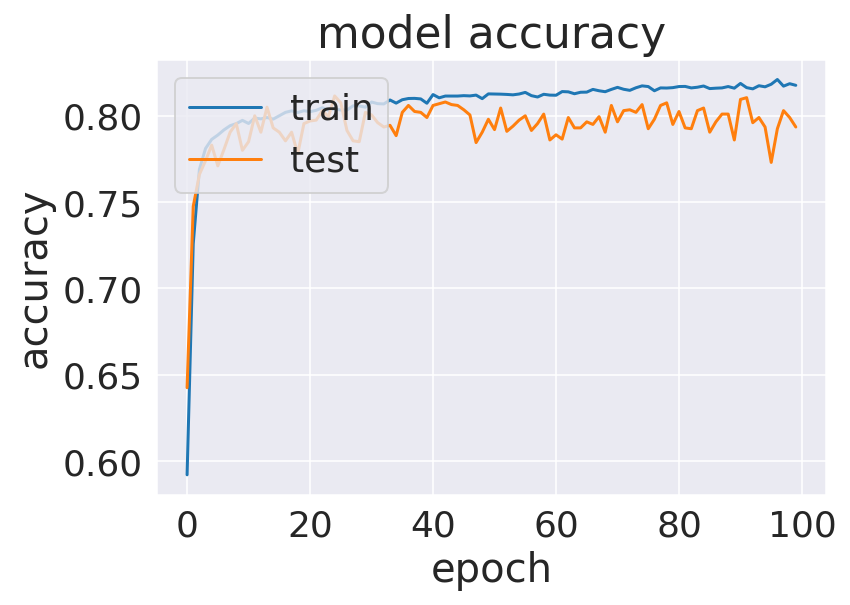

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Also this time we can notice Underfitting.

Text(61.0, 0.5, 'True')

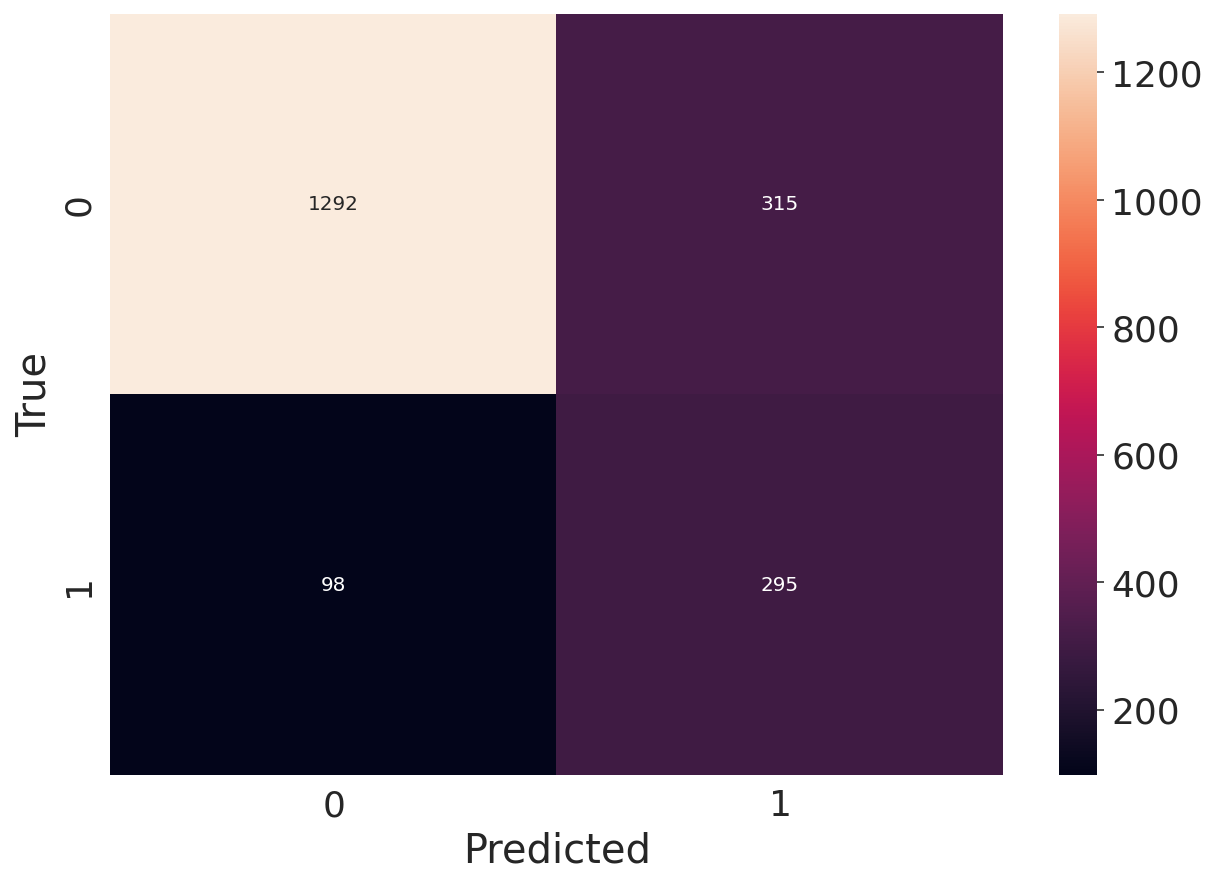

In [ ]:
import tensorflow as tf
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")

ROC curve

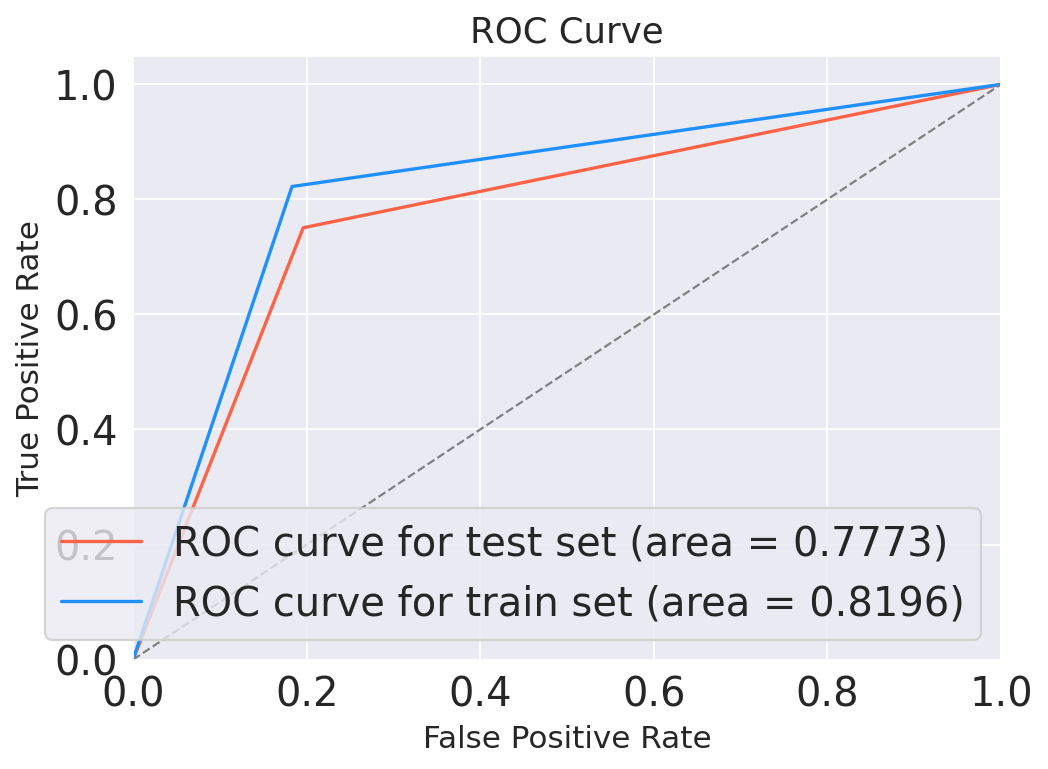

In [ ]:
# Get predictions
train_set_preds = [round(x[0]) for x in model.predict(X_train)]
test_set_preds = [round(x[0]) for x in model.predict(X_test)]

# Get AUC and ROC
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_set_preds)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_set_preds)
train_roc_auc = auc(train_fpr, train_tpr)
test_roc_auc = auc(test_fpr, test_tpr)

# Visualize ROC curve
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(test_fpr,
         test_tpr,
         color='tomato',
         label='ROC curve for test set (area = %0.4f)' % test_roc_auc)
plt.plot(train_fpr,
         train_tpr,
         color='dodgerblue',
         label='ROC curve for train set (area = %0.4f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc="lower right")

plt.show()

It was hard, but with our data we could only get maximum 80% accuracy

## Model Tuning for Uncut data

We use the same classifiers:

1) Logistic Regression, <br>
2) Random Forest Classifier, <br>
3) Xtreme Gradient Boosting Classifier, <br>
4) Support Vector Classifier. <br>

### Logistic Regression

Fitting 5 folds for each of 6 candidates, totalling 30 fits

 Logistic Regression
-------------------------------
   Best Score (recall): 0.734
   Best Parameters: 
      C: 0.001
      max_iter: 25
      penalty: l1
      solver: liblinear


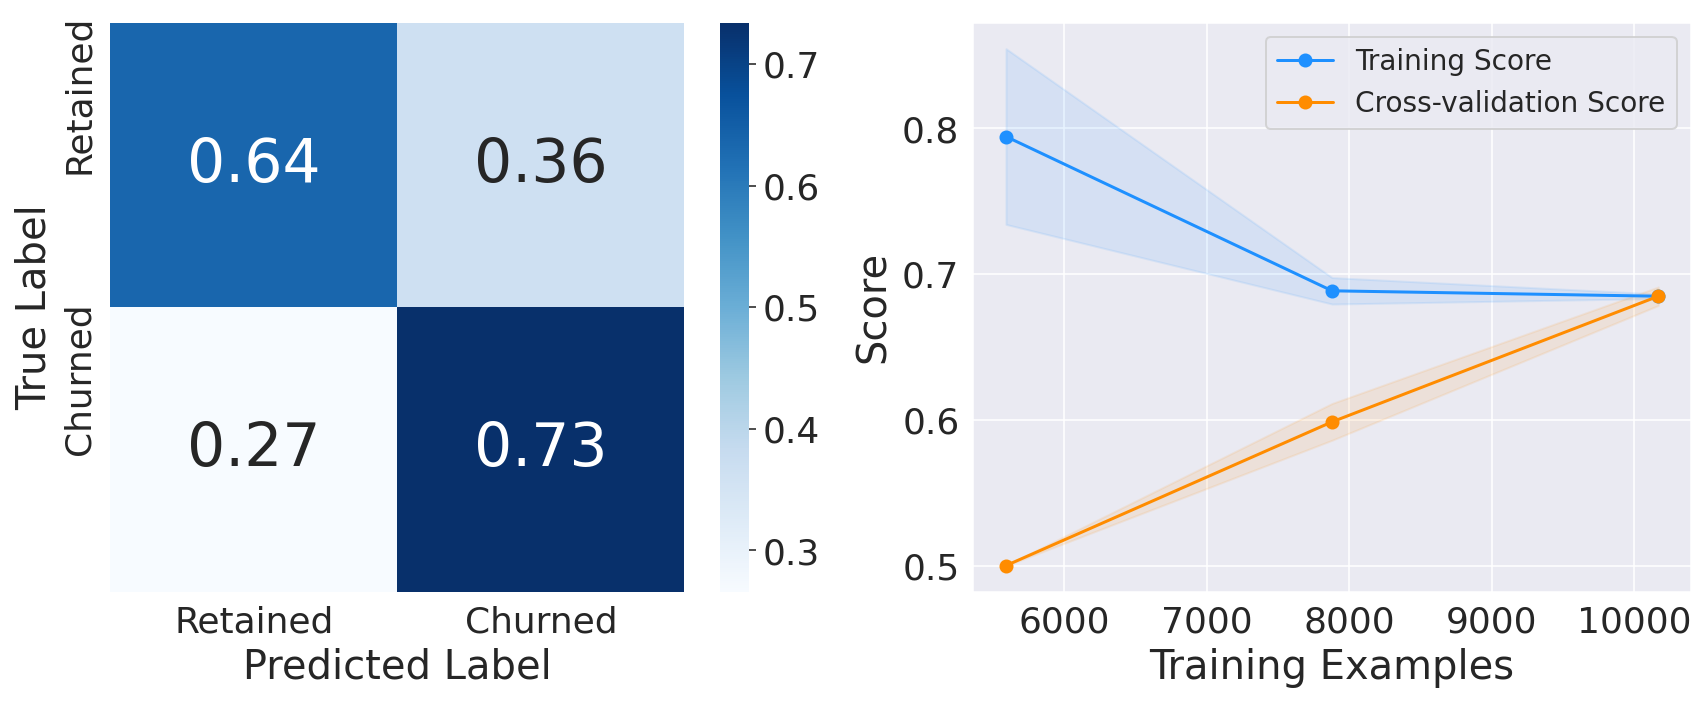

In [ ]:
lr = LogisticRegression(random_state=random_state)

param_grid = [{'max_iter': [25, 50, 100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear']
},{ 'max_iter': [100, 200],
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga']}]

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=2,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

### Random Forest

Fitting 5 folds for each of 48 candidates, totalling 240 fits

 Random Forest
-------------------------------
   Best Score (recall): 0.746
   Best Parameters: 
      max_depth: 5
      min_samples_leaf: 7
      min_samples_split: 2
      n_estimators: 50


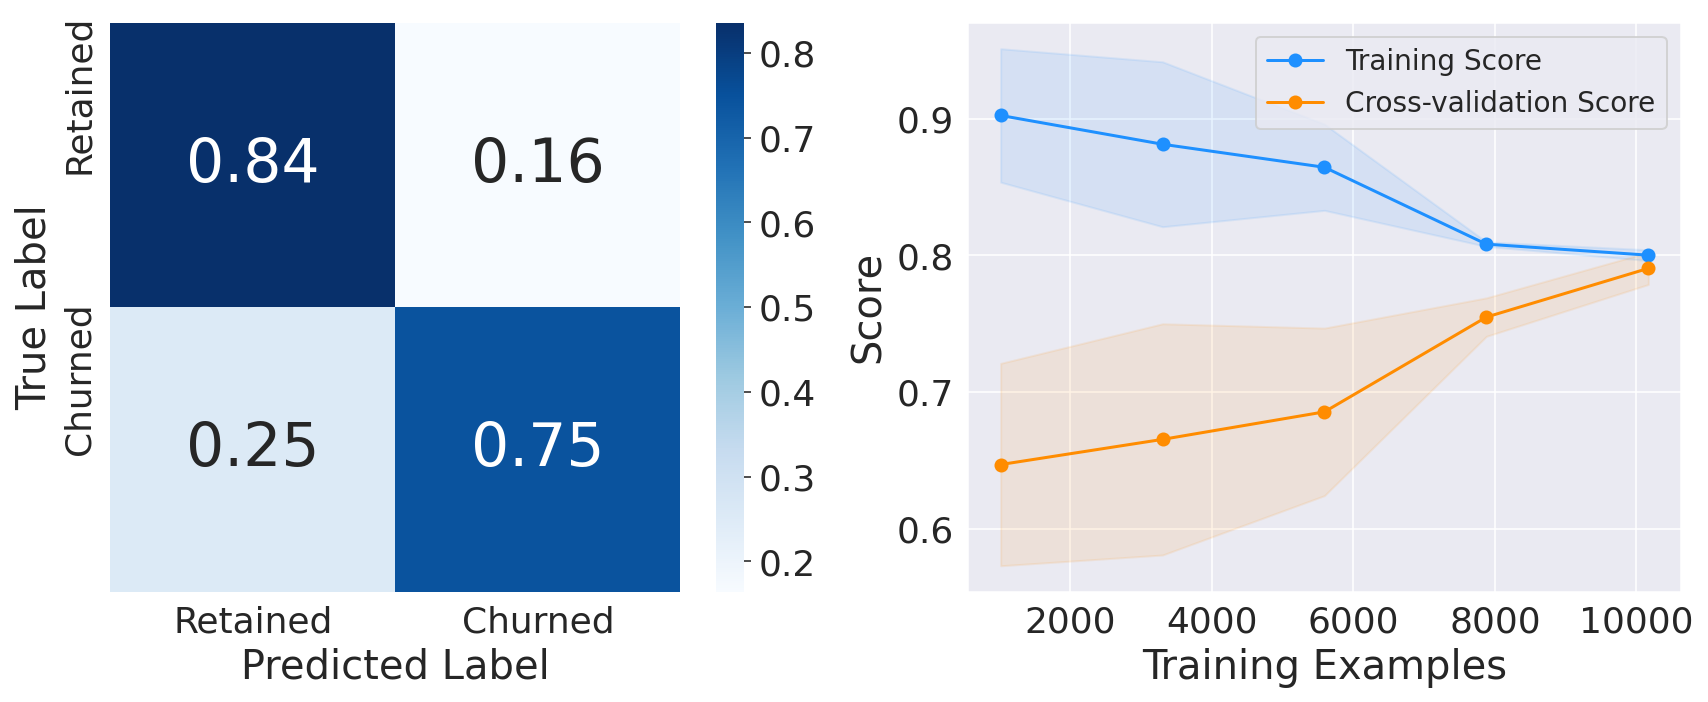

In [ ]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5],
    'min_samples_leaf': [2, 3, 5, 7],
    'min_samples_split': [2, 3, 5, 7]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=2,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

### XGBoost Classifier

Fitting 5 folds for each of 72 candidates, totalling 360 fits

 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.799
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 0.2
      learning_rate: 0.1
      max_depth: 4
      min_child_weight: 1
      n_estimators: 30
      reg_alpha: 2
      reg_lambda: 0
      subsample: 1


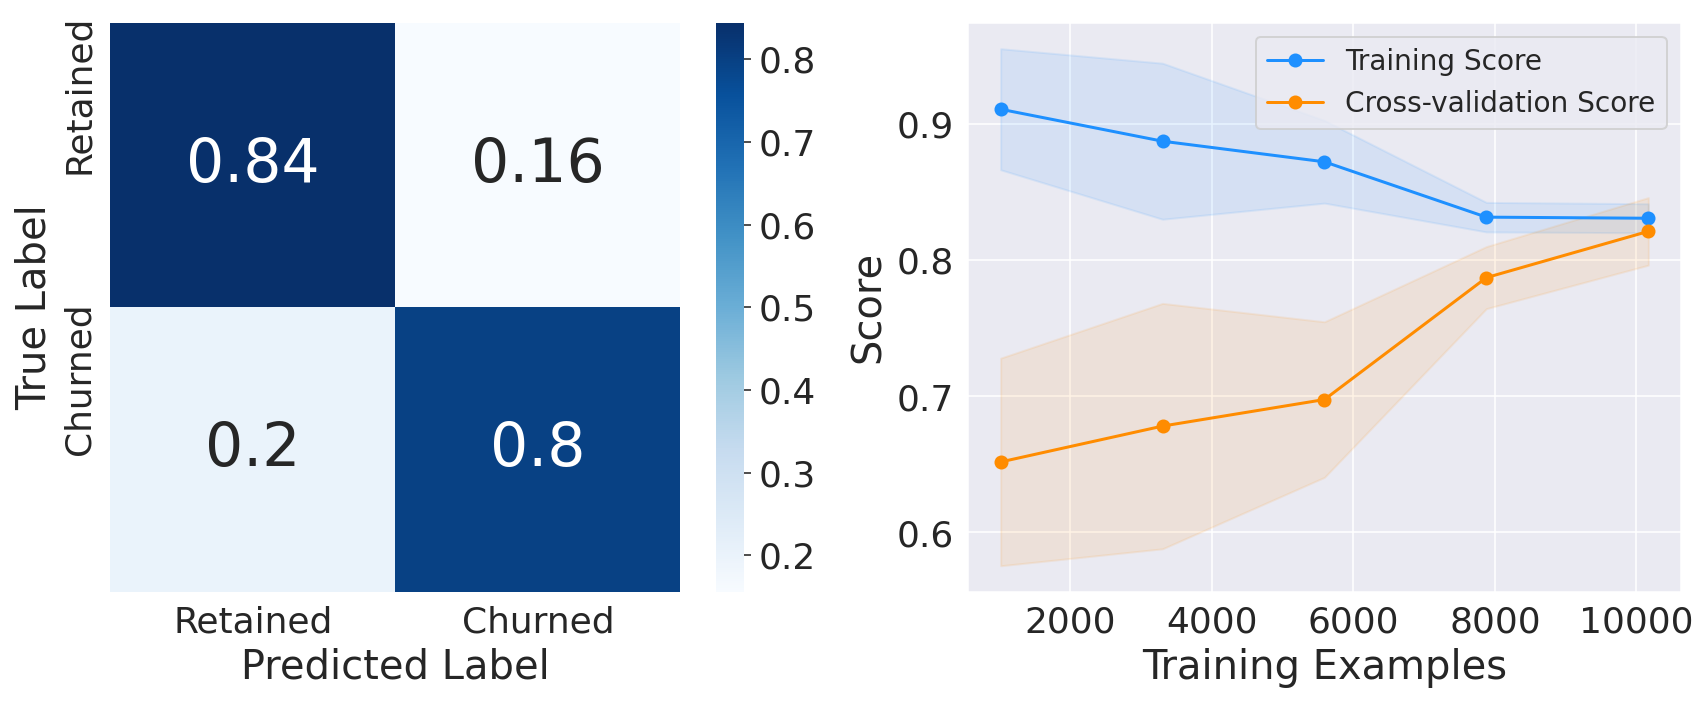

In [ ]:
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [30],
    'learning_rate': [0.001, 0.01, 0.1],
    'colsample_bytree': [0.5],
    'max_depth': [4],
    'reg_alpha': [1, 2],
    'reg_lambda': [0, 1],
    'subsample': [0.5, 0.75, 1],
    'gamma': [0.2, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=2,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')

### Support Vector Classifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.781
   Best Parameters: 
      C: 0.1
      kernel: rbf


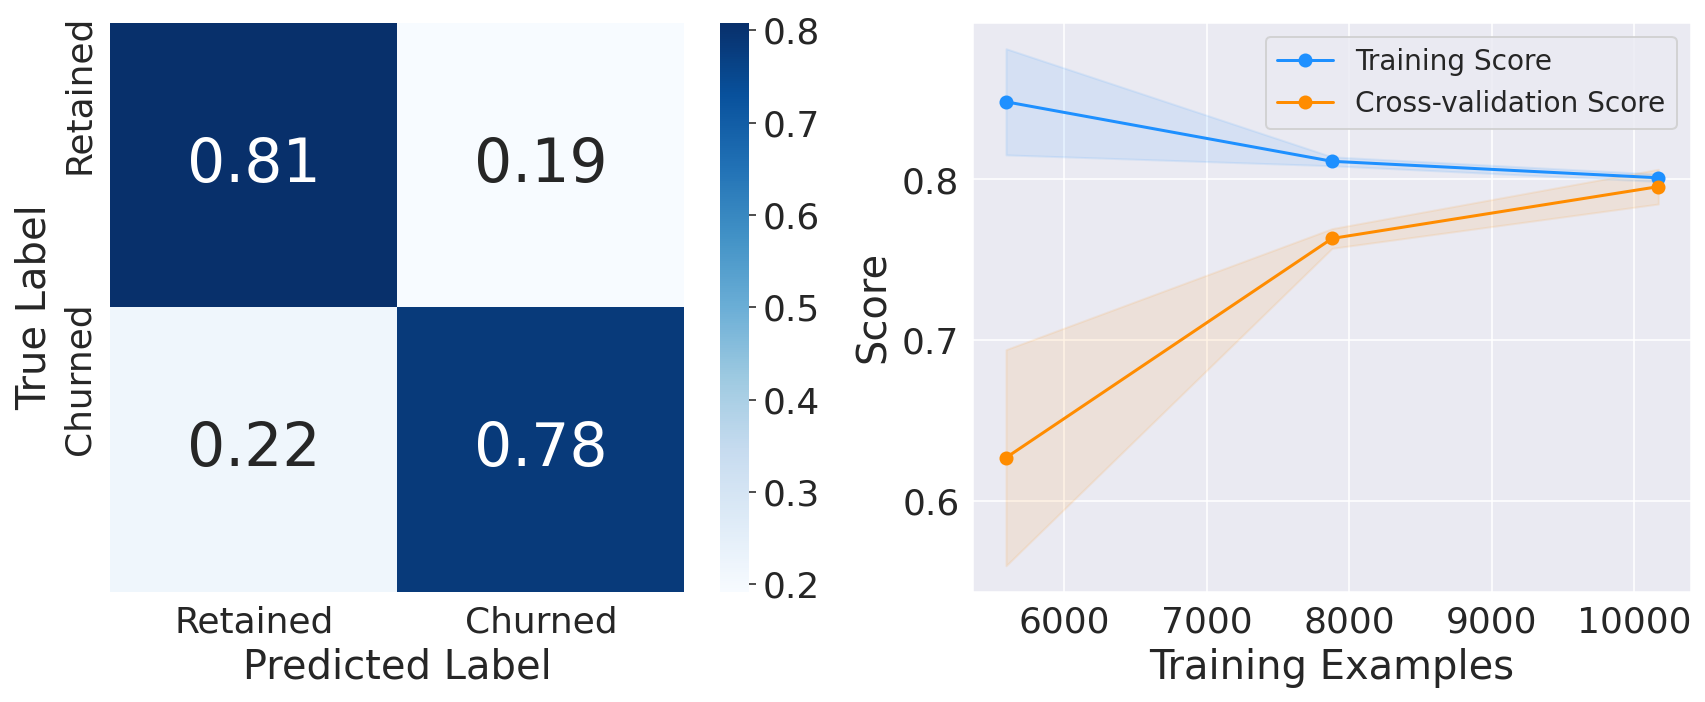

In [ ]:
svc = SVC(probability=True, random_state=random_state)

param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                  'C': [.1]},
                                {'kernel': ['poly'],
                                 'degree': [2, 3],
                                 'C': [.1, 1, 2]}]


svc_clf = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=2,
                       n_jobs=-1)

best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')

##Enasemble Learning

Soft Voting
-----------------
  Recall:  0.782


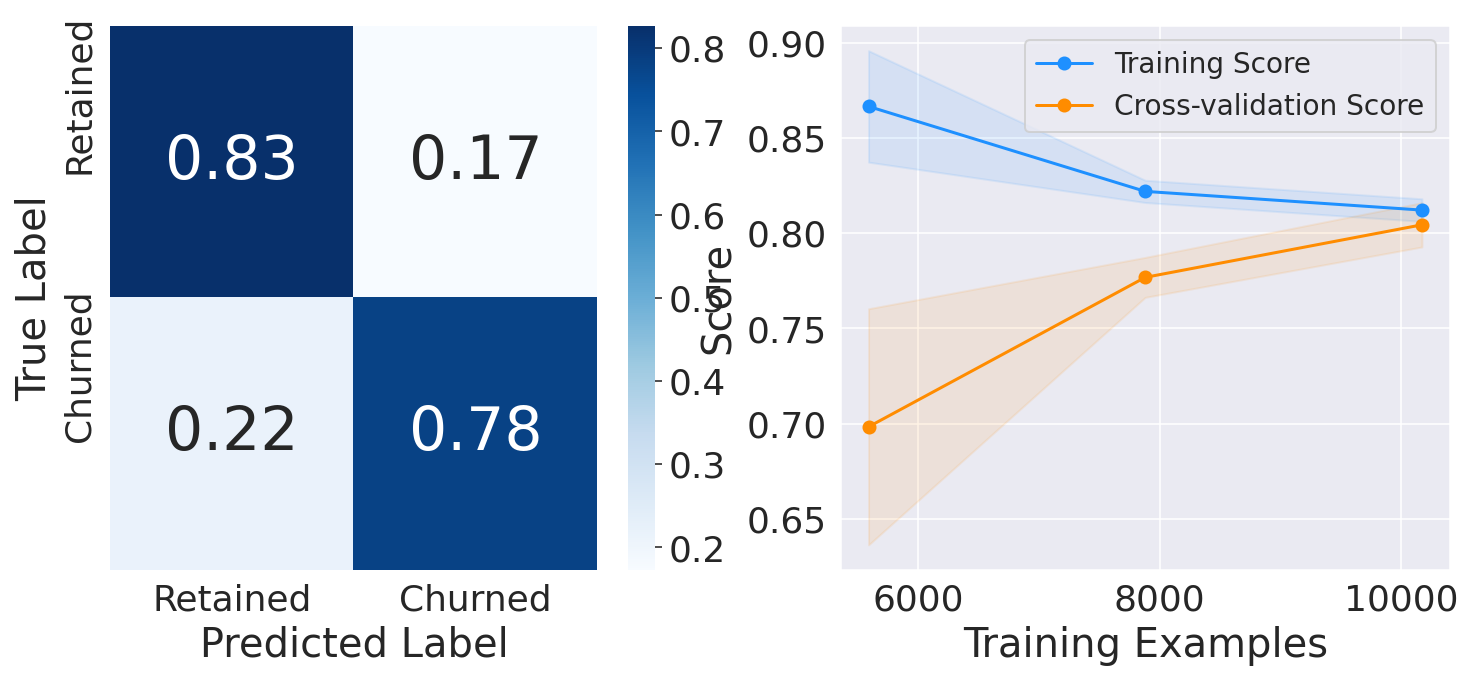

In [ ]:
from sklearn.ensemble import VotingClassifier
estimators = [('LR', best_lr_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_)
]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(y_train, y_pred),
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr
]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

# Results for Uncut data

## Learning Curves & Feature Importance

Some classifiers allow us to visualise feature importance:

In [ ]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');

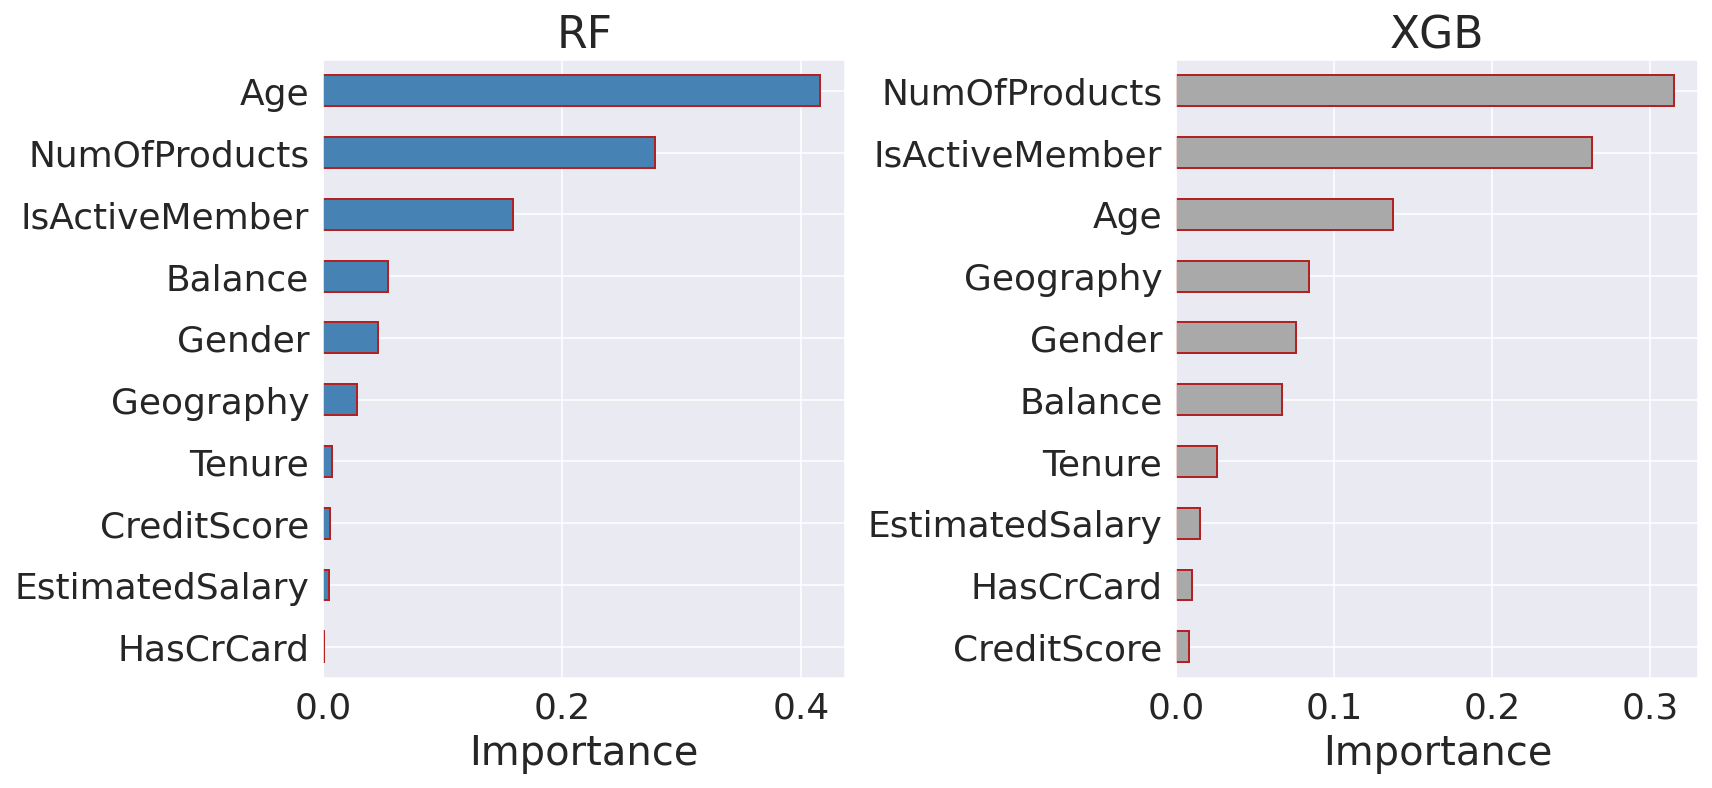

In [ ]:
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(1, 1, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['RF', 'XGB'],
                                    [best_rf_clf, best_xgb_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

We can notice that all of the features that we previously dropped are not very important to our classifiers, and they stand on the bottom of our graph.

What is interesting, is that Tenure feature that I decided to drop earlier is actually more important than CreditScore that I left be. This is an error that could have gave us previously even better results.

## Performance Comparison

Initially, we can compare the performance of our classifiers in terms of four individual metrics (Accuracy, precision, recall):

In [ ]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

Performance on the first look lokks similar but earlier we got higher max recall, we need to validate it.

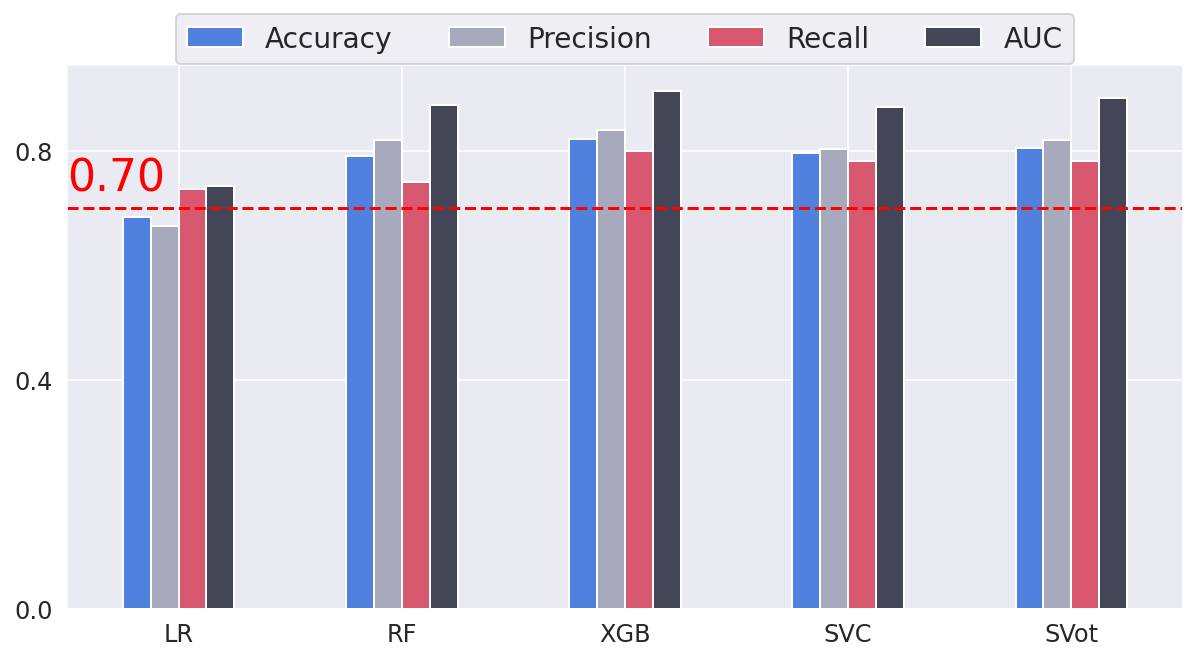

In [ ]:
comparison_df.plot(kind='bar',
                   figsize=(10, 5),
                   fontsize=12,
                   color=['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc='upper center',
           fontsize=font_size - 6,
           ncol=len(comparison_df.columns),
           bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', size=font_size + 2, color='red');

All other classifiers have a recall higher than 70% (baseline performance).

ROC Curve

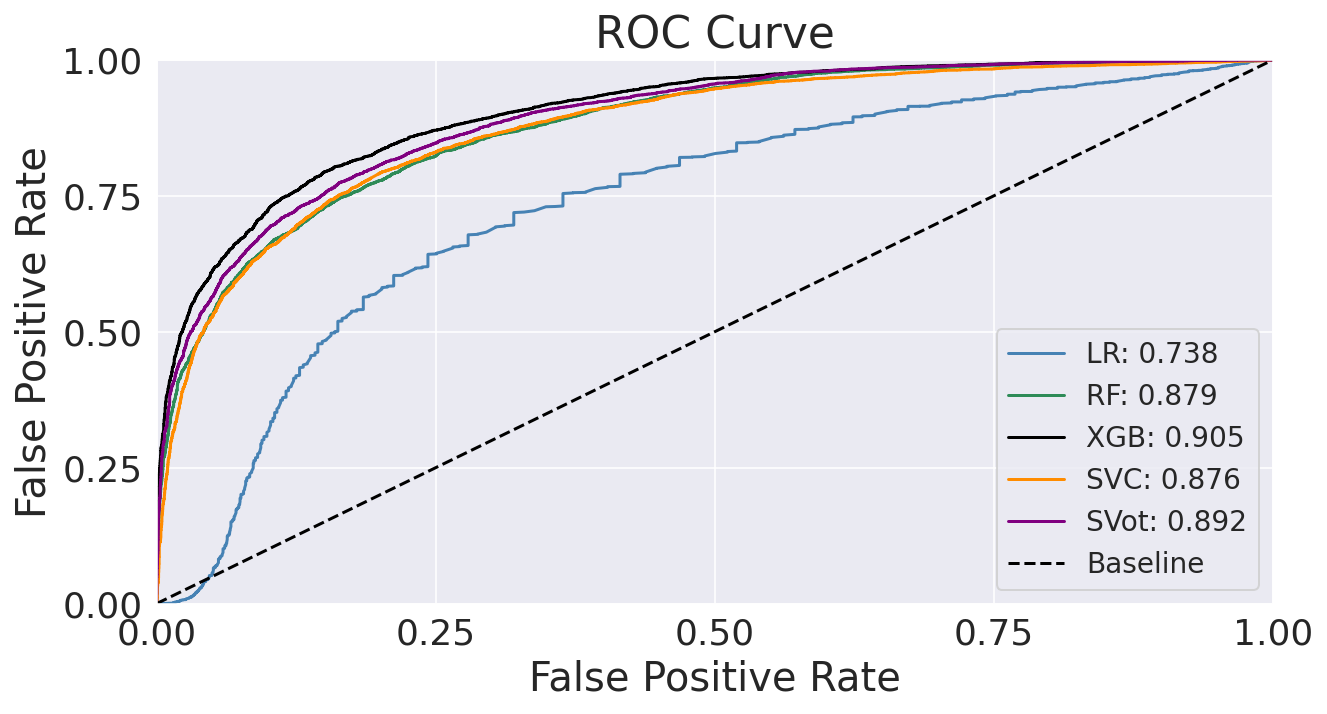

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            color=colors_comp[index],
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('False Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);

Cumulative Gains Curve

Soft Voting:


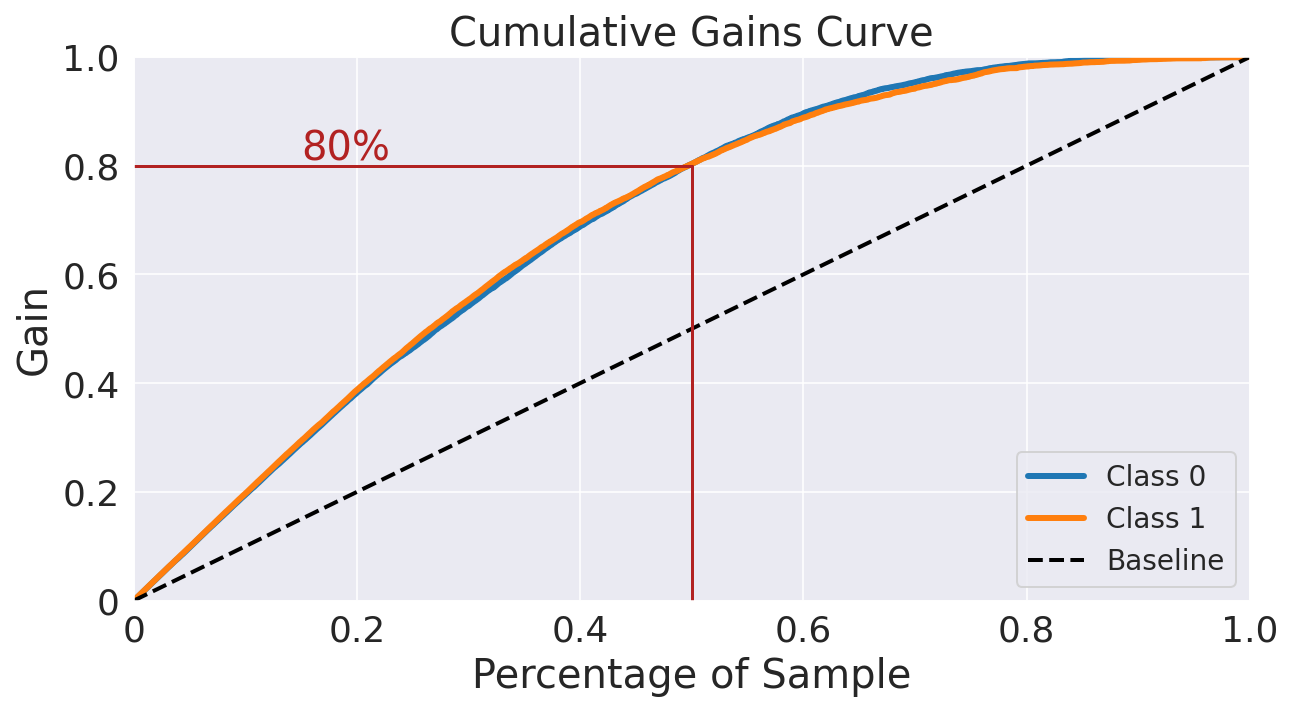

In [ ]:
print('Soft Voting:')

y_pred = cross_val_predict(tuned_voting_soft,
                           X_train,
                           y_train,
                           cv=5,
                           method='predict_proba')

fig, ax = plt.subplots(figsize=(10, 5))

skplt.metrics.plot_cumulative_gain(y_train, y_pred, ax=ax)

ax.plot([0.5, 0.5], [0, 0.8], color='firebrick')
ax.plot([0.0, 0.5], [0.8, 0.8], color='firebrick')

ax.set_title('Cumulative Gains Curve', size=font_size)
ax.set_xlabel('Percentage of Sample', size=font_size)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.set_ylabel('Gain', size=font_size)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.text(0.15, 0.81, '80%', size=font_size, color='firebrick')
ax.legend(fontsize=14);

In [ ]:
def test_func(classifier, classifier_name, ax):
    #Assess the performance on the test set and plot the confusion matrix.
    #from kaggle
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues',
                ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned']);

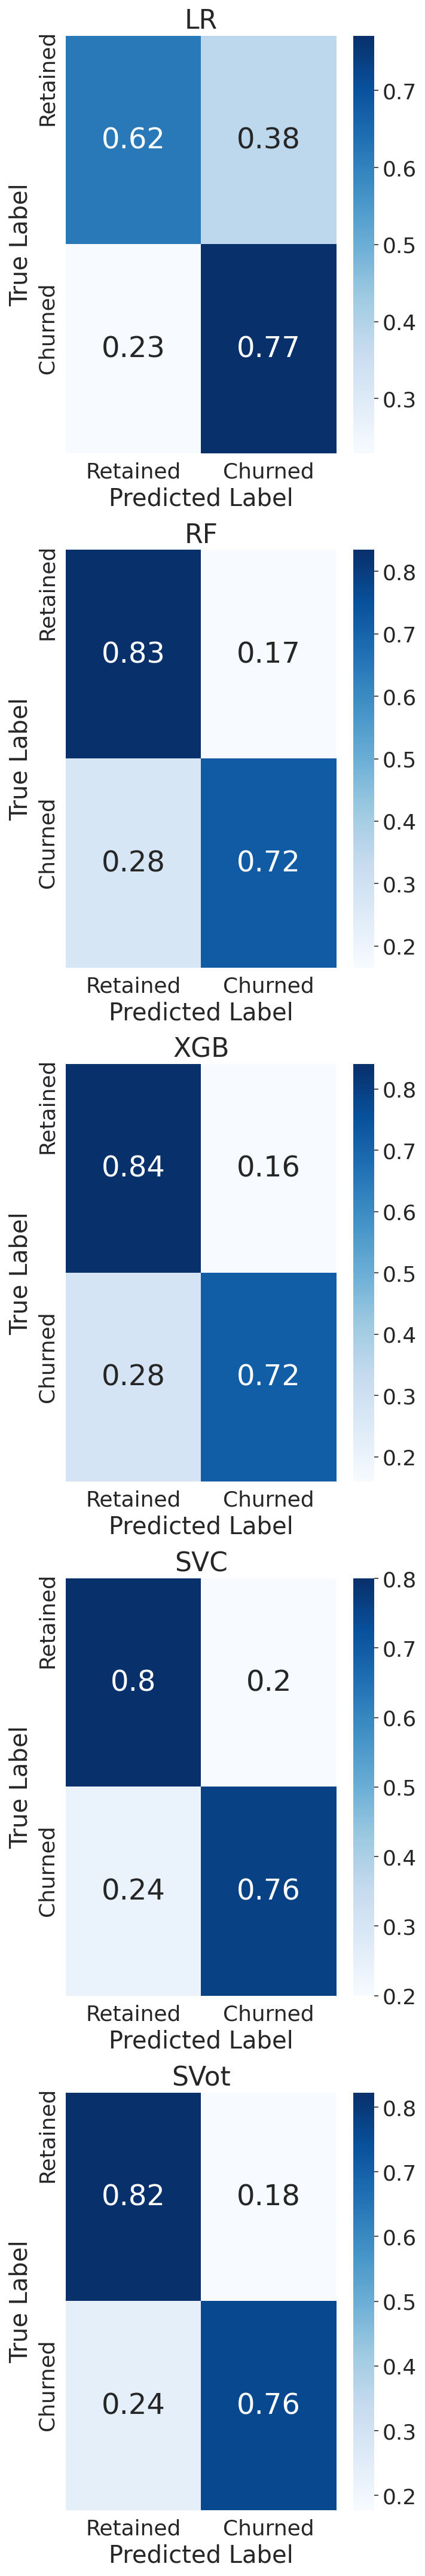

In [ ]:
tuned_voting_soft.fit(X_train, y_train)

fig, ax = plt.subplots(5, 1, figsize=(5, 30))

for i, (name, clf) in enumerate(zip(['LR', 'RF', 'XGB', 'SVC', 'SVot'],
                                    [best_lr_clf.best_estimator_, best_rf_clf.best_estimator_, best_xgb_clf.best_estimator_, best_svc_clf.best_estimator_, tuned_voting_soft])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout();

### **Validation for Uncut data:**

In [ ]:
comparison_test_df = pd.DataFrame(comparison_test_dict,
                                  index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)

Results for validation of uncut data are worse than for cutted data. Recall of all classifiers exept LR is worse.

It can be caused by occurrence of too many features that doesn't give us any information which just "clogged" our models and because of that we couldn't get better or even the same (for most of them) results.

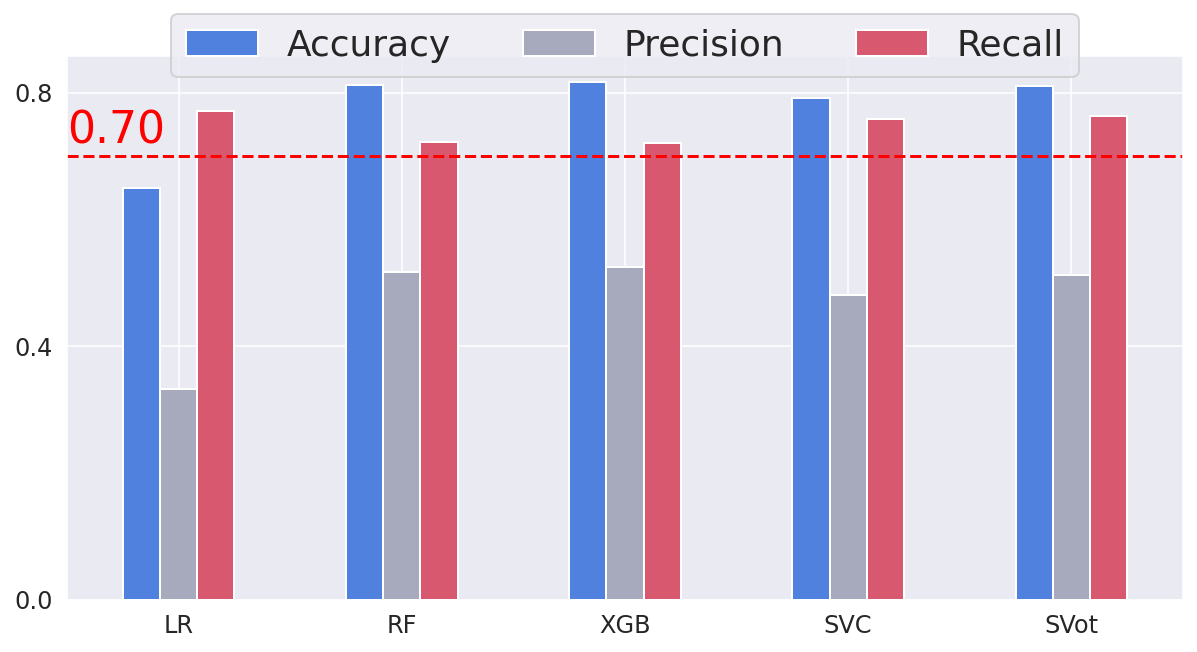

In [ ]:
comparison_test_df.plot(kind='bar',
                        figsize=(10, 5),
                        fontsize=12,
                        color=['#5081DE', '#A7AABD', '#D85870'])

plt.legend(loc='upper center',
           ncol=len(comparison_test_df.columns),
           bbox_to_anchor=(0.5, 1.11))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.72, s='0.70', size=font_size + 2, color='red');

All classifier still got recall over 70% mark.

# Conclusions

The best recall values that we got were: 77.6% for XGB with cutted data, 77.4% for Neural Network with cutted data and 77.1% for LR and RF for cutted data and LR for uncutted data. We can see relation between those results that the best values we got were for cutted data.
For uncutted data we got on average worse results by 5% which is a lot, taking into account that this is olny because we didn't delete any features.
For overfitted data we got on average worse results by 15% which is incredibly worse taking into account how promising test data looked like. Best model was XGBoost Classifier it gave us best results, but most solid one was Logistic Regression, with even uncutted data it gave us the same concrete results.

To sum up, we should always perform Exploratory data analysis at the begining of our work with Machine Learning. It gives us better understanding of our data in general which is very useful for prepering later models. But most importantly after doing it right we could get later results better by even 5%, also what is an advantage our models are working faster with less data.
We should also avoid by all means overfitting, as much as results for training data are looking nice, validation of those models is just brutal by giving us worse results by even 20%.